# ecDNA replication is disorganised and vulnerable to replication stress

**Written by Pauline L. Pfuderer, Cancer Research UK Cambridge Centre & Department of Pathology, Cambridge, United Kingdom**

### Notes for this Jupyter Notebook

This Jupyter Notebook contains analysis code, stats and visualisation scripts for the manuscript "ecDNA replication is disorganised and vulnerable to replication stress"

Circular plots of ecDNA were created using R, a separate R Markdown script is available for these plots.

## General setup


### Imports

In [1]:
# general imports
import sys
import os
import pandas as pd
import numpy as np
from itertools import combinations

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors

# GC content imports
from Bio import SeqIO
from collections import Counter
import random

### Output path

In [2]:
date = '20250407'

outpath = f'/Users/pfuderer/Documents/PhD/output/ecDNA_manuscript/{date}'

os.makedirs(outpath, exist_ok = True)

# all figures list
figure_dirs = [
	'figure_01', 
	'figure_04', 
	'figure_05',
	'figure_supp_03', 'figure_supp_04',
	'figure_supp_05', 'figure_supp_06',
	'figure_supp_07']

# make figure subdirectories
for dir_name in figure_dirs:
	os.makedirs(f'{outpath}/{dir_name}', exist_ok=True)
	
# print
print(outpath)

/Users/pfuderer/Documents/PhD/output/ecDNA_manuscript/20250407


### Plot theme

In [3]:
# seaborn theme
custom_params = {
	"axes.spines.right": False,  # disable the right spine
	"axes.spines.top": False,    # disable the top spine
	"axes.labelcolor": "black",  # set axis labels to black
	"xtick.color": "black",      # set x-axis tick labels to black
	"ytick.color": "black",      # set y-axis tick labels to black
	"text.color": "black",       # set general text color to black
	"font.family": "Helvetica Neue"       # set the font to Arial
}

sns.set_theme(style = 'ticks', rc = custom_params, palette = None, font = 'Helvetica Neue')

### Colors

In [4]:
colors_dict = {'red': '#B2182B',
				'blue': '#2166AC',
				'green': '#1B7837',
				'red2': '#D6604D',
				'red3': '#F4A582',
				'blue2': '#4393C3',
				'blue3': '#92C5DE',
				'green2': '#5AAE61',
				'green3': '#ACD39E',
				'grey': '#DDDDDD',
				'dark_grey': '#555555'}

## Function definitions

### P-value annotation

In [5]:
# formatting functions for p values
def format_p_value(p_value):
	if p_value <= 0.0001:
		return '****'
	elif p_value <= 0.001:
		return '***'
	elif p_value <= 0.01:
		return '**'
	elif p_value <= 0.05:
		return '*'
	elif p_value > 0.05:
		return 'ns'

# p value annotation in plots
def annotate_p_values(ax, df, group_col, value_col, comparisons,
					  test='ranksums',     # 'mannwhitneyu', 'ranksums', 'ttest_ind'
					  display='numeric',   # 'numeric' or 'stars'
					  bracket_offset=0.1,  # distance above the highest data point/bracket
					  bracket_height=0.2,  # height of the bracket arms
					  text_offset=0.05,    # additional distance above bracket for the text
					  star_fontsize=18,    # font size for star annotations
					  p_value_fontsize=10, # font size for numeric p-value annotations
					  order=None,          # specify the order of the groups
					  linewidth=1.5,       # thickness of the bracket lines
					  only_sig=False):	   # only display significant p-values
	# order
	if order is not None:
		unique_groups = order
	else:
		unique_groups = df[group_col].unique()
	# map each group to its integer x-position
	group_positions = {group: i for i, group in enumerate(unique_groups)}
	# track the highest bracket/data y-value for each group
	current_tops = {}
	for group in unique_groups:
		group_data = df.loc[df[group_col] == group, value_col]
		current_tops[group] = group_data.max()
	# perform each pair-wise comparison
	for group1, group2 in comparisons:
		x1, x2 = group_positions[group1], group_positions[group2]
		data1 = df.loc[df[group_col] == group1, value_col]
		data2 = df.loc[df[group_col] == group2, value_col]
		# set statistical test
		if test == 'mannwhitneyu':
			_, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
		elif test == 'ranksums':
			_, p_val = stats.ranksums(data1, data2, alternative='two-sided')
		elif test == 'ttest_ind':
			_, p_val = stats.ttest_ind(data1, data2, equal_var = False)
		else:
			raise ValueError(f'Unrecognized test: {test}')
		# only significant p-values
		if only_sig and p_val > 0.05:
			continue
		# place bracket above the current tops of the two groups
		span_min = min(x1, x2)
		span_max = max(x1, x2)
		y_start = max(
			current_tops[g]
			for g in unique_groups
			if span_min <= group_positions[g] <= span_max
		) + bracket_offset
		# draw the bracket
		ax.plot([x1, x1, x2, x2],
				[y_start, y_start + bracket_height,
				y_start + bracket_height, y_start],
				c='k', lw=linewidth)
		# numeric p-values or stars
		if display == 'stars':
			text = format_p_value(p_val)
			fsize = star_fontsize
		else:
			text = f'p = {p_val:.3g}'
			fsize = p_value_fontsize
		# print text above the bracket
		ax.text((x1 + x2) / 2,
				y_start + bracket_height + text_offset,
				text,
				ha='center', va='bottom', fontsize=fsize, color='k')
		# new top position (y-axis)
		new_top = y_start + bracket_height + text_offset
		for g in unique_groups:
			if span_min <= group_positions[g] <= span_max:
				current_tops[g] = new_top

### Chromosome naming (NC_ to chr)

In [6]:
# use assembly report for mapping
conversion_table = '/Users/pfuderer/Documents/PhD/genomes/GCF_000001405.40_GRCh38.p14_assembly_report.txt'

# read in the conversion table
conv_lines = []
with open(conversion_table, 'r') as file:
	for line in file:
		# check if the line starts with a number, X, or Y
		if line[0].isdigit() or line.startswith(('X', 'Y')):
			conv_lines.append(line.strip().split('\t'))

# convert the selected lines into a pd df
conv_df = pd.DataFrame(conv_lines)

# convert to dict
conv_dict_df = conv_df[[6, 9]].copy()
conv_dict_df.columns = ['NC_ID', 'chromosome']
conv_dict = dict(zip(conv_dict_df['NC_ID'], conv_dict_df['chromosome']))

# function to convert chromosome names
def convert_chromosome_names(df):
	df = df[df['chromosome'].str.contains('NC_')]
	df = df.copy()
	df['chromosome'] = df['chromosome'].map(conv_dict).fillna(df['chromosome'])
	return df


### Data import & cleaning

In [7]:
# 01: import
def import_csv_data(csv_dict, base_path):
	dfs = {}
	for key, filename in csv_dict.items():
		df = pd.read_csv(base_path + filename, sep=',', header=0, index_col=False)
		dfs[key] = df
	return dfs


# 02: keep only forks with speed and stall score
def keep_speed_stall(dfs_dict):
	cleaned = {}
	for key, df in dfs_dict.items():
		temp = df.dropna(subset=['fork_speed']) # remove rows missing fork_speed
		temp = temp[temp['stall_score'] >= 0]   # remove rows with stall_score < 0
		cleaned[key] = temp
	return cleaned


# 03: remove outliers outside +/- 1.5 IQR
def remove_outliers_iqr(dfs_dict, column = 'fork_speed'):
	def iqr_filter(df, col):
		Q1 = df[col].quantile(0.25)
		Q3 = df[col].quantile(0.75)
		IQR = Q3 - Q1
		lower_bound = Q1 - 1.5 * IQR
		upper_bound = Q3 + 1.5 * IQR
		return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
	filtered_dict = {}
	for key, df in dfs_dict.items():
		filtered_dict[key] = iqr_filter(df, column)
	return filtered_dict


# 04: exclude stalled forks
def excl_stalled_forks(dframe_dict, threshold=0.8):
	filtered = {}
	for k, dframe in dframe_dict.items():
		filtered[k] = dframe[dframe['stall_score'] < threshold].copy()
	return filtered


# 05: exclude chromosome Y (and chromosome 8)
def exclude_chromosomes(dfs_dict, exclude_list, chrom_name_col='chromosome'):
	excluded_dict = {}
	for key, df in dfs_dict.items():
		excluded_dict[key] = df[~df[chrom_name_col].isin(exclude_list)].copy()
	return excluded_dict


# 06: overview of fork counts
def compute_fork_overview(dfs_dict, label=''):
	overview_df = pd.DataFrame(columns=['cell_line', 'dataset', 'fork_orientation', 'count'])
	for dataset_name, dataset_df in dfs_dict.items():
		for sub_dataset in dataset_df['dataset'].unique():
			subset = dataset_df[dataset_df['dataset'] == sub_dataset]
			left_count = len(subset[subset['fork_orientation'] == 'left'])
			right_count = len(subset[subset['fork_orientation'] == 'right'])
			# left
			overview_df = pd.concat([
				overview_df,
				pd.DataFrame({
					'cell_line': dataset_name, 
					'dataset': sub_dataset, 
					'fork_orientation': 'left', 
					'count': left_count
				}, index=[0])
			], ignore_index=True)
			# right
			overview_df = pd.concat([
				overview_df,
				pd.DataFrame({
					'cell_line': dataset_name, 
					'dataset': sub_dataset, 
					'fork_orientation': 'right', 
					'count': right_count
				}, index=[0])
			], ignore_index=True)
	overview_df = overview_df.sort_values(by='dataset').reset_index(drop=True)
	print(f'Overview {label}')
	display(overview_df)
	return overview_df

# read in DNAscent analysis output
def read_specific_value(directory, main_path, dataset_name, sub_path, reference_genome):
	# create path to csv file
	file_path = os.path.join(main_path, directory, sub_path)
	# get full path of the csv file
	csv_file = [f for f in os.listdir(file_path) if f.endswith("_all_stats.csv")]
	# check if file exists
	if not csv_file:
		print(f"Error: No YYYYMMDD_all_stats.csv file found in directory: {directory}")
		return None
	# read in csv file
	data = pd.read_csv(os.path.join(file_path, csv_file[0]), header=None)
	#print(data)
	# filter for row of interest
	specific_row = data[data[0] == "05_reads_analysed_by_DNAscent_detect"]
	if specific_row.empty:
		print(f"Error: No value 05_reads_analysed_by_DNAscent_detect in directory: {directory}")
		return None
	# extract value
	reads = specific_row.iloc[0, 1]
	# output
	return pd.DataFrame({'replicate': [directory.rstrip('/')], 'dataset': [dataset_name], 'reads': [reads], 'reference_genome': [reference_genome]})


### Origin coverage bins

In [8]:
# calculate coverage in origin bins
def compute_coverage(df, bins):
	coverage = np.zeros(len(bins) - 1)
	for _, row in df.iterrows():
		read_start = row['start_position']
		read_end = row['end_position']
		# bins read overlaps with
		start_bin = np.searchsorted(bins, read_start, side='right') - 1
		end_bin = np.searchsorted(bins, read_end, side='right') - 1
		# add coverage to bins
		for i in range(start_bin, end_bin + 1):
			if 0 <= i < len(coverage):
				coverage[i] += 1
	return coverage

# count origins per bin
def count_origins_per_bin(df_origins, df_bins):
	result = df_bins.apply(
		lambda row: ((df_origins['midpoint'] >= row['bin_start']) & 
					 (df_origins['midpoint'] < row['bin_end'])).sum(), axis=1)
	return result

# Figure 1

### Figure 1e - FACS enrichment

,dataset,reads_ecDNA,reads_hg38,ratio,FACS_enrichment
0,2022_11_25_JJ_ONT_Dsc_ecDNA,1329,2711,0.490225,FACS enriched
1,2022_12_02_JJ_ONT_Dsc_ecDNA2,12010,20420,0.588149,FACS enriched
2,2023_06_04_JJ_ONT_Dsc_Fcs,3114,5213,0.597353,FACS enriched
3,2023_08_07_JJ_ONT_ecDNA_FACS,12805,26422,0.484634,FACS enriched
4,2023_03_21_JJ_ONT_PromethION1-8_d6c4705fpassfail,49941,1033563,0.048319,No enrichment
5,20230523_1042_2E_PAO32230_cc7c73b8,32393,674953,0.047993,No enrichment
6,20230523_1042_1G_PAO33157_73091287,24842,509674,0.048741,No enrichment


,FACS_enrichment,mean,count
0,FACS enriched,0.540090,4
1,No enrichment,0.048351,3


Wilcoxon Rank Sum Test FACS enriched vs No enrichment (two-sided):
stat: 2.1213203435596424, p-value: 0.033894853524689274


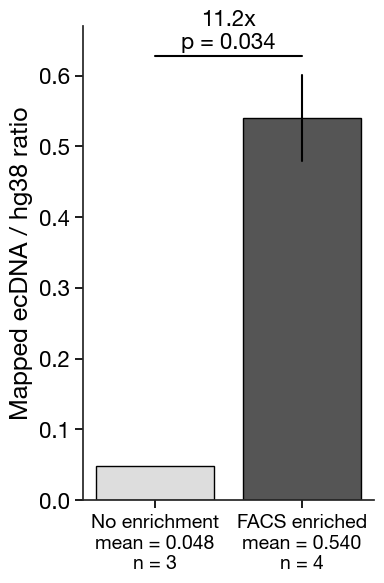

mean no enrichment: 0.04835106397493472
mean FACS enriched: 0.5400901679745724
enrichment factor: 11.2x
Wilcoxon Rank Sum Test p-value: 0.033894853524689274


In [53]:
#------------------ 01 READ IN CSV ------------------

# 01: dnascent_v312_ecDNA/analyse input paths
directories_FACS = [
	'2022_11_25_JJ_ONT_Dsc_ecDNA', # dev_FACS_1
	'2022_12_02_JJ_ONT_Dsc_ecDNA2', # dev_FACS_2
	'2023_06_04_JJ_ONT_Dsc_Fcs', # dev_FACS_3
	'2023_08_07_JJ_ONT_ecDNA_FACS'] # dev_FACS_4

directories_DM = [
	'2023_03_21_JJ_ONT_PromethION1-8_d6c4705fpassfail/',  # DM_untreated_rep1
	'20230523_1042_2E_PAO32230_cc7c73b8/', # DM_untreated_rep3
	'20230523_1042_1G_PAO33157_73091287/'] # DM_untreated_rep4

all_directories = {
	'directories_FACS': directories_FACS,
	'directories_DM': directories_DM}

# 02: prefix and suffix paths (local)
main_path = '/Users/pfuderer/Documents/PhD/output/DNAscent/'
sub_path_ecDNA = 'dnascent_v312_ecDNA/analyse/'
sub_path_hg38 = 'dnascent_v312/analyse/'

# 03: FACS enrichment status
FACS = {
	'2023_03_21_JJ_ONT_PromethION1-8_d6c4705fpassfail': 'No enrichment',
	'20230523_1042_2E_PAO32230_cc7c73b8': 'No enrichment',
	'20230523_1042_1G_PAO33157_73091287': 'No enrichment',
	'2022_11_09_JJ_ONT_Dsc_Chr8_washes': 'FACS enriched',
	'2022_11_25_JJ_ONT_Dsc_ecDNA': 'FACS enriched',
	'2022_12_02_JJ_ONT_Dsc_ecDNA2': 'FACS enriched',
	'2023_04_12_JJ_ONT_Dsc_ecD_FCS_3/1st_run': 'FACS enriched',
	'2023_04_12_JJ_ONT_Dsc_ecD_FCS_3/2nd_run': 'FACS enriched',
	'2023_06_04_JJ_ONT_Dsc_Fcs': 'FACS enriched',
	'2023_08_07_JJ_ONT_ecDNA_FACS': 'FACS enriched'}

adaptive_sampling = {
	'2023_03_21_JJ_ONT_PromethION1-8_d6c4705fpassfail': 'No enrichment',
	'20230404_1021_2F_PAO32425_75987c73': 'adaptive_sampling',
	'20230523_1042_2E_PAO32230_cc7c73b8': 'No enrichment',
	'20230523_1042_1G_PAO33157_73091287': 'No enrichment'}


# 05: apply function
df_reads = pd.DataFrame(columns=['replicate', 'dataset', 'reads', 'reference_genome'])
for dataset_name, directories in all_directories.items():
	for directory in directories:
		row_ecDNA = read_specific_value(directory, main_path, dataset_name, sub_path_ecDNA, reference_genome = 'ecDNA')
		if row_ecDNA is not None:
			df_reads = pd.concat([df_reads, row_ecDNA], ignore_index = True)
		row_hg38 = read_specific_value(directory, main_path, dataset_name, sub_path_hg38, reference_genome = 'hg38')
		if row_hg38 is not None:
			df_reads = pd.concat([df_reads, row_hg38], ignore_index = True)

# 06: convert strings to integers
df_reads['reads'] = df_reads['reads'].astype(float).astype(int)

#------------------ 02 MAP ENRICHMENT ------------------

# 01: map FACS enrichment status to dataset
df_reads['FACS_enrichment'] = df_reads['replicate'].map(FACS)

# 02: get ratio of ecDNA to hg38
df_ratio = pd.DataFrame(columns=['dataset', 'reads_ecDNA', 'reads_hg38', 'ratio', 'FACS_enrichment'])

for dataset in list(df_reads['replicate'].unique()):
	# get ecDNA reads
	reads_ecDNA = df_reads[(df_reads['replicate'] == dataset) & (df_reads['reference_genome'] == 'ecDNA')]['reads'].sum()
	# get hg38 reads
	reads_hg38 = df_reads[(df_reads['replicate'] == dataset) & (df_reads['reference_genome'] == 'hg38')]['reads'].sum()
	# calculate ratio
	ratio = reads_ecDNA/reads_hg38
	# other into
	enriched = df_reads[(df_reads['replicate'] == dataset)]['FACS_enrichment'].values[0]
	# output
	df_ratio.loc[len(df_ratio)] = [dataset, reads_ecDNA, reads_hg38, ratio, enriched]

# 03: save to csv
display(df_ratio)
df_ratio.to_csv(f'{outpath}/figure_01/{date}_FACS_enrichment_ratio.csv', index = False)

#------------------ 03 PLOT BY ENRICHMENT ------------------

# colors
colors = [colors_dict['dark_grey'], colors_dict['grey']]

# 01: barplot with error bars
# get mean and n
grouped = df_ratio.groupby('FACS_enrichment')['ratio'].agg(['mean', 'count']).reset_index()
display(grouped)

# calculate enrichment factor
mean_no_enrichment = grouped[grouped['FACS_enrichment'] == 'No enrichment']['mean'].values[0]
mean_FACS_enriched = grouped[grouped['FACS_enrichment'] == 'FACS enriched']['mean'].values[0]
enrichment_factor = f'{round(mean_FACS_enriched/mean_no_enrichment, 1)}x'

# p value
FACS_enriched_data = df_ratio[df_ratio['FACS_enrichment'] == 'FACS enriched']['ratio']
no_enrichment_data = df_ratio[df_ratio['FACS_enrichment'] == 'No enrichment']['ratio']
stat, p_value = stats.ranksums(FACS_enriched_data, no_enrichment_data, alternative = 'two-sided')
p_label = f'p = {p_value:.3f}'
print(f'Wilcoxon Rank Sum Test FACS enriched vs No enrichment (two-sided):\nstat: {stat}, p-value: {p_value}')


# custom order
custom_order = ['No enrichment', 'FACS enriched'] 

# bar plot
plt.figure(figsize=(4, 6))
ax = sns.barplot(x = 'FACS_enrichment', y = 'ratio', data = df_ratio, hue = 'FACS_enrichment', errorbar='sd', err_kws={'linewidth': 1.5, 'color': 'black'}, palette = colors, edgecolor = 'black', order = custom_order)
categories_order = [tick.get_text() for tick in ax.get_xticklabels()]
new_labels = []
for category in categories_order:
	row = grouped[grouped['FACS_enrichment'] == category].iloc[0]
	label = f"{row['FACS_enrichment']}\nmean = {row['mean']:.3f}\nn = {row['count']}"
	new_labels.append(label)

# enrichment factor
x1, x2 = 0, 1  # positions of the two groups on the x-axis
y, h = max(df_ratio['ratio']) * 1.05, 0.005  # y-position for the line and height adjustment
ax.plot([x1, x2], [y, y], lw = 1.5, c = 'black')
ax.text((x1 + x2) * .5, y + h, f'{enrichment_factor}\n{p_label}', ha = 'center', va = 'bottom', color = 'black', fontsize = 16)
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylim(0, 0.67)
plt.xlabel('', size = 12)
plt.ylabel('Mapped ecDNA / hg38 ratio', fontsize = 18)
#plt.title('Ratio ecDNA to hg38 reads', fontsize = 18)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=16) 
plt.tight_layout()
plt.savefig(f'{outpath}/figure_01/{date}_FACS_enrichment_ratio.pdf')
plt.show()
plt.close()


# save stats
stats_text = f'mean no enrichment: {mean_no_enrichment}\nmean FACS enriched: {mean_FACS_enriched}\nenrichment factor: {enrichment_factor}\nWilcoxon Rank Sum Test p-value: {p_value}'
with open(f'{outpath}/figure_01/{date}_FACS_enrichment_ratio_stats.txt', "w") as file:
	print(stats_text)
	file.write(stats_text)


# Figure 2

a. FACS sorting illustration

b. & d. Repli-Seq data

c. Rao's quadratic entropy

# Figure 3

a. analogue treatment scheme

b. IGV screenshot of origins

c. & d. Circos plot (see R script)

# Figure 4

a. IGV screenshot of forks

**b. & c. Boxplot fork speed and stall score**

**d. Dotplot fork speed per chromosome**

**e., f., g. & h. Boxplots fork speed and stall score**

i. & j. Circos plot (see R script)

## Boxplots fork speed & stall score

- Figure 4 and Figure 5
- csv file generated with `01_DNAscent_csv/createCsv_forks.py`


### Read in data, remove IQR outliers and clean


- only include forks where both, fork speed and stall score are available

- IQR removal procedure:

	_"Outliers were removed based on the IQR. The 1st (Q1, 25%) and 3rd quartiles (Q3, 75%) were calculated, and the IQR was defined as the difference between Q3 and Q1. Outliers were identified as data points lying below the lower bound (Q1 - 1.5 * IQR) or above the upper bound (Q3 + 1.5 * IQR) and were excluded from further analysis."_


In [10]:
#------------------ 01 READ IN ------------------

# replicate names as uploaded on ENA
dict_replicates = {'2023_03_21_JJ_ONT_PromethION1-8_d6c4705fpassfail': 'DM_untreated_rep1',
				   '20230404_1021_2F_PAO32425_75987c73': 'DM_untreated_rep2', # adaptive sampling
				   '20230523_1042_2E_PAO32230_cc7c73b8': 'DM_untreated_rep3',
				   '20230523_1042_1G_PAO33157_73091287': 'DM_untreated_rep4',
				   '20240110_1432_1G_PAQ70212_069eaaf1': 'DM_HU_rep1',
				   '20240110_1432_2G_PAQ61880_ba3b9440': 'DM_HU_rep2',
				   '20240110_1432_3G_PAQ89405_a452f409': 'DM_HU_rep3',
				   '20230425_1010_3H_PAO32479_809afcd8': 'HSR_untreated_rep1',
				   '20230510_1054_1G_PAO32432_0bc1c999': 'HSR_untreated_rep2',
				   '20230510_1054_3D_PAO33004_ced1b521': 'HSR_untreated_rep3',
				   '20230523_1042_3F_PAO33005_6c56f96b': 'HSR_untreated_rep4'}

# path
csv_path = '/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20240405/'

# csv files to read in
csv_files = {
	'df_DM_ecDNA': '20240405_directories_DM_ecDNA.csv',
	'df_DM_hg38': '20240405_directories_DM_hg38.csv',
	'df_HSR_ecDNA': '20240405_directories_HSR_ecDNA.csv',
	'df_HSR_hg38': '20240405_directories_HSR_hg38.csv',
	'df_DM_ecDNA_HU': '20240405_directories_DM_ecDNA_HU.csv',
	'df_DM_hg38_HU': '20240405_directories_DM_hg38_HU.csv'}

# read csv files into a dictionary
dfs = import_csv_data(csv_files, csv_path)

# add ENA replicate names
for key, df in dfs.items():
	df['replicate'] = df['dataset'].map(dict_replicates)

# overview 1
compute_fork_overview(dfs, label = '1: before any cleaning')

#------------------ 02 SPEED & STALL CLEANING ------------------

# fork speed and stall score cleaning
dfs_clean = keep_speed_stall(dfs)
compute_fork_overview(dfs_clean, label = '2: after stall score & fork speed cleaning')

#------------------ 03 IQR CLEANING ------------------

# keep a copy of the original dfs
dfs_incl_outliers = dfs_clean.copy()

# remove outliers using IQR method
dfs_outlier_removed = remove_outliers_iqr(dfs_clean, column = 'fork_speed')
compute_fork_overview(dfs_outlier_removed, label = '3: after IQR outlier removal')

#------------------ 04 STALL SCORE <0.8 ------------------

# remove stalled forks
dfs_no_stall = excl_stalled_forks(dfs_outlier_removed, 0.8)
compute_fork_overview(dfs_no_stall, label = '4: after stall score cleaning < 0.8')

#------------------ 05 CHROMOSOME CONVERSION ------------------

# only apply to hg38 dataframes
df_to_convert = ['df_DM_hg38', 'df_HSR_hg38', 'df_DM_hg38_HU']

# full dfs
for key in df_to_convert:
	dfs_outlier_removed[key] = convert_chromosome_names(dfs_outlier_removed[key])

# no stall dfs
for key in df_to_convert:
	dfs_no_stall[key] = convert_chromosome_names(dfs_no_stall[key])

# incl outliers dfs
for key in df_to_convert:
	dfs_incl_outliers[key] = convert_chromosome_names(dfs_incl_outliers[key])

#------------------ 06 CHROMOSOME CLEANING ------------------

# exclude chromosome Y
dfs_chrY_removed = exclude_chromosomes(dfs_outlier_removed, ['chrY'], chrom_name_col='chromosome')
compute_fork_overview(dfs_chrY_removed, label='5: after chrY removal')

dfs_no_stall_chrY_removed = exclude_chromosomes(dfs_no_stall, ['chrY'], chrom_name_col='chromosome')
compute_fork_overview(dfs_no_stall_chrY_removed, label='6: after chrY removal (excl. stalled forks)')

dfs_chrY_removed_incl = exclude_chromosomes(dfs_incl_outliers, ['chrY'], chrom_name_col='chromosome')
compute_fork_overview(dfs_chrY_removed_incl, label='7: after chrY removal (incl. outliers)')

# exclude chromosome 8
dfs_chrY_chr8_removed = exclude_chromosomes(dfs_chrY_removed, ['chr8'], chrom_name_col='chromosome')
compute_fork_overview(dfs_chrY_chr8_removed, label='7: after chr8 removal')

dfs_no_stall_chrY_chr8_removed = exclude_chromosomes(dfs_no_stall_chrY_removed, ['chr8'], chrom_name_col='chromosome')
compute_fork_overview(dfs_no_stall_chrY_chr8_removed, label='8: after chr8 removal (excl. stalled forks)')

dfs_no_stall_chrY_chr8_removed_incl = exclude_chromosomes(dfs_chrY_removed_incl, ['chr8'], chrom_name_col='chromosome')
compute_fork_overview(dfs_no_stall_chrY_chr8_removed_incl, label='10: after chr8 removal (incl. outliers)')

#------------------ 07 SAVE ------------------

# save the cleaned dataframes
#for key, df in dfs_no_stall.items():
#	 df.to_csv(f'{outpath}/{key}_TBD.csv', index=False)

#-------------------- 08 DATAFRAMES FOR USE ------------------

# 01: genome-wide (incl. chr8, excl. chrY)
df_DM_hg38_chr = dfs_chrY_removed['df_DM_hg38'].copy()
df_HSR_hg38_chr = dfs_chrY_removed['df_HSR_hg38'].copy()
df_DM_hg38_HU_chr = dfs_chrY_removed['df_DM_hg38_HU'].copy()

# 02: ecDNA
df_DM_ecDNA = dfs_chrY_removed['df_DM_ecDNA'].copy()
df_HSR_ecDNA = dfs_chrY_removed['df_HSR_ecDNA'].copy()
df_DM_ecDNA_HU = dfs_chrY_removed['df_DM_ecDNA_HU'].copy()

# 03: genome-wide (excl. chr8, excl. chrY)
df_DM_hg38_chr8 = dfs_chrY_chr8_removed['df_DM_hg38'].copy()
df_HSR_hg38_chr8 = dfs_chrY_chr8_removed['df_HSR_hg38'].copy()
df_DM_hg38_HU_chr8 = dfs_chrY_chr8_removed['df_DM_hg38_HU'].copy()

# 04: genome-wide (incl. chr8, excl. chrY) no stalled
df_DM_hg38_chr_noStall = dfs_no_stall_chrY_removed['df_DM_hg38'].copy()
df_HSR_hg38_chr_noStall = dfs_no_stall_chrY_removed['df_HSR_hg38'].copy()
df_DM_hg38_HU_chr_noStall = dfs_no_stall_chrY_removed['df_DM_hg38_HU'].copy()

# 05: ecDNA no stalled
df_DM_ecDNA_noStall = dfs_no_stall_chrY_removed['df_DM_ecDNA'].copy()
df_HSR_ecDNA_noStall = dfs_no_stall_chrY_removed['df_HSR_ecDNA'].copy()
df_DM_ecDNA_HU_noStall = dfs_no_stall_chrY_removed['df_DM_ecDNA_HU'].copy()

# 06: genome-wide (excl. chr8, excl. chrY, no stalled)
df_DM_hg38_chr8_noStall = dfs_no_stall_chrY_chr8_removed['df_DM_hg38'].copy()
df_HSR_hg38_chr8_noStall = dfs_no_stall_chrY_chr8_removed['df_HSR_hg38'].copy()
df_DM_hg38_HU_chr8_noStall = dfs_no_stall_chrY_chr8_removed['df_DM_hg38_HU'].copy()

# 07: genome-wide (incl. chr8, excl. chrY, incl. outliers)
df_DM_hg38_chr_incl = dfs_chrY_removed_incl['df_DM_hg38'].copy()
df_HSR_hg38_chr_incl = dfs_chrY_removed_incl['df_HSR_hg38'].copy()
df_DM_hg38_HU_chr_incl = dfs_chrY_removed_incl['df_DM_hg38_HU'].copy()

# 08: ecDNA (incl. outliers)
df_DM_ecDNA_incl = dfs_chrY_removed_incl['df_DM_ecDNA'].copy()
df_HSR_ecDNA_incl = dfs_chrY_removed_incl['df_HSR_ecDNA'].copy()
df_DM_ecDNA_HU_incl = dfs_chrY_removed_incl['df_DM_ecDNA_HU'].copy()

# 09: genome-wide (excl. chr8, excl. chrY, incl. outliers)
df_DM_hg38_chr8_incl = dfs_no_stall_chrY_chr8_removed_incl['df_DM_hg38'].copy()
df_HSR_hg38_chr8_incl = dfs_no_stall_chrY_chr8_removed_incl['df_HSR_hg38'].copy()
df_DM_hg38_HU_chr8_incl = dfs_no_stall_chrY_chr8_removed_incl['df_DM_hg38_HU'].copy()

# display forks per df
dict_summary = {
	'df_DM_hg38_chr': len(df_DM_hg38_chr),
	'df_HSR_hg38_chr': len(df_HSR_hg38_chr),
	'df_DM_hg38_HU_chr': len(df_DM_hg38_HU_chr),
	
	'df_DM_ecDNA': len(df_DM_ecDNA),
	'df_HSR_ecDNA': len(df_HSR_ecDNA),
	'df_DM_ecDNA_HU': len(df_DM_ecDNA_HU),
	
	'df_DM_hg38_chr8': len(df_DM_hg38_chr8),
	'df_HSR_hg38_chr8': len(df_HSR_hg38_chr8),
	'df_DM_hg38_HU_chr8': len(df_DM_hg38_HU_chr8),
	
	'df_DM_hg38_chr_noStall': len(df_DM_hg38_chr_noStall),
	'df_HSR_hg38_chr_noStall': len(df_HSR_hg38_chr_noStall),
	'df_DM_hg38_HU_chr_noStall': len(df_DM_hg38_HU_chr_noStall),

	'df_DM_ecDNA_noStall': len(df_DM_ecDNA_noStall),
	'df_HSR_ecDNA_noStall': len(df_HSR_ecDNA_noStall),
	'df_DM_ecDNA_HU_noStall': len(df_DM_ecDNA_HU_noStall),

	'df_DM_hg38_chr8_noStall': len(df_DM_hg38_chr8_noStall),
	'df_HSR_hg38_chr8_noStall': len(df_HSR_hg38_chr8_noStall),
	'df_DM_hg38_HU_chr8_noStall': len(df_DM_hg38_HU_chr8_noStall),
								   
	'df_DM_hg38_chr_incl': len(df_DM_hg38_chr_incl),
	'df_HSR_hg38_chr_incl': len(df_HSR_hg38_chr_incl),
	'df_DM_hg38_HU_chr_incl': len(df_DM_hg38_HU_chr_incl),
	
	'df_DM_ecDNA_incl': len(df_DM_ecDNA_incl),
	'df_HSR_ecDNA_incl': len(df_HSR_ecDNA_incl),
	'df_DM_ecDNA_HU_incl': len(df_DM_ecDNA_HU_incl),
	
	'df_DM_hg38_chr8_incl': len(df_DM_hg38_chr8_incl),
	'df_HSR_hg38_chr8_incl': len(df_HSR_hg38_chr8_incl),
	'df_DM_hg38_HU_chr8_incl': len(df_DM_hg38_HU_chr8_incl)}

# display summary
display(pd.DataFrame(dict_summary.items(), columns=['replicate', 'number_of_forks']))

Overview 1: before any cleaning


,cell_line,dataset,fork_orientation,count
0,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,left,261
1,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,right,286
2,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,left,743
3,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,right,749
4,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,right,229
5,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,left,246
6,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,right,39
7,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,left,69
8,df_HSR_hg38,20230510_1054_1G_PAO32432_0bc1c999,right,950
9,df_HSR_ecDNA,20230510_1054_1G_PAO32432_0bc1c999,right,22


Overview 2: after stall score & fork speed cleaning


,cell_line,dataset,fork_orientation,count
0,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,left,196
1,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,right,192
2,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,left,561
3,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,right,529
4,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,right,132
5,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,left,138
6,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,right,17
7,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,left,38
8,df_HSR_hg38,20230510_1054_1G_PAO32432_0bc1c999,right,544
9,df_HSR_ecDNA,20230510_1054_1G_PAO32432_0bc1c999,right,12


Overview 3: after IQR outlier removal


,cell_line,dataset,fork_orientation,count
0,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,left,194
1,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,right,192
2,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,left,559
3,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,right,529
4,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,right,132
5,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,left,136
6,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,right,17
7,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,left,38
8,df_HSR_hg38,20230510_1054_1G_PAO32432_0bc1c999,right,542
9,df_HSR_ecDNA,20230510_1054_1G_PAO32432_0bc1c999,right,12


Overview 4: after stall score cleaning < 0.8


,cell_line,dataset,fork_orientation,count
0,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,left,174
1,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,right,175
2,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,left,515
3,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,right,485
4,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,right,123
5,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,left,121
6,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,right,17
7,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,left,31
8,df_HSR_hg38,20230510_1054_1G_PAO32432_0bc1c999,right,499
9,df_HSR_ecDNA,20230510_1054_1G_PAO32432_0bc1c999,right,10


Overview 5: after chrY removal


,cell_line,dataset,fork_orientation,count
0,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,left,194
1,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,right,192
2,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,left,556
3,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,right,526
4,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,right,132
5,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,left,135
6,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,right,17
7,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,left,38
8,df_HSR_hg38,20230510_1054_1G_PAO32432_0bc1c999,right,539
9,df_HSR_ecDNA,20230510_1054_1G_PAO32432_0bc1c999,right,12


Overview 6: after chrY removal (excl. stalled forks)


,cell_line,dataset,fork_orientation,count
0,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,left,174
1,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,right,175
2,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,left,512
3,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,right,482
4,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,right,123
5,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,left,120
6,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,right,17
7,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,left,31
8,df_HSR_hg38,20230510_1054_1G_PAO32432_0bc1c999,right,496
9,df_HSR_ecDNA,20230510_1054_1G_PAO32432_0bc1c999,right,10


Overview 7: after chrY removal (incl. outliers)


,cell_line,dataset,fork_orientation,count
0,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,left,196
1,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,right,192
2,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,left,558
3,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,right,526
4,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,right,132
5,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,left,137
6,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,right,17
7,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,left,38
8,df_HSR_hg38,20230510_1054_1G_PAO32432_0bc1c999,right,541
9,df_HSR_ecDNA,20230510_1054_1G_PAO32432_0bc1c999,right,12


Overview 7: after chr8 removal


,cell_line,dataset,fork_orientation,count
0,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,left,194
1,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,right,192
2,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,left,246
3,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,right,224
4,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,right,66
5,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,left,54
6,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,right,17
7,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,left,38
8,df_HSR_hg38,20230510_1054_1G_PAO32432_0bc1c999,right,493
9,df_HSR_ecDNA,20230510_1054_1G_PAO32432_0bc1c999,right,12


Overview 8: after chr8 removal (excl. stalled forks)


,cell_line,dataset,fork_orientation,count
0,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,left,174
1,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,right,175
2,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,left,229
3,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,right,204
4,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,right,58
5,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,left,49
6,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,right,17
7,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,left,31
8,df_HSR_hg38,20230510_1054_1G_PAO32432_0bc1c999,right,456
9,df_HSR_ecDNA,20230510_1054_1G_PAO32432_0bc1c999,right,10


Overview 10: after chr8 removal (incl. outliers)


,cell_line,dataset,fork_orientation,count
0,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,left,196
1,df_DM_ecDNA,20230404_1021_2F_PAO32425_75987c73,right,192
2,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,left,246
3,df_DM_hg38,20230404_1021_2F_PAO32425_75987c73,right,224
4,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,right,66
5,df_HSR_hg38,20230425_1010_3H_PAO32479_809afcd8,left,55
6,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,right,17
7,df_HSR_ecDNA,20230425_1010_3H_PAO32479_809afcd8,left,38
8,df_HSR_hg38,20230510_1054_1G_PAO32432_0bc1c999,right,495
9,df_HSR_ecDNA,20230510_1054_1G_PAO32432_0bc1c999,right,12


,replicate,number_of_forks
0,df_DM_hg38_chr,12078
1,df_HSR_hg38_chr,8384
2,df_DM_hg38_HU_chr,20409
3,df_DM_ecDNA,907
4,df_HSR_ecDNA,246
5,df_DM_ecDNA_HU,887
6,df_DM_hg38_chr8,10540
7,df_HSR_hg38_chr8,7716
8,df_DM_hg38_HU_chr8,18677
9,df_DM_hg38_chr_noStall,11039


## Fig 4 b, c, e, f, g, h - Boxplots fork speed and stall scores

### Setup Figure 4 & 5

In [11]:
# setup
df_DM_ecDNA = df_DM_ecDNA.assign(source='DM')
df_HSR_ecDNA = df_HSR_ecDNA.assign(source='HSR')
df_DM_ecDNA_HU = df_DM_ecDNA_HU.assign(source='DM_HU')

df_DM_hg38_chr = df_DM_hg38_chr.assign(source='DM')
df_HSR_hg38_chr = df_HSR_hg38_chr.assign(source='HSR')
df_DM_hg38_HU_chr = df_DM_hg38_HU_chr.assign(source='DM_HU')

df_DM_hg38_chr8 = df_DM_hg38_chr8.assign(source='DM')
df_HSR_hg38_chr8 = df_HSR_hg38_chr8.assign(source='HSR')
df_DM_hg38_HU_chr8 = df_DM_hg38_HU_chr8.assign(source='DM_HU')


# colors
colors = [colors_dict['red'], colors_dict['blue'], colors_dict['green'], colors_dict['red2'], colors_dict['red3'], colors_dict['blue2'], colors_dict['blue3'], colors_dict['green2'], colors_dict['green3']]

# boxplot style
boxprops = dict(edgecolor="black")
medianprops = dict(color="black")
whiskerprops = dict(color="black")
capprops = dict(color="black")


# speed stats txt file
end = '=====================================================================\n\n'

with open(f'{outpath}/figure_04/{date}_boxplot_stats_speed.txt', 'w') as file:
	file.write('===================== FORK SPEED =====================\n\n')

with open(f'{outpath}/figure_05/{date}_boxplot_stats_speed.txt', 'w') as file:
	file.write('===================== FORK SPEED =====================\n\n')

# stall score stats txt file
with open(f'{outpath}/figure_04/{date}_boxplot_stats_stall.txt', 'w') as file:
	file.write('===================== STALL SCORE =====================\n\n')

with open(f'{outpath}/figure_05/{date}_boxplot_stats_stall.txt', 'w') as file:
	file.write('===================== STALL SCORE =====================\n\n')

### Figure 4b: Fork speed DM vs HSR - hg38

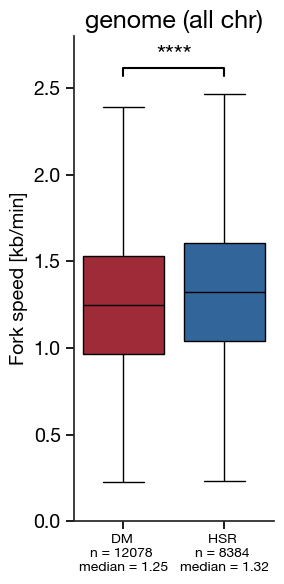

In [12]:
#------------------------------- hg38 -------------------------------
df_DM_hg38_chr['source'] = 'DM'
df_HSR_hg38_chr['source'] = 'HSR'

combined_df = pd.concat([df_DM_hg38_chr, df_HSR_hg38_chr])
t_stat, p_value = stats.ttest_ind(df_DM_hg38_chr['fork_speed'], df_HSR_hg38_chr['fork_speed'], equal_var=False) # equal variances false for Welch's t test

custom_order = ['DM', 'HSR']
pairs = [('DM', 'HSR')]

plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'fork_speed', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['red'], colors_dict['blue']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'fork_speed', order = custom_order, comparisons = pairs, test = 'ttest_ind', display='stars', bracket_offset=0.1, text_offset=0.001, bracket_height = 0.05)
# labels
group_stats = combined_df.groupby('source')['fork_speed'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylabel('Fork speed [kb/min]', size = 14)
plt.xlabel('')
plt.ylim(0, 2.8)
plt.title('genome (all chr)', size = 18)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_04/' + date + '_speed_boxplot_hg38' + '_HSR_vs_DM' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()

# write to file
header = '=====================hg38 (all chromosomes): DM vs HSR ===================== \n'
p_value_text = f" Two-sided Welch's t-test (unequal variances assumed): \nt-statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_04/{date}_boxplot_stats_speed.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)


### Figure 4c: Stall score DM vs HSR - hg38

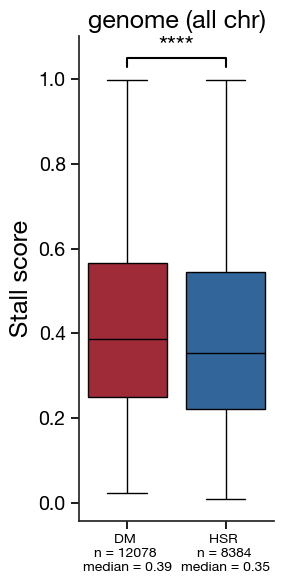

In [13]:
# ------------------------------- hg38 -------------------------------

# 01.2: boxplot
df_DM_hg38_chr['source'] = 'DM'
df_HSR_hg38_chr['source'] = 'HSR'

combined_df = pd.concat([df_DM_hg38_chr, df_HSR_hg38_chr])
t_stat, p_value = stats.ranksums(df_DM_hg38_chr['stall_score'], df_HSR_hg38_chr['stall_score'])

custom_order = ['DM', 'HSR']
pairs = [('DM', 'HSR')]

plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'stall_score', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['red'], colors_dict['blue']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'stall_score', order = custom_order, comparisons = pairs, test = 'ranksums', display='stars', bracket_offset=0.03, text_offset=0.001, bracket_height = 0.02)
# labels
group_stats = combined_df.groupby('source')['stall_score'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylabel('Stall score', size = 18)
plt.xlabel('')
plt.title('genome (all chr)', size = 18)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_04/' + date + '_stall_boxplot_hg38' + '_HSR_vs_DM' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()

# write to file
header = '=====================hg38: DM vs HSR ===================== \n'
p_value_text = f" Two-sided Wilcoxon rank-sum test (non-parametric test): \nrank-sum statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_04/{date}_boxplot_stats_stall.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWilcoxon rank-sum test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Figure 4e: Fork speed DM vs HSR - ecDNA

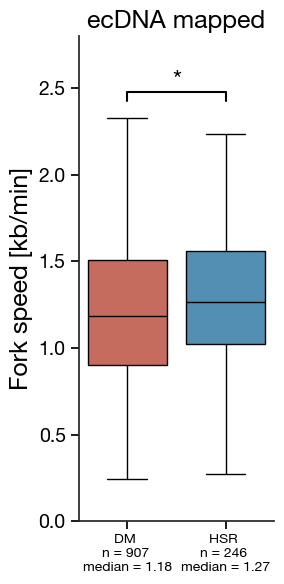

In [14]:
# ------------------------------- ecDNA -------------------------------

df_DM_ecDNA['source'] = 'DM'
df_HSR_ecDNA['source'] = 'HSR'

combined_df = pd.concat([df_DM_ecDNA, df_HSR_ecDNA])
t_stat, p_value = stats.ttest_ind(df_DM_ecDNA['fork_speed'], df_HSR_ecDNA['fork_speed'], equal_var=False) # equal variances false for Welch's t test

custom_order = ['DM', 'HSR']
pairs = [('DM', 'HSR')]

# 02.2: boxplot HSR vs DM
plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'fork_speed', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['red2'], colors_dict['blue2']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'fork_speed', order = custom_order, comparisons = pairs, test = 'ttest_ind', display='stars', bracket_offset=0.1, text_offset=0.001, bracket_height = 0.05)
# labels
group_stats = combined_df.groupby('source')['fork_speed'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylabel('Fork speed [kb/min]', size = 18)
plt.xlabel('')
plt.ylim(0, 2.8)
plt.title('ecDNA mapped', size = 18)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_04/' + date + '_speed_boxplot_ecDNA' + '_HSR_vs_DM' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# write to file
header = '=====================ecDNA mapped: DM vs HSR ===================== \n'
p_value_text = f" Two-sided Welch's t-test (unequal variances assumed): \nt-statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_04/{date}_boxplot_stats_speed.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Figure 4f: Stall score DM vs HSR - ecDNA

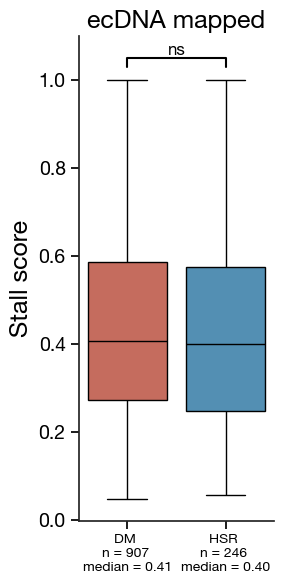

In [15]:
# ------------------------------- ecDNA -------------------------------

# 02.2: boxplot
df_DM_ecDNA['source'] = 'DM'
df_HSR_ecDNA['source'] = 'HSR'

combined_df = pd.concat([df_DM_ecDNA, df_HSR_ecDNA])
t_stat, p_value = stats.ranksums(df_DM_ecDNA['stall_score'], df_HSR_ecDNA['stall_score'])

custom_order = ['DM', 'HSR']
pairs = [('DM', 'HSR')]

# 02.2: boxplot HSR vs DM
plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'stall_score', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['red2'], colors_dict['blue2']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'stall_score', order = custom_order, comparisons = pairs, test = 'ranksums', display='stars', bracket_offset=0.03, text_offset=0.001, bracket_height = 0.02, star_fontsize = 12)
# labels
group_stats = combined_df.groupby('source')['stall_score'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylabel('Stall score', size = 18)
plt.xlabel('')
plt.title('ecDNA mapped', size = 18)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_04/' + date + '_stall_boxplot_ecDNA' + '_HSR_vs_DM' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# write to file
header = '=====================ecDNA mapped: DM vs HSR ===================== \n'
p_value_text = f" Two-sided Wilcoxon rank-sum test (non-parametric test): \nrank-sum statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_04/{date}_boxplot_stats_stall.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWilcoxon rank-sum test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Figure 4g: Fork speed DM - hg38 (excl. chr8) vs ecDNA

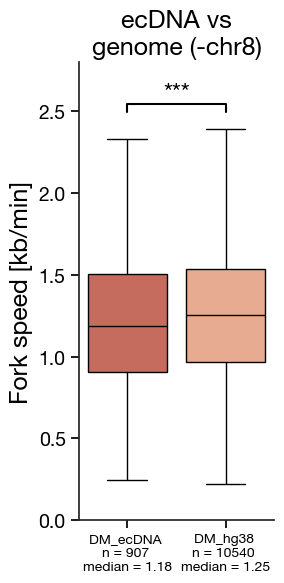

In [16]:
# ------------------------------- DM: hg38-chr8 vs ecDNA -------------------------------
df_DM_ecDNA['source'] = 'DM_ecDNA'
df_DM_hg38_chr8['source'] = 'DM_hg38'

combined_df = pd.concat([df_DM_ecDNA, df_DM_hg38_chr8])
t_stat, p_value = stats.ttest_ind(df_DM_ecDNA['fork_speed'], df_DM_hg38_chr8['fork_speed'], equal_var=False) # equal variances false for Welch's t test

custom_order = ['DM_ecDNA', 'DM_hg38']
pairs = [('DM_ecDNA', 'DM_hg38')]

plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'fork_speed', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['red2'], colors_dict['red3']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'fork_speed', order = custom_order, comparisons = pairs, test = 'ttest_ind', display='stars', bracket_offset=0.1, text_offset=0.001, bracket_height = 0.05)
# labels
group_stats = combined_df.groupby('source')['fork_speed'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylabel('Fork speed [kb/min]', size = 18)
plt.xlabel('')
plt.ylim(0, 2.8)
plt.title('ecDNA vs\ngenome (-chr8)', size = 18)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_04/' + date + '_speed_boxplot' + '_DM_ecDNA_vs_hg38' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()

# write to file
header = '=====================within DM: ecDNA vs hg38 (excl. chr8) ===================== \n'
p_value_text = f" Two-sided Welch's t-test (unequal variances assumed): \nt-statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_04/{date}_boxplot_stats_speed.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Figure 4h: Stall score DM - hg38 (excl. chr8) vs ecDNA

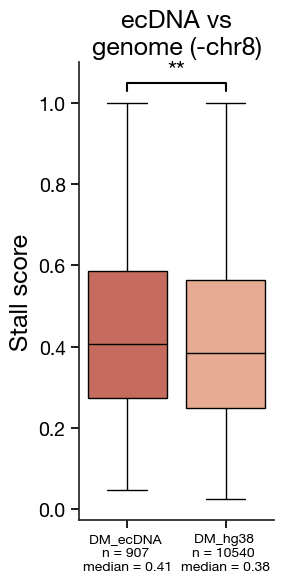

In [17]:
# ------------------------------- within DM: ecDNA vs hg38 (excl. chr8) -------------------------------

# 03.2: boxplot DM ecDNA vs DM chr
df_DM_ecDNA['source'] = 'DM_ecDNA'
df_DM_hg38_chr8['source'] = 'DM_hg38'

combined_df = pd.concat([df_DM_ecDNA, df_DM_hg38_chr8])
t_stat, p_value = stats.ranksums(df_DM_ecDNA['stall_score'], df_DM_hg38_chr8['stall_score'])

custom_order = ['DM_ecDNA', 'DM_hg38']
pairs = [('DM_ecDNA', 'DM_hg38')]

# 03.2: boxplot DM ecDNA vs DM chr
plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'stall_score', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['red2'], colors_dict['red3']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'stall_score', order = custom_order, comparisons = pairs, test = 'ranksums', display='stars', bracket_offset=0.03, text_offset=0.001, bracket_height = 0.02)
# labels
group_stats = combined_df.groupby('source')['stall_score'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylabel('Stall score', size = 18)
plt.xlabel('')
plt.title('ecDNA vs\ngenome (-chr8)', size = 18)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_04/' + date + '_stall_boxplot' + '_DM_ecDNA_vs_hg38' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# write to file
header = '=====================within DM: ecDNA vs hg38 (excl. chr8) ===================== \n'
p_value_text = f" Two-sided Wilcoxon rank-sum test (non-parametric test): \nrank-sum statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_04/{date}_boxplot_stats_stall.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWilcoxon rank-sum test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

## Fig 4 d - Dotplots fork speed median per chromosome

### Figure 4d: Fork speed median by chromosome - DM vs HSR

In [18]:
# setup
chromosome_order = ['ecDNA', 'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']

# colors
tab20 = sns.color_palette("tab20", 20)
set3 = sns.color_palette("Set3", 12)
bright_red = (1.0, 0.0, 0.0) 
combined_palette = [bright_red] + tab20[:6] + tab20[7:20] + set3[:4]

,chromosome,fork_speed,total_observations,source,chromosome_label
0,chr1,1.254437,859,DM,"chr1, DM = 859, HSR = 660"
1,chr10,1.298375,417,DM,"chr10, DM = 417, HSR = 367"
2,chr11,1.248604,456,DM,"chr11, DM = 456, HSR = 410"
3,chr12,1.192458,593,DM,"chr12, DM = 593, HSR = 493"
4,chr13,1.204729,671,DM,"chr13, DM = 671, HSR = 409"
5,chr14,1.274375,332,DM,"chr14, DM = 332, HSR = 213"
6,chr15,1.243604,216,DM,"chr15, DM = 216, HSR = 188"
7,chr16,1.219062,417,DM,"chr16, DM = 417, HSR = 266"
8,chr17,1.100375,285,DM,"chr17, DM = 285, HSR = 223"
9,chr18,1.250208,254,DM,"chr18, DM = 254, HSR = 179"


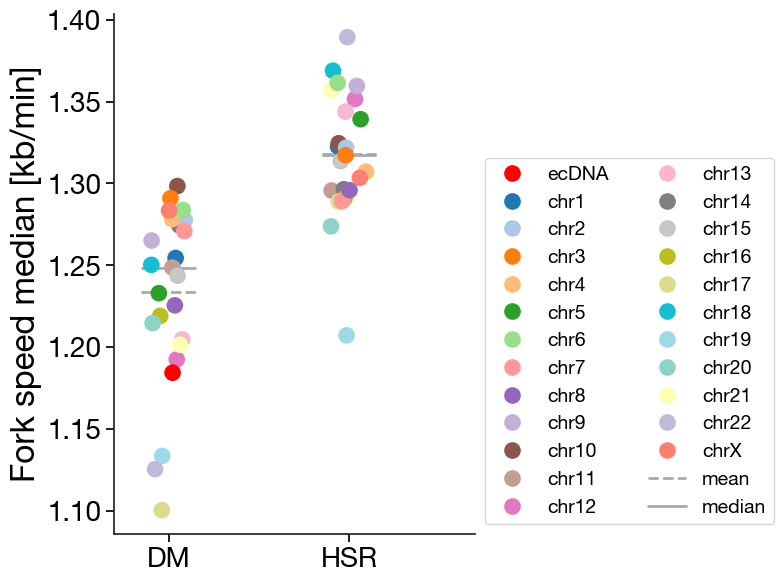

In [19]:
# 02: medians
# 01.1: data prep
mean_DM = df_DM_hg38_chr.groupby(['chromosome', 'dataset']).agg(fork_speed=('fork_speed', 'median'),observations=('fork_speed', 'count')).reset_index()
mean_HSR = df_HSR_hg38_chr.groupby(['chromosome', 'dataset']).agg(fork_speed=('fork_speed', 'median'),observations=('fork_speed', 'count')).reset_index()

# aggregate by 'chromosome' only to calculate the mean fork speed and sum the counts across datasets
mean_DM_agg = mean_DM.groupby('chromosome', as_index=False).agg(fork_speed=('fork_speed', 'median'), total_observations=('observations', 'sum'))
mean_HSR_agg = mean_HSR.groupby('chromosome', as_index=False).agg(fork_speed=('fork_speed', 'median'), total_observations=('observations', 'sum'))

mean_DM_agg['source'] = 'DM'
mean_HSR_agg['source'] = 'HSR'

#ecDNA
mean_DM_ecDNA = pd.DataFrame({
	'chromosome': ['ecDNA'], 
	'fork_speed': [df_DM_ecDNA['fork_speed'].median()],  # Calculate the median fork speed for ecDNA
	'total_observations': [len(df_DM_ecDNA)],  # Count the number of observations for ecDNA
	'source': ['DM']  # add cell line (set to DM)
})

# combine
combined_df = pd.concat([mean_DM_agg, mean_HSR_agg]) # for mean/median line excl ecDNA
combined_df_ecDNA = pd.concat([mean_DM_agg, mean_HSR_agg, mean_DM_ecDNA])

# labels
pivot_df = combined_df_ecDNA.pivot_table(index='chromosome', columns='source', values='total_observations', aggfunc='sum').reset_index()
pivot_df['chromosome_label'] = pivot_df.apply(lambda row: f"{row['chromosome']}, DM = {int(row['DM'] if not pd.isna(row['DM']) else 0)}, HSR = {int(row['HSR'] if not pd.isna(row['HSR']) else 0)}", axis=1)
combined_df_ecDNA = combined_df_ecDNA.merge(pivot_df[['chromosome', 'chromosome_label']], on='chromosome', how='left')


# stats
combined_df_ecDNA.to_csv(f'{outpath}/figure_04/{date}_dotplot_fork_speed_median_DM_HSR.csv')
display(combined_df_ecDNA)

# 02.2: plot

# 01.2: plot
plt.figure(figsize=(8, 6))

# invisible boxplot for mean/median line
sns.boxplot(data=combined_df, x='source', y='fork_speed', showmeans=True, 
			meanline=True, meanprops={'color': 'darkgrey', 'ls': '--', 'lw': 2}, 
			width=0.3, medianprops={'color': 'darkgrey', 'ls': '-', 'lw': 2}, 
			whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False)

# dot plot
stripplot = sns.stripplot(data=combined_df_ecDNA, x='source', y='fork_speed', 
						  hue='chromosome', hue_order=chromosome_order, 
						  palette=combined_palette, size=12)

handles, labels = plt.gca().get_legend_handles_labels()

# labels with counts
#label_map = {row['chromosome']: row['chromosome_label'] 
			 #for _, row in combined_df_ecDNA.drop_duplicates('chromosome').iterrows()}

# new labels with counts
#new_labels = [label_map.get(label, label) for label in labels]

# mean and median line in legend
mean_line = mlines.Line2D([], [], color='darkgrey', linestyle='--', linewidth=2, label='Mean')
median_line = mlines.Line2D([], [], color='darkgrey', linestyle='-', linewidth=2, label='Median')
handles.extend([mean_line, median_line])
labels.extend(['mean', 'median']) # new labels

# legend
plt.legend(handles=handles, labels=labels, title='', loc='lower left', bbox_to_anchor=(1, 0), fontsize=14, ncol=2)

# adjustments
plt.xlim(-0.3, 1.7)
plt.ylabel('Fork speed median [kb/min]', size=24)
plt.xlabel('')
plt.xticks(size=14)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

# save
plt.tight_layout()
plt.savefig(outpath + '/figure_04/' + date + '_chromosome_speed_dotplot_' + 'HSR_vs_DM_median' + '.pdf')
plt.show()
plt.close()

# save stats txt
stats_text = f'DM:\nmean = {combined_df[combined_df["source"] == "DM"]["fork_speed"].mean()};\n' + \
			f'median = {combined_df[combined_df["source"] == "DM"]["fork_speed"].median()}\n\n' + \
			f'HSR:\nmean = {combined_df[combined_df["source"] == "HSR"]["fork_speed"].mean()};\n' + \
			f'median = {combined_df[combined_df["source"] == "HSR"]["fork_speed"].median()}\n\n' +	\
			f'ecDNA:\nmedian = {combined_df_ecDNA[combined_df_ecDNA["chromosome"] == "ecDNA"]["fork_speed"].median()}'

with open(f'{outpath}/figure_04/{date}_dotplot_fork_speed_median_DM_HSR.txt', "w") as file:
	file.write(stats_text)


# Figure 5

### Figure 5a - Copy number variation HU treatment

- data from Jedrek

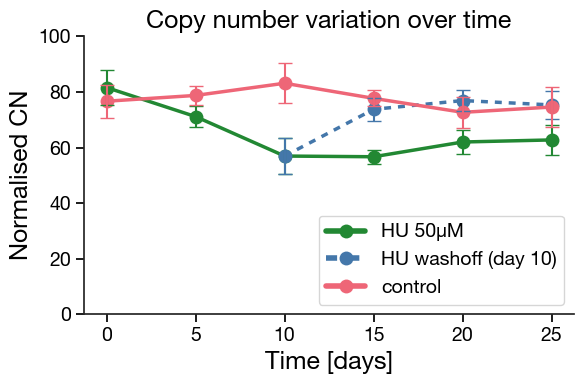

,Day,Group1,Group2,stat,p_value,mean_condition1,mean_condition2,stars
0,0,control,HU50,-1.120897,0.262332,76.648986,81.579938,ns
1,5,control,HU50,2.722179,0.006485,78.736162,71.123121,**
2,10,control,HU50,2.882307,0.003948,83.121397,56.924917,**
3,10,control,HU50W2,2.882307,0.003948,83.121397,56.924917,**
4,10,HU50,HU50W2,0.000000,1.000000,56.924917,56.924917,ns
5,15,control,HU50,2.882307,0.003948,77.684535,56.672273,**
6,15,control,HU50W2,1.601282,0.109315,77.684535,73.739098,ns
7,15,HU50,HU50W2,-2.882307,0.003948,56.672273,73.739098,**
8,20,control,HU50,2.642115,0.008239,72.654911,61.978381,**
9,20,control,HU50W2,-1.120897,0.262332,72.654911,76.890764,ns


In [20]:
# load the dataset
file_path = '/Users/pfuderer/Documents/PhD/data/Jedrek/hu50_PFP.csv'
df = pd.read_csv(file_path)

# rename the columns
df.columns = ['Days', 'control_1', 'control_2', 'control_3', 'control_4', 'control_5', 'control_6',
			  'HU50_1', 'HU50_2', 'HU50_3', 'HU50_4', 'HU50_5', 'HU50_6',
			  'HU50W2_1', 'HU50W2_2', 'HU50W2_3', 'HU50W2_4', 'HU50W2_5', 'HU50W2_6']

# convert to long format
df_long = pd.melt(df, id_vars=['Days'], 
				  value_vars=['control_1', 'control_2', 'control_3', 'control_4', 'control_5', 'control_6',
							  'HU50_1', 'HU50_2', 'HU50_3', 'HU50_4', 'HU50_5', 'HU50_6',
							  'HU50W2_1', 'HU50W2_2', 'HU50W2_3', 'HU50W2_4', 'HU50W2_5', 'HU50W2_6'],
				  var_name='Condition', value_name='Value')

# extract condition names (control, HU50, HU50_W2)
df_long['Group'] = df_long['Condition'].apply(lambda x: x.split('_')[0])

# group by condition and day, and calculate mean and standard deviation
df_grouped = (df_long.groupby(['Days', 'Group'])['Value'].agg(['mean', 'std']).reset_index())
df_grouped.columns = ['Days', 'Group', 'Mean', 'Std']

# re-name
group_names = {'control': 'control', 
			   'HU50': 'HU 50µM', 
			   'HU50W2': 'HU washoff (day 10)'}

df_grouped['Group'] = df_grouped['Group'].map(group_names)

# plotting
palette = sns.color_palette(['#228833', '#4477AA', '#EE6677'])
dash_styles = ['', (2, 2), '']

# line plot
plt.figure(figsize=(6, 4))
sns.lineplot(data=df_grouped, x='Days', y='Mean', hue='Group', style='Group',
			 marker='o', palette=palette, dashes=dash_styles, linewidth=2.5, markersize=10, markeredgewidth=0,
			 errorbar=None)

# error bars
for group in df_grouped['Group'].unique():
	group_data = df_grouped[df_grouped['Group'] == group]
	plt.errorbar(group_data['Days'], group_data['Mean'], yerr=group_data['Std'], 
				 fmt='none', capsize=5, color=palette[df_grouped['Group'].unique().tolist().index(group)])

plt.legend(framealpha = 0.3, title='', loc='lower right', )
legend = plt.legend(title='', loc='lower right', fontsize = 14)
for line in legend.get_lines():
	line.set_linewidth(4.0)
plt.xlabel('Time [days]', fontsize=18)
plt.ylabel('Normalised CN', fontsize=18)
plt.ylim(0, 100)
plt.title('Copy number variation over time', fontsize=18)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_05/' + date + '_copy_number_plot.pdf')
plt.show()
plt.close()


# stats
all_results = []

# loop through each day
for day in df_long['Days'].unique():
	# subset for that day
	day_data = df_long[df_long['Days'] == day].dropna(subset=['Value'])
	# get all conditions for that day
	conditions = day_data['Group'].unique()
	# all pair-wise comparisons
	cond_pairs = list(combinations(conditions, 2))
	# peroform stats test
	for c1, c2 in cond_pairs:
		c1_data = day_data.loc[day_data['Group'] == c1, 'Value'].dropna()
		c2_data = day_data.loc[day_data['Group'] == c2, 'Value'].dropna()
		# check conditions have data
		if not c1_data.empty and not c2_data.empty:
			stat, p_value = stats.ranksums(c1_data, c2_data, alternative='two-sided')
			all_results.append({
				'Day': day,
				'Group1': c1,
				'Group2': c2,
				'stat': stat,
				'p_value': p_value,
				'mean_condition1': c1_data.mean(),
				'mean_condition2': c2_data.mean()
			})

# list to df
df_comparisons = pd.DataFrame(all_results)
df_comparisons = df_comparisons[['Day', 'Group1', 'Group2', 'stat', 'p_value', 'mean_condition1', 'mean_condition2']]

# add stars
df_comparisons['stars'] = df_comparisons['p_value'].apply(lambda x: format_p_value(x))

# save csv
df_comparisons.to_csv(outpath + '/figure_05/' + date + '_copy_number_plot_pvalues.csv')

# display
display(df_comparisons)

## Figure 5 b, c, e, f, g, h - Boxplots fork speed and stall scores & 5 d - Dotplot

- Setup of output folders done with Figure 4

### Figure 5b: Fork speed DM vs DM-HU - hg38

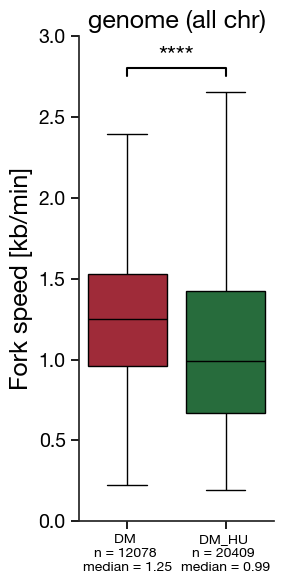

In [21]:
# ------------------------------- hg38 -------------------------------
df_DM_hg38_chr['source'] = 'DM'
df_DM_hg38_HU_chr['source'] = 'DM_HU'

# 01.2: violinplot DM vs DM-HU
combined_df = pd.concat([df_DM_hg38_chr, df_DM_hg38_HU_chr])
t_stat, p_value = stats.ttest_ind(df_DM_hg38_chr['fork_speed'], df_DM_hg38_HU_chr['fork_speed'], equal_var=False) # equal variances false for Welch's t test

custom_order = ['DM', 'DM_HU']
pairs = [('DM', 'DM_HU')]

# 01.2.2: boxplot DM vs DM-HU
plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'fork_speed', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['red'], colors_dict['green']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'fork_speed', order = custom_order, comparisons = pairs, test = 'ttest_ind', display='stars', bracket_offset=0.1, text_offset=0.001, bracket_height = 0.05)
# labels
group_stats = combined_df.groupby('source')['fork_speed'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylabel('Fork speed [kb/min]', size = 18)
plt.xlabel('')
plt.ylim(0, 3.0)
plt.title('genome (all chr)', size = 18)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_05/' + date + '_speed_boxplot_hg38' + '_DM_vs_DM_HU' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()

# write to file
header = '=====================hg38 (all chromosomes): DM vs DM-HU ===================== \n'
p_value_text = f"Two-sided Welch's t-test (unequal variances assumed): \nt-statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_05/{date}_boxplot_stats_speed.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Figure 5c: Stall score DM vs DM-HU - hg38

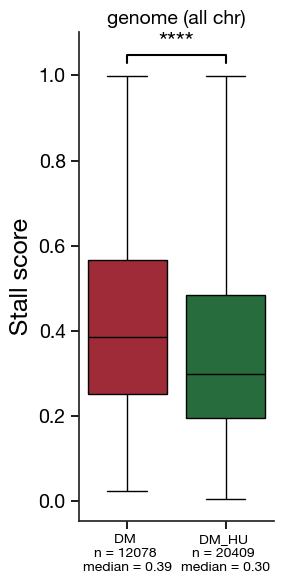

In [22]:
# ------------------------------- hg38 -------------------------------
df_DM_hg38_chr['source'] = 'DM'
df_DM_hg38_HU_chr['source'] = 'DM_HU'

combined_df = pd.concat([df_DM_hg38_chr, df_DM_hg38_HU_chr])
t_stat, p_value = stats.ranksums(df_DM_hg38_chr['stall_score'], df_DM_hg38_HU_chr['stall_score'])

custom_order = ['DM', 'DM_HU']
pairs = [('DM', 'DM_HU')]

# 01.2.2: boxplot DM vs DM-HU
plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'stall_score', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['red'], colors_dict['green']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'stall_score', order = custom_order, comparisons = pairs, test = 'ranksums', display='stars', bracket_offset=0.03, text_offset=0.001, bracket_height = 0.02)
# labels
group_stats = combined_df.groupby('source')['stall_score'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylabel('Stall score', size = 18)
plt.xlabel('')
plt.title('genome (all chr)', size = 14)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_05/' + date + '_stall_boxplot_hg38' + '_DM_vs_DM_HU' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()

# write to file
header = '=====================hg38: DM vs DM-HU ===================== \n'
p_value_text = f" Two-sided Wilcoxon rank-sum test (non-parametric test): \nrank-sum statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_05/{date}_boxplot_stats_stall.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWilcoxon rank-sum test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)
	

### Figure 5d: Fork speed median by chromosome - DM vs DM-HU

- Setup same as Figure 4d

,chromosome,fork_speed,total_observations,source,chromosome_label
0,chr1,1.254437,859,DM,"chr1, DM = 859, DM_HU = 1472"
1,chr10,1.298375,417,DM,"chr10, DM = 417, DM_HU = 677"
2,chr11,1.248604,456,DM,"chr11, DM = 456, DM_HU = 845"
3,chr12,1.192458,593,DM,"chr12, DM = 593, DM_HU = 1079"
4,chr13,1.204729,671,DM,"chr13, DM = 671, DM_HU = 1202"
5,chr14,1.274375,332,DM,"chr14, DM = 332, DM_HU = 565"
6,chr15,1.243604,216,DM,"chr15, DM = 216, DM_HU = 436"
7,chr16,1.219062,417,DM,"chr16, DM = 417, DM_HU = 699"
8,chr17,1.100375,285,DM,"chr17, DM = 285, DM_HU = 494"
9,chr18,1.250208,254,DM,"chr18, DM = 254, DM_HU = 435"


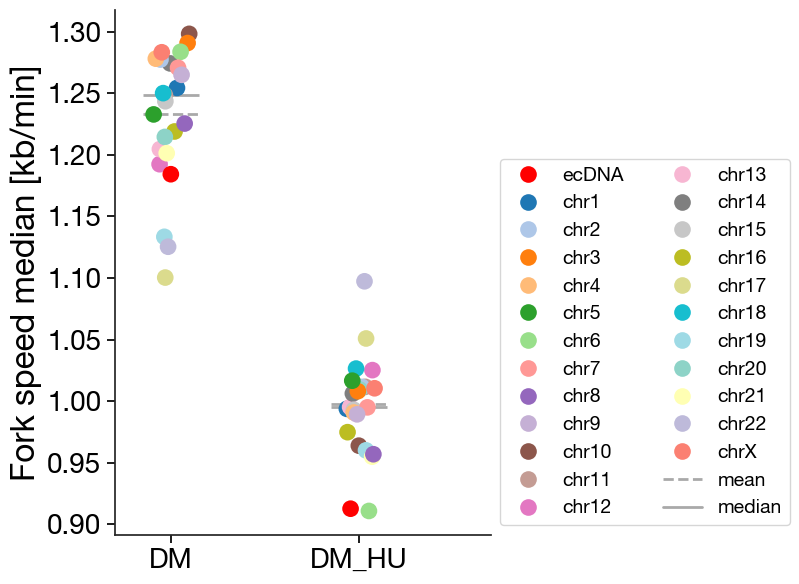

In [23]:
# 02: medians
# 01.1: data prep
mean_DM = df_DM_hg38_chr.groupby(['chromosome', 'dataset']).agg(fork_speed=('fork_speed', 'median'),observations=('fork_speed', 'count')).reset_index()
mean_DM_HU = df_DM_hg38_HU_chr.groupby(['chromosome', 'dataset']).agg(fork_speed=('fork_speed', 'median'),observations=('fork_speed', 'count')).reset_index()

# aggregate by 'chromosome' only to calculate the mean fork speed and sum the counts across datasets
mean_DM_agg = mean_DM.groupby('chromosome', as_index=False).agg(fork_speed=('fork_speed', 'median'), total_observations=('observations', 'sum'))
mean_DM_HU_agg = mean_DM_HU.groupby('chromosome', as_index=False).agg(fork_speed=('fork_speed', 'median'), total_observations=('observations', 'sum'))

mean_DM_agg['source'] = 'DM'
mean_DM_HU_agg['source'] = 'DM_HU'

#ecDNA
mean_DM_ecDNA = pd.DataFrame({
	'chromosome': ['ecDNA'], 
	'fork_speed': [df_DM_ecDNA['fork_speed'].median()],  # Calculate the mean fork speed for ecDNA
	'total_observations': [len(df_DM_ecDNA)],  # Count the number of observations for ecDNA
	'source': ['DM']  # add cell line (set to DM)
})

mean_DM_HU_ecDNA = pd.DataFrame({
	'chromosome': ['ecDNA'], 
	'fork_speed': [df_DM_ecDNA_HU['fork_speed'].median()],  # Calculate the mean fork speed for ecDNA
	'total_observations': [len(df_DM_ecDNA_HU)],  # Count the number of observations for ecDNA
	'source': ['DM_HU']  # add cell line (set to DM)
})
	

# combine
combined_df = pd.concat([mean_DM_agg, mean_DM_HU_agg]) # for mean/median line excl ecDNA
combined_df_ecDNA = pd.concat([mean_DM_agg, mean_DM_HU_agg, mean_DM_ecDNA, mean_DM_HU_ecDNA])

# labels
pivot_df = combined_df_ecDNA.pivot_table(index='chromosome', columns='source', values='total_observations', aggfunc='sum').reset_index()
pivot_df['chromosome_label'] = pivot_df.apply(lambda row: f"{row['chromosome']}, DM = {int(row['DM'] if not pd.isna(row['DM']) else 0)}, DM_HU = {int(row['DM_HU'] if not pd.isna(row['DM_HU']) else 0)}", axis=1)
combined_df_ecDNA = combined_df_ecDNA.merge(pivot_df[['chromosome', 'chromosome_label']], on='chromosome', how='left')


# stats
combined_df_ecDNA.to_csv(f'{outpath}/figure_05/{date}_dotplot_fork_speed_median_DM_DM-HU.csv')
display(combined_df_ecDNA)


# 01.2: plot
plt.figure(figsize=(8, 6))

# invisible boxplot for mean/median line
sns.boxplot(data=combined_df, x='source', y='fork_speed', showmeans=True, 
			meanline=True, meanprops={'color': 'darkgrey', 'ls': '--', 'lw': 2}, 
			width=0.3, medianprops={'color': 'darkgrey', 'ls': '-', 'lw': 2}, 
			whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False)

# dot plot
stripplot = sns.stripplot(data=combined_df_ecDNA, x='source', y='fork_speed', 
						  hue='chromosome', hue_order=chromosome_order, 
						  palette=combined_palette, size=12)

handles, labels = plt.gca().get_legend_handles_labels()

# labels with counts
#label_map = {row['chromosome']: row['chromosome_label'] 
#			 for _, row in combined_df_ecDNA.drop_duplicates('chromosome').iterrows()}

# new labels with counts
#new_labels = [label_map.get(label, label) for label in labels]

# mean and median line in legend
mean_line = mlines.Line2D([], [], color='darkgrey', linestyle='--', linewidth=2, label='Mean')
median_line = mlines.Line2D([], [], color='darkgrey', linestyle='-', linewidth=2, label='Median')
handles.extend([mean_line, median_line])
labels.extend(['mean', 'median'])

# legend
plt.legend(handles=handles, labels=labels, title='', loc='lower left', bbox_to_anchor=(1, 0), fontsize=14, ncol=2)

# adjustments
plt.xlim(-0.3, 1.7)
plt.ylabel('Fork speed median [kb/min]', size=24)
plt.xlabel('')
plt.xticks(size=14)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

# save
plt.tight_layout()
plt.savefig(outpath + '/figure_05/' + date + '_chromosome_speed_dotplot_' + 'HSR_vs_DM-HU_median' + '.pdf')
plt.show()
plt.close()


# save stats txt
stats_text = f'DM:\nmean = {combined_df[combined_df["source"] == "DM"]["fork_speed"].mean()};\n' + \
			f'median = {combined_df[combined_df["source"] == "DM"]["fork_speed"].median()}\n\n' + \
			f'DM_HU:\nmean = {combined_df[combined_df["source"] == "DM_HU"]["fork_speed"].mean()};\n' + \
			f'median = {combined_df[combined_df["source"] == "DM_HU"]["fork_speed"].median()}\n\n' +	\
			f'ecDNA DM:\nmedian = {combined_df_ecDNA[(combined_df_ecDNA["chromosome"] == "ecDNA") & (combined_df_ecDNA["source"] == "DM")]["fork_speed"].median()}\n' + \
			f'ecDNA DM_HU:\nmedian = {combined_df_ecDNA[(combined_df_ecDNA["chromosome"] == "ecDNA") & (combined_df_ecDNA["source"] == "DM_HU")]["fork_speed"].median()}'

with open(f'{outpath}/figure_05/{date}_chromosome_speed_dotplot_stats_DM_DMHU.txt', "w") as file:
	file.write(stats_text)
	

### Figure 5e: Fork speed  DM vs DM-HU - ecDNA

/var/folders/m1/snn0v3cj5x31vv4clrmnrch40000gn/T/ipykernel_863/2995865142.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


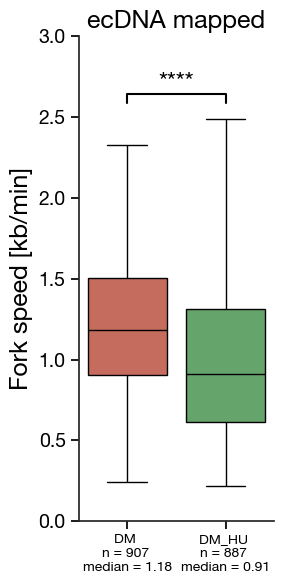

In [24]:
# ------------------------------- ecDNA -------------------------------

# 02.2: boxplot DM vs DM-HU
df_DM_ecDNA['source'] = 'DM'
df_DM_ecDNA_HU['source'] = 'DM_HU'

combined_df = pd.concat([df_DM_ecDNA, df_DM_ecDNA_HU])
t_stat, p_value = stats.ttest_ind(df_DM_ecDNA['fork_speed'], df_DM_ecDNA_HU['fork_speed'], equal_var=False) # equal variances false for Welch's t test

custom_order = ['DM', 'DM_HU']
pairs = [('DM', 'DM_HU')]

plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'fork_speed', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['red2'], colors_dict['green2']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'fork_speed', order = custom_order, comparisons = pairs, test = 'ttest_ind', display='stars', bracket_offset=0.1, text_offset=0.001, bracket_height = 0.05)
# labels
group_stats = combined_df.groupby('source')['fork_speed'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticklabels(new_labels)
plt.ylabel('Fork speed [kb/min]', size = 18)
plt.xlabel('')
plt.ylim(0, 3.0)
plt.title('ecDNA mapped', size = 18)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_05/' + date + '_speed_boxplot_ecDNA' + '_DM_vs_DM_HU' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()

# write to file
header = '=====================ecDNA mapped: DM vs DM-HU ===================== \n'
p_value_text = f" Two-sided Welch's t-test (unequal variances assumed): \nt-statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_05/{date}_boxplot_stats_speed.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Figure 5f: Stall score DM vs DM-HU - ecDNA

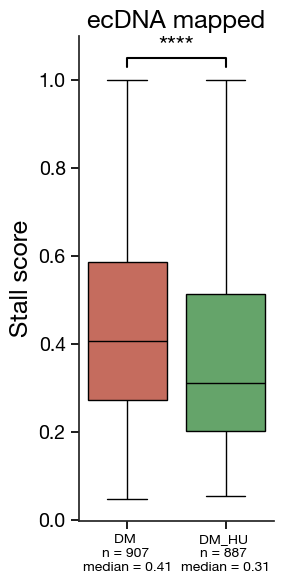

In [25]:
# ------------------------------- ecDNA -------------------------------
# 02.2: boxplot DM vs DM-HU
df_DM_ecDNA['source'] = 'DM'
df_DM_ecDNA_HU['source'] = 'DM_HU'

combined_df = pd.concat([df_DM_ecDNA, df_DM_ecDNA_HU])
t_stat, p_value = stats.ranksums(df_DM_ecDNA['stall_score'], df_DM_ecDNA_HU['stall_score'])

custom_order = ['DM', 'DM_HU']
pairs = [('DM', 'DM_HU')]

plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'stall_score', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['red2'], colors_dict['green2']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'stall_score', order = custom_order, comparisons = pairs, test = 'ranksums', display='stars', bracket_offset=0.03, text_offset=0.001, bracket_height = 0.02)
# labels
group_stats = combined_df.groupby('source')['stall_score'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylabel('Stall score', size = 18)
plt.xlabel('')
plt.title('ecDNA mapped', size = 18)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_05/' + date + '_stall_boxplot_ecDNA' + '_DM_vs_DM_HU' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()

# write to file
header = '=====================ecDNA mapped: DM vs DM-HU ===================== \n'
p_value_text = f" Two-sided Wilcoxon rank-sum test (non-parametric test): \nrank-sum statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_05/{date}_boxplot_stats_stall.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWilcoxon rank-sum test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Figure 5g: Fork speed DM - hg38 (excl. chr8) vs ecDNA

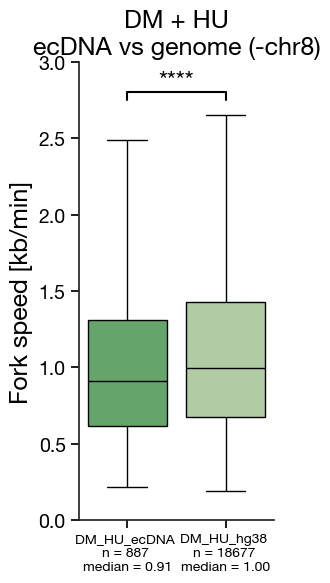

In [26]:
# ------------------------------- within DM-HU: ecDNA vs hg38 (excl. chr8) -------------------------------
# 04.2: boxplot DM HU ecDNA vs chr
df_DM_ecDNA_HU['source'] = 'DM_HU_ecDNA'
df_DM_hg38_HU_chr8['source'] = 'DM_HU_hg38'

combined_df = pd.concat([df_DM_ecDNA_HU, df_DM_hg38_HU_chr8])
t_stat, p_value = stats.ttest_ind(df_DM_ecDNA_HU['fork_speed'], df_DM_hg38_HU_chr8['fork_speed'], equal_var=False) # equal variances false for Welch's t test

custom_order = ['DM_HU_ecDNA', 'DM_HU_hg38']
pairs = [('DM_HU_ecDNA', 'DM_HU_hg38')]

plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'fork_speed', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['green2'], colors_dict['green3']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'fork_speed', order = custom_order, comparisons = pairs, test = 'ttest_ind', display='stars', bracket_offset=0.1, text_offset=0.001, bracket_height = 0.05)
# labels
group_stats = combined_df.groupby('source')['fork_speed'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylabel('Fork speed [kb/min]', size = 18)
plt.xlabel('')
plt.ylim(0, 3.0)
plt.title('DM + HU\necDNA vs genome (-chr8)', size = 18)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_05/' + date + '_speed_boxplot' + '_DM_HU_ecDNA_vs_hg38' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# write to file
header = '=====================within DM-HU: ecDNA vs hg38 (excl. chr8) ===================== \n'
p_value_text = f" Two-sided Welch's t-test (unequal variances assumed): \nt-statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_05/{date}_boxplot_stats_speed.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Figure 5h: Stall score DM - hg38 (excl. chr8) vs ecDNA

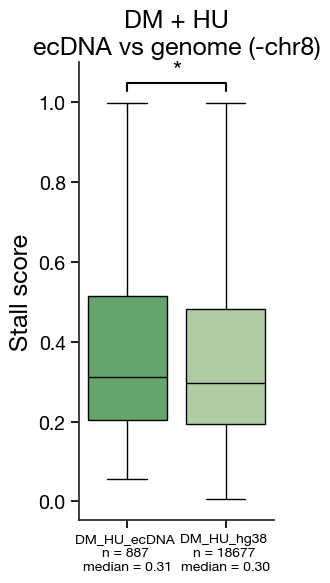

In [27]:
# ------------------------------- within DM HU: ecDNA vs hg38 (excl. chr8) -------------------------------
# 04.2: boxplot DM HU ecDNA vs chr
df_DM_ecDNA_HU['source'] = 'DM_HU_ecDNA'
df_DM_hg38_HU_chr8['source'] = 'DM_HU_hg38'

combined_df = pd.concat([df_DM_ecDNA_HU, df_DM_hg38_HU_chr8])
t_stat, p_value = stats.ranksums(df_DM_ecDNA_HU['stall_score'], df_DM_hg38_HU_chr8['stall_score'])

custom_order = ['DM_HU_ecDNA', 'DM_HU_hg38']
pairs = [('DM_HU_ecDNA', 'DM_HU_hg38')]

plt.figure(figsize = (3, 6))
ax = sns.boxplot(data = combined_df, y = 'stall_score', x = 'source', hue = 'source', order = custom_order, palette = [colors_dict['green2'], colors_dict['green3']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, combined_df, group_col = 'source', value_col = 'stall_score', order = custom_order, comparisons = pairs, test = 'ranksums', display='stars', bracket_offset=0.03, text_offset=0.001, bracket_height = 0.02)
# labels
group_stats = combined_df.groupby('source')['stall_score'].agg(['median', 'mean', 'count']).reset_index()
new_labels = [f"{row['source']} \nn = {row['count']} \nmedian = {row['median']:.2f}" for index, row in group_stats.iterrows()]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels)
plt.ylabel('Stall score', size = 18)
plt.xlabel('')
plt.title('DM + HU\necDNA vs genome (-chr8)', size = 18)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_05/' + date + '_stall_boxplot' + '_DM_HU_ecDNA_vs_hg38' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()

# write to file
header = '=====================within DM HU: ecDNA vs hg38 (excl. chr8) ===================== \n'
p_value_text = f"Two-sided Wilcoxon rank-sum test (non-parametric test): \nrank-sum statistic = {t_stat}, p-value = {p_value}\n"
annotator_stars = f'p-value annotation legend: \nns: 5.00e-02 < p <= 1.00e+00 \n*: 1.00e-02 < p <= 5.00e-02 \n**: 1.00e-03 < p <= 1.00e-02 \n***: 1.00e-04 < p <= 1.00e-03 \n****: p <= 1.00e-04'

with open(f'{outpath}/figure_05/{date}_boxplot_stats_stall.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(group_stats.to_string(index=False))
	file.write('\n\nWilcoxon rank-sum test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

# Supplementary Figure S3: GC content and G4 counts in ecDNA origins 

In [28]:
#------------------ 00 DATA ------------------

# 01: load the ecDNA reference
reference = {}
for record in SeqIO.parse('/Users/pfuderer/Documents/PhD/genomes/basic_ecDNAseq_indexfile_formatted.fasta', 'fasta'):
	reference[record.id] = record.seq

# 02: read in origin csv file
ori_DM = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20240503/20240503_directories_DM_ecDNA_origins.csv')
ori_DMHU = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20240503/20240503_directories_DM_ecDNA_HU_origins.csv')
ori_HSR = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20240503/20240503_directories_HSR_ecDNA_origins.csv')

ori_DM['type'] = 'DM_origins'
ori_DMHU['type'] = 'DM_HU_origins'
ori_HSR['type'] = 'HSR_origins'

# 03: combine
df_ori = pd.concat([ori_DM, ori_DMHU, ori_HSR])
df_ori.reset_index(drop=True, inplace=True)

# 04: only include origins on main chromosome stretch
df_ori = df_ori[df_ori['chromosome'] == 'chr8_126425747-127997820']

#------------------ 01 FUNCTION DEFINITION ------------------

# get GC content
def get_gc_content(sequence):
	count = Counter(sequence.upper())
	gc_count = count['G'] + count['C']
	total_bases = sum(count.values())
	return (gc_count / total_bases) * 100 if total_bases > 0 else 0

# function to check overlap with origin region
def is_overlap(region_start, region_end, origin_intervals):
	for start, end in origin_intervals:
		if not (region_end <= start or region_start >= end):
			return True
	return False

def count_g4s_in_origins(row, g4_position):
	return ((g4_position["chromosome"] == row["chromosome"]) & 
		(g4_position["start"] >= row["start"]) & 
		(g4_position["end"] <= row["end"])).sum()

#------------------ 02 GC CONTENT ORIS ------------------

# get GC content for each origin 1kb region
for index, row in df_ori.iterrows():
	chromosome = row['chromosome']
	midpoint = int((row['ori_lb'] + row['ori_ub']) / 2)
	start = max(midpoint - 500, 0)  # start is at least 0
	end = min(midpoint + 500, len(reference[chromosome]))  # don't exceed chromosome length
	# get the sequence from the reference
	if chromosome in reference:
		sequence = reference[chromosome][start:end]
		gc_content = get_gc_content(sequence)
	else:
		gc_content = None  # if chromosome not found
	# assign values to the df
	df_ori.at[index, 'midpoint'] = int(midpoint)
	df_ori.at[index, 'start_500'] = int(start)
	df_ori.at[index, 'end_500'] = int(end)
	df_ori.at[index, 'gc_content'] = gc_content

#------------------ 03 GC CONTENT RANDOM REGIONS ------------------

# 01: initialize variables
chromosome = 'chr8_126425747-127997820'
chrom_length = len(reference[chromosome])  # length of the chromosome sequence

# 02: get all origin intervals for the single chromosome
origin_intervals = df_ori[['start_500', 'end_500']].to_numpy()

# 03: random sampling of non-overlapping regions
random_regions = []
sampled_regions = 0
attempts = 0  # limit the number of attempts to avoid infinite loops

# 04: set seed for reproducibility
random.seed(42)

# 05: sample 100 regions
while sampled_regions < 100 and attempts < 1000:
	attempts += 1
	# randomly generate a start position
	random_start = random.randint(0, chrom_length - 1000)
	random_end = random_start + 1000
	# check if the region overlaps with any origin
	if not is_overlap(random_start, random_end, origin_intervals):
		# calculate GC content for the region
		sequence = reference[chromosome][random_start:random_end]
		gc_content = get_gc_content(sequence)
		# store the region information
		random_regions.append({
			'chromosome': chromosome,
			'start': random_start,
			'end': random_end,
			'gc_content': gc_content
		})
		sampled_regions += 1

# 06: convert to a df for analysis
df_random_regions = pd.DataFrame(random_regions)
df_random_regions['type'] = 'random_region'

#------------------ 04 G4 ------------------

# read in G4 scores
file_path = "/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20240529_G4Hunter/Results_basic_ecDNAseq_indexfile_formatted/basic_ecDNAseq_indexfile_formatted-W25-S1.0.txt"
with open(file_path, "r") as file:
	lines = file.readlines()

# loop through all lines
results = []
chromosome = None

for line in lines:
	line = line.strip()
	if line.startswith(">"):
		chromosome = line[1:]
	elif line and line[0].isdigit():
		fields = line.split()
		result = {
			"chromosome": chromosome,
			"start": int(fields[0]),
			"end": int(fields[1]),
			"SCORE": float(fields[4])
		}
		results.append(result)

#  combine into one DataFrame
g4hunter_df = pd.DataFrame(results)

# filter for G4 scores >= 1.5
g4hunter_filtered_df = g4hunter_df[g4hunter_df["SCORE"] >= 1.5]
g4hunter_filtered_df.to_csv(f'{outpath}/figure_supp_03/{date}_g4hunter_filtered.csv', index=False)

### Supplementary Figugre S3a: GC content in ecDNA origins

/var/folders/m1/snn0v3cj5x31vv4clrmnrch40000gn/T/ipykernel_863/1156365751.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.swarmplot(data=df_gc, y='gc_content', x='type', palette=colors_ori, size = 7, order = custom_order)


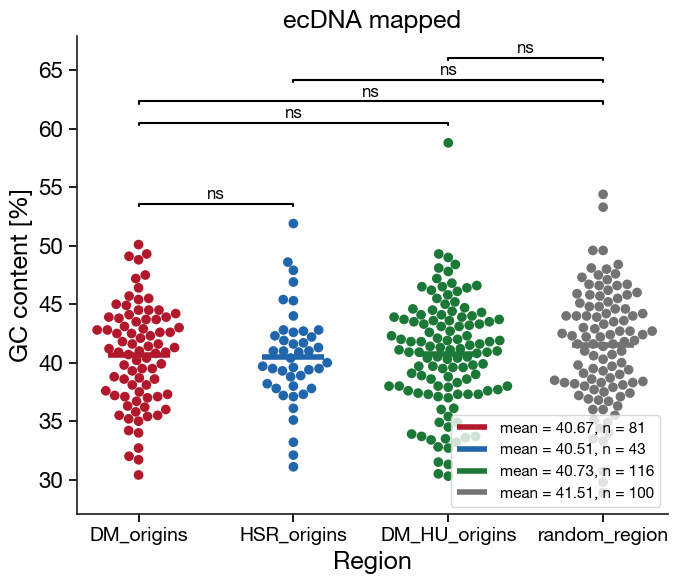

,group1,group2,statistic,p_value,median_group1,median_group2,mean_group1,mean_group2
0,DM_origins,DM_HU_origins,-0.088890,0.929169,41.00,41.05,40.672840,40.731034
1,DM_origins,HSR_origins,0.430500,0.666832,41.00,40.40,40.672840,40.509302
2,DM_origins,random_region,-1.266763,0.205240,41.00,41.85,40.672840,41.505000
3,DM_HU_origins,HSR_origins,0.589401,0.555592,41.05,40.40,40.731034,40.509302
4,DM_HU_origins,random_region,-1.272918,0.203047,41.05,41.85,40.731034,41.505000
5,HSR_origins,random_region,-1.362498,0.173041,40.40,41.85,40.509302,41.505000


type
DM_HU_origins    116
random_region    100
DM_origins        81
HSR_origins       43
Name: count, dtype: int64

In [29]:
#------------------ 05 PLOT GC ------------------
df_ori.to_csv(f'{outpath}/figure_supp_03/{date}_origins_all.csv', index=False)
# 01: columns for merging
df_ori_subset = df_ori[['chromosome', 'start_500', 'end_500', 'gc_content', 'type']]
df_random_regions_subset = df_random_regions[['chromosome', 'start', 'end', 'gc_content', 'type']]
df_ori_subset = df_ori_subset.rename(columns={'start_500': 'start', 'end_500': 'end'})

df_gc = pd.concat([df_ori_subset, df_random_regions_subset], ignore_index=True)

# 02: colors
colors_ori =  [colors_dict['red'], colors_dict['blue'], colors_dict['green'], '#737373']

# 03: get mean and n for each group
custom_order = ['DM_origins', 'HSR_origins', 'DM_HU_origins', 'random_region']
group_stats = df_gc.groupby('type')['gc_content'].agg(['mean', 'count'])
group_stats.index = pd.Categorical(group_stats.index, categories = custom_order, ordered = True)
group_stats = group_stats.sort_index()

# 04: plot
pairs = [('DM_origins', 'HSR_origins'), ('DM_origins', 'DM_HU_origins'), ('DM_origins', 'random_region'), ('HSR_origins', 'random_region'), ('DM_HU_origins', 'random_region')]

plt.figure(figsize=(7, 6))
ax = sns.swarmplot(data=df_gc, y='gc_content', x='type', palette=colors_ori, size = 7, order = custom_order)
# p-value annotations
annotate_p_values(ax, df_gc, group_col = 'type', value_col = 'gc_content', order = custom_order, comparisons = pairs, test = 'ranksums', display='stars', bracket_offset=1.5, text_offset=0.15, star_fontsize=12)
#  mean lines with matching colors and dynamic labels
for i, row in enumerate(group_stats.itertuples()):
	group = row.Index
	mean = row.mean
	n = row.count 
	# calculate the xmin and xmax for each group based on the group's x-axis position
	xmin = i - 0.2
	xmax = i + 0.2
	ax.hlines(mean, xmin=xmin, xmax=xmax, color=colors_ori[i], linestyle='-', linewidth=4, label=f'mean = {mean:.2f}, n = {n}')
plt.title('ecDNA mapped', size = 18)
ax.legend(loc='lower right', fontsize = 11)
plt.xlabel('Region', size = 18)
plt.ylabel('GC content [%]', fontsize = 18)
#plt.title('Ratio ecDNA to hg38 reads', fontsize = 18)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=16) 
plt.tight_layout()
plt.savefig(f'{outpath}/figure_supp_03/{date}_gc_content_origins.pdf')
plt.show()
plt.close()

# save to csv
df_gc.to_csv(f'{outpath}/figure_supp_03/{date}_df_gc_content_origins.csv', index = False)

# stats
groups = df_gc['type'].unique()

# pair-wise group comparisons
group_pairs = list(combinations(groups, 2))

# get pair-wise stats
comparison_results = []
for g1, g2 in group_pairs:
	data_g1 = df_gc.loc[df_gc['type'] == g1, 'gc_content']
	data_g2 = df_gc.loc[df_gc['type'] == g2, 'gc_content']
	stat, p_val = stats.ranksums(data_g1, data_g2, alternative='two-sided')
	comparison_results.append({
		'group1': g1,
		'group2': g2,
		'statistic': stat,
		'p_value': p_val,
		'median_group1': data_g1.median(),
		'median_group2': data_g2.median(),
		'mean_group1': data_g1.mean(),
		'mean_group2': data_g2.mean()
	})

# list to df
df_pairwise_comparisons = pd.DataFrame(comparison_results)

# save and display
df_pairwise_comparisons.to_csv(f'{outpath}/figure_supp_03/{date}_df_gc_content_origins_pvalues.csv', index = False)
display(df_pairwise_comparisons)

# summary how many rows
display(df_gc['type'].value_counts())


### Supplementary Figure S3b: G4 counts in ecDNA origins

,chromosome,start,end,gc_content,type,G4
2,chr8_126425747-127997820,380473.0,381473.0,30.4,DM_origins,20.0
10,chr8_126425747-127997820,917391.0,918391.0,38.1,DM_origins,15.0
15,chr8_126425747-127997820,1097270.0,1098270.0,48.8,DM_origins,25.0
21,chr8_126425747-127997820,1353392.0,1354392.0,38.7,DM_origins,18.0
23,chr8_126425747-127997820,266003.0,267003.0,44.9,DM_origins,17.0
30,chr8_126425747-127997820,685381.0,686381.0,37.2,DM_origins,26.0
33,chr8_126425747-127997820,758120.0,759120.0,40.2,DM_origins,28.0
51,chr8_126425747-127997820,1533197.0,1534197.0,50.1,DM_origins,20.0
52,chr8_126425747-127997820,51134.0,52134.0,42.1,DM_origins,6.0
53,chr8_126425747-127997820,204047.0,205047.0,42.8,DM_origins,4.0


/var/folders/m1/snn0v3cj5x31vv4clrmnrch40000gn/T/ipykernel_863/203096042.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.swarmplot(data=df_g4, y='G4', x='type', palette=colors_ori, size = 7, order = custom_order)
/Users/pfuderer/Documents/PhD/env/env_ecDNA/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 69.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/pfuderer/Documents/PhD/env/env_ecDNA/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 55.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/pfuderer/Documents/PhD/env/env_ecDNA/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 74.1% of th

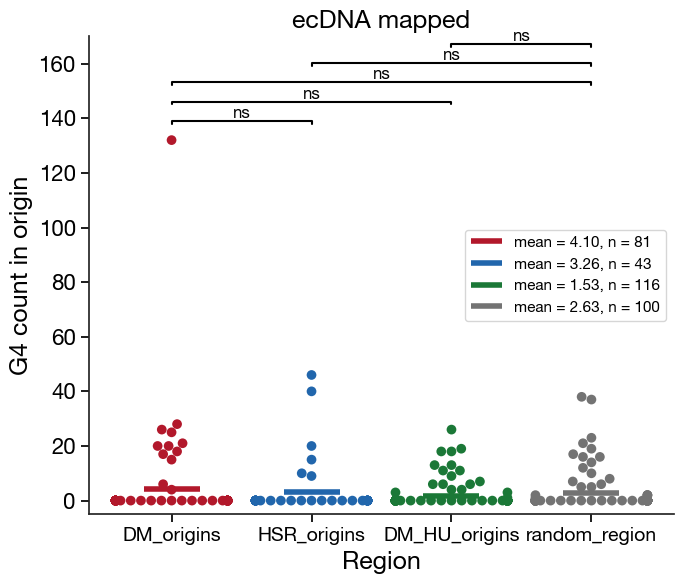

                     G4
type                   
DM_HU_origins  1.534483
DM_origins     4.098765
HSR_origins    3.255814
random_region  2.630000


In [30]:
#------------------ 05 PLOT G4 ------------------

# add G4 count >= 2.0 threshold for each ori
df_g4 = df_gc.copy()
for index, row in df_g4.iterrows():
	df_g4.at[index, "G4"] = count_g4s_in_origins(row, g4hunter_filtered_df)

display(df_g4[df_g4['G4'] > 0])


# 02: colors
colors_ori =  [colors_dict['red'], colors_dict['blue'], colors_dict['green'], '#737373']

# 03: get mean and n for each group
group_stats = df_g4.groupby('type')['G4'].agg(['mean', 'count'])
group_stats.index = pd.Categorical(group_stats.index, categories = custom_order, ordered = True)
group_stats = group_stats.sort_index()

# 04: plot
custom_order = ['DM_origins', 'HSR_origins', 'DM_HU_origins', 'random_region']
pairs = [('DM_origins', 'HSR_origins'), ('DM_origins', 'DM_HU_origins'), ('DM_origins', 'random_region'), ('HSR_origins', 'random_region'), ('DM_HU_origins', 'random_region')]

plt.figure(figsize=(7, 6))
ax = sns.swarmplot(data=df_g4, y='G4', x='type', palette=colors_ori, size = 7, order = custom_order)
# p-value annotations
annotate_p_values(ax, df_g4, group_col = 'type', value_col = 'G4', order = custom_order, comparisons = pairs, test = 'ranksums', display='stars', bracket_offset=6, text_offset=0.05, bracket_height=1, star_fontsize=12)
#  mean lines with matching colors and dynamic labels
for i, row in enumerate(group_stats.itertuples()):
	group = row.Index
	mean = row.mean
	n = row.count 
	# calculate the xmin and xmax for each group based on the group's x-axis position
	xmin = i - 0.2
	xmax = i + 0.2
	ax.hlines(mean, xmin=xmin, xmax=xmax, color=colors_ori[i], linestyle='-', linewidth=4, label=f'mean = {mean:.2f}, n = {n}')
plt.ylim (-5, 170)
plt.title('ecDNA mapped', size = 18)
ax.legend(loc='best', fontsize = 11)
plt.xlabel('Region', size = 18)
plt.ylabel('G4 count in origin', fontsize = 18)
#plt.title('Ratio ecDNA to hg38 reads', fontsize = 18)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=16) 
plt.tight_layout()
plt.savefig(f'{outpath}/figure_supp_03/{date}_G4_origins.pdf')
plt.show()
plt.close()

# save to csv
df_g4.to_csv(f'{outpath}/figure_supp_03/{date}_G4_content_origins.csv', index = False)

# stats
groups = df_g4['type'].unique()

# pair-wise group comparisons
group_pairs = list(combinations(groups, 2))

# get pair-wise stats
comparison_results = []
for g1, g2 in group_pairs:
	data_g1 = df_g4.loc[df_g4['type'] == g1, 'G4']
	data_g2 = df_g4.loc[df_g4['type'] == g2, 'G4']
	stat, p_val = stats.ranksums(data_g1, data_g2, alternative='two-sided')
	comparison_results.append({
		'group1': g1,
		'group2': g2,
		'statistic': stat,
		'p_value': p_val,
		'median_group1': data_g1.median(),
		'median_group2': data_g2.median(),
		'mean_group1': data_g1.mean(),
		'mean_group2': data_g2.mean()
	})

# list to df
df_pairwise_comparisons = pd.DataFrame(comparison_results)

# save and display
df_pairwise_comparisons.to_csv(f'{outpath}/figure_supp_03/{date}_G4_content_origins_pvalues.csv', index = False)

# summary how many rows
#display(df_g4['type'].value_counts())
print(df_g4.groupby('type').agg({'G4': 'mean'}))

# Supplementary Figure S4: Origin firing ecDNA or genome

- using output of `01_DNAscent_csv/coverage_bam_ecDNA.py` for ecDNA or for whole genome`01_DNAscent_csv/coverage_bam_hg38.py`

### Read in origin & coverage data

In [31]:
#--------------------------- ecDNA ---------------------------

# read in coverage data (aligned read length in bp)
bam_DM = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/202410017_bam_coverage/202410017_DM_ecDNA_coverage_bam_filtered.csv')
bam_DMHU = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/202410017_bam_coverage/202410017_DM_HU_ecDNA_coverage_bam_filtered.csv')
bam_HSR = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/202410017_bam_coverage/202410017_HSR_ecDNA_coverage_bam_filtered.csv')

# aggregate by dataset
df_DM = bam_DM.groupby(['dataset_name']).agg({'aligned_read_length': 'sum'}).reset_index()
df_DMHU = bam_DMHU.groupby(['dataset_name']).agg({'aligned_read_length': 'sum'}).reset_index()
df_HSR = bam_HSR.groupby(['dataset_name']).agg({'aligned_read_length': 'sum'}).reset_index()

# add cell line column
df_DM['cell_line'] = 'DM'
df_DMHU['cell_line'] = 'DM_HU'
df_HSR['cell_line'] = 'HSR'

# concatenate
df = pd.concat([df_DM, df_DMHU, df_HSR])
df.rename(columns={'dataset_name': 'dataset'}, inplace=True)

# read in origin counts
ori_DM = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20240503/20240503_directories_DM_ecDNA_origins.csv')
ori_DMHU = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20240503/20240503_directories_DM_ecDNA_HU_origins.csv')
ori_HSR = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20240503/20240503_directories_HSR_ecDNA_origins.csv')

# aggregate by dataset
df_ori_DM = ori_DM.groupby('dataset').size().reset_index(name='ori_count')
df_ori_DMHU = ori_DMHU.groupby('dataset').size().reset_index(name='ori_count')
df_ori_HSR = ori_HSR.groupby('dataset').size().reset_index(name='ori_count')

# concatenate
df_ori = pd.concat([df_ori_DM, df_ori_DMHU, df_ori_HSR])

# combine coverage and origin counts
df_ori_combined = df.merge(df_ori, on=['dataset'], how='outer')

# origins per sequenced mb
df_ori_combined['ori_per_mb'] = df_ori_combined['ori_count'] / (df_ori_combined['aligned_read_length'] / 1000000)
#df_ori_combined.to_csv(f'{outpath}/figure_supp_04/{date}_origins_per_mb.csv', index=False)
print('ecDNA: origins per sequenced mb:')
display(df_ori_combined)

#--------------------------- hg38 ---------------------------

# read in coverage data (aligned read length in bp)
bam_DM_hg38 = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20250218_bam_coverage_hg38/20250218_DM_ecDNA_coverage_bam_filtered_hg38.csv')
bam_DMHU_hg38 = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20250218_bam_coverage_hg38/20250218_DM_HU_ecDNA_coverage_bam_filtered_hg38.csv')
bam_HSR_hg38 = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20250218_bam_coverage_hg38/20250218_HSR_ecDNA_coverage_bam_filtered_hg38.csv')

# remove chr8, chrY
bam_DM_hg38 = convert_chromosome_names(bam_DM_hg38)
bam_DMHU_hg38 = convert_chromosome_names(bam_DMHU_hg38)
bam_HSR_hg38 = convert_chromosome_names(bam_HSR_hg38)

bam_DM_hg38 = bam_DM_hg38[~bam_DM_hg38['chromosome'].isin(['chr8', 'chrY'])]
bam_DMHU_hg38 = bam_DMHU_hg38[~bam_DMHU_hg38['chromosome'].isin(['chr8', 'chrY'])]
bam_HSR_hg38 = bam_HSR_hg38[~bam_HSR_hg38['chromosome'].isin(['chr8', 'chrY'])]

# aggregate by dataset
df_DM_hg38 = bam_DM_hg38.groupby(['dataset_name']).agg({'aligned_read_length': 'sum'}).reset_index()
df_DMHU_hg38 = bam_DMHU_hg38.groupby(['dataset_name']).agg({'aligned_read_length': 'sum'}).reset_index()
df_HSR_hg38 = bam_HSR_hg38.groupby(['dataset_name']).agg({'aligned_read_length': 'sum'}).reset_index()

# add cell line column
df_DM_hg38['cell_line'] = 'DM'
df_DMHU_hg38['cell_line'] = 'DM_HU'
df_HSR_hg38['cell_line'] = 'HSR'

# concatenate
df_hg38 = pd.concat([df_DM_hg38, df_DMHU_hg38, df_HSR_hg38])
df_hg38.rename(columns={'dataset_name': 'dataset'}, inplace=True)

# read in origin counts
ori_DM_hg38 = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20240503/20240503_directories_DM_hg38_origins.csv')
ori_DMHU_hg38 = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20240503/20240503_directories_DM_hg38_HU_origins.csv')
ori_HSR_hg38 = pd.read_csv('/Users/pfuderer/Documents/PhD/output/DNAscent/Jedrek_csv/20240503/20240503_directories_HSR_hg38_origins.csv')

# remove chr8, chrY
ori_DM_hg38 = convert_chromosome_names(ori_DM_hg38)
ori_DMHU_hg38 = convert_chromosome_names(ori_DMHU_hg38)
ori_HSR_hg38 = convert_chromosome_names(ori_HSR_hg38)

ori_DM_hg38 = ori_DM_hg38[~ori_DM_hg38['chromosome'].isin(['chr8', 'chrY'])]
ori_DMHU_hg38 = ori_DMHU_hg38[~ori_DMHU_hg38['chromosome'].isin(['chr8', 'chrY'])]
ori_HSR_hg38 = ori_HSR_hg38[~ori_HSR_hg38['chromosome'].isin(['chr8', 'chrY'])]

# aggregate by dataset
df_ori_DM_hg38 = ori_DM_hg38.groupby('dataset').size().reset_index(name='ori_count')
df_ori_DMHU_hg38 = ori_DMHU_hg38.groupby('dataset').size().reset_index(name='ori_count')
df_ori_HSR_hg38 = ori_HSR_hg38.groupby('dataset').size().reset_index(name='ori_count')

# concatenate
df_ori_hg38 = pd.concat([df_ori_DM_hg38, df_ori_DMHU_hg38, df_ori_HSR_hg38])

# combine coverage and origin counts
df_ori_combined_hg38 = df_hg38.merge(df_ori_hg38, on=['dataset'], how='outer')

# origins per sequenced mb
df_ori_combined_hg38['ori_per_mb'] = df_ori_combined_hg38['ori_count'] / (df_ori_combined_hg38['aligned_read_length'] / 1000000)
#df_ori_combined_hg38.to_csv(f'{outpath}/figure_supp_04/{date}_origins_per_mb_hg38.csv', index=False)
print('hg38: origins per sequenced mb:')
display(df_ori_combined_hg38)

#--------------------------- per bin coverage ---------------------------

# get origin midpoint
ori_DM['midpoint'] = np.ceil((ori_DM['ori_lb'] + ori_DM['ori_ub']) / 2).astype(int)
ori_HSR['midpoint'] = np.ceil((ori_HSR['ori_lb'] + ori_HSR['ori_ub']) / 2).astype(int)
ori_DMHU['midpoint'] = np.ceil((ori_DMHU['ori_lb'] + ori_DMHU['ori_ub']) / 2).astype(int)

# filter for longest chromosome bit (to stay in line with plotting in circlize and stats comparisons of DNAscent fork dynamics)
# NOTE: all origins are anyways mapped to 'chr8_126425747-127997820', so not necessary to filter

# HSR deletion region
HSR_region_start = 579253+1
HSR_region_end = 1318253-1
df_HSR_HSR = ori_HSR[(ori_HSR['midpoint'] >= HSR_region_start) & (ori_HSR['midpoint'] <= HSR_region_end)]
ori_DM_HSR = ori_DM[(ori_DM['midpoint'] >= HSR_region_start) & (ori_DM['midpoint'] <= HSR_region_end)]


# create bins
bin_size = 50000

# bins DM + DM_HU
region_end = max(bam_DM['end_position'].max(), bam_DMHU['end_position'].max())
bins = np.arange(0, region_end + bin_size, bin_size)

# bins DM + HSR
bins_HSR = np.arange(HSR_region_start, min(HSR_region_end + bin_size, HSR_region_end), bin_size)

# coverage
# coverage for DM and DM_HU
coverage_DM = compute_coverage(bam_DM, bins)
coverage_DMHU = compute_coverage(bam_DMHU, bins)
coverage_DM_HSR = compute_coverage(bam_DM, bins_HSR)
coverage_HSR = compute_coverage(bam_HSR, bins_HSR)

# create df for DM-DMHU and DM-HSR comparison
coverage_df = pd.DataFrame({
	'bin_start': bins[:-1],
	'bin_end': bins[1:],
	'coverage_dm': coverage_DM,
	'coverage_dm_hu': coverage_DMHU})

coverage_df_HSR = pd.DataFrame({
	'bin_start': bins_HSR[:-1],
	'bin_end': bins_HSR[1:],
	'coverage_dm': coverage_DM_HSR,
	'coverage_hsr': coverage_HSR})

# mean and median read depth
mean_read_depth_dm = np.mean(coverage_DM)
mean_read_depth_dm_hu = np.mean(coverage_DMHU)
mean_read_depth_dm_hsr = np.mean(coverage_DM_HSR)
mean_read_depth_hsr = np.mean(coverage_HSR)
median_read_depth_dm = np.median(coverage_DM)
median_read_depth_dm_hu = np.median(coverage_DMHU)
median_read_depth_dm_hsr = np.median(coverage_DM_HSR)
median_read_depth_hsr = np.median(coverage_HSR)

#--------------------------- per bin origins and coverage ---------------------------

# make copies
df_bins_with_counts = coverage_df.copy()
df_bins_with_counts_HSR = coverage_df_HSR.copy()

# get origins per bin
df_bins_with_counts['origin_count_dm'] = count_origins_per_bin(ori_DM, df_bins_with_counts)
df_bins_with_counts['origin_count_dm_hu'] = count_origins_per_bin(ori_DMHU, df_bins_with_counts)
df_bins_with_counts_HSR['origin_count_dm'] = count_origins_per_bin(ori_DM_HSR, df_bins_with_counts_HSR)
df_bins_with_counts_HSR['origin_count_hsr'] = count_origins_per_bin(ori_HSR, df_bins_with_counts_HSR)

print(f'DM vs DM-HU \n')
display(df_bins_with_counts)

print(f'\n DM vs HSR \n')
display(df_bins_with_counts_HSR)


ecDNA: origins per sequenced mb:


,dataset,aligned_read_length,cell_line,ori_count,ori_per_mb
0,20230404_1021_2F_PAO32425_75987c73,6035851360,DM,30,0.004970
1,20230425_1010_3H_PAO32479_809afcd8,1401878696,HSR,6,0.004280
2,20230510_1054_1G_PAO32432_0bc1c999,403414719,HSR,9,0.022310
3,20230510_1054_3D_PAO33004_ced1b521,1312321789,HSR,14,0.010668
4,20230523_1042_1G_PAO33157_73091287,1955931304,DM,14,0.007158
5,20230523_1042_2E_PAO32230_cc7c73b8,2889620384,DM,15,0.005191
6,20230523_1042_3F_PAO33005_6c56f96b,1146028797,HSR,14,0.012216
7,2023_03_21_JJ_ONT_PromethION1-8_d6c4705fpassfail,3973449105,DM,22,0.005537
8,20240110_1432_1G_PAQ70212_069eaaf1,3327827599,DM_HU,25,0.007512
9,20240110_1432_2G_PAQ61880_ba3b9440,3186880495,DM_HU,40,0.012551


hg38: origins per sequenced mb:


,dataset,aligned_read_length,cell_line,ori_count,ori_per_mb
0,20230404_1021_2F_PAO32425_75987c73,8740744181,DM,45,0.005148
1,20230425_1010_3H_PAO32479_809afcd8,3456791541,HSR,7,0.002025
2,20230510_1054_1G_PAO32432_0bc1c999,15960050963,HSR,133,0.008333
3,20230510_1054_3D_PAO33004_ced1b521,49452199584,HSR,425,0.008594
4,20230523_1042_1G_PAO33157_73091287,39824310802,DM,241,0.006052
5,20230523_1042_2E_PAO32230_cc7c73b8,59765704607,DM,403,0.006743
6,20230523_1042_3F_PAO33005_6c56f96b,43846697985,HSR,444,0.010126
7,2023_03_21_JJ_ONT_PromethION1-8_d6c4705fpassfail,80547748451,DM,441,0.005475
8,20240110_1432_1G_PAQ70212_069eaaf1,66361718078,DM_HU,968,0.014587
9,20240110_1432_2G_PAQ61880_ba3b9440,63232813064,DM_HU,893,0.014122


DM vs DM-HU 



,bin_start,bin_end,coverage_dm,coverage_dm_hu,origin_count_dm,origin_count_dm_hu
0,0,50000,5889.0,5288.0,0,0
1,50000,100000,7275.0,6236.0,3,3
2,100000,150000,9482.0,7261.0,1,2
3,150000,200000,11289.0,7766.0,1,3
4,200000,250000,11687.0,7761.0,2,5
5,250000,300000,17712.0,11924.0,1,2
6,300000,350000,19566.0,12982.0,0,2
7,350000,400000,19402.0,12666.0,1,1
8,400000,450000,18883.0,12196.0,1,2
9,450000,500000,18820.0,12037.0,3,2



 DM vs HSR 



,bin_start,bin_end,coverage_dm,coverage_hsr,origin_count_dm,origin_count_hsr
0,579254,629254,21727.0,3805.0,1,1
1,629254,679254,20826.0,4345.0,2,2
2,679254,729254,21898.0,5761.0,7,1
3,729254,779254,22132.0,7292.0,4,1
4,779254,829254,21861.0,7099.0,8,7
5,829254,879254,21207.0,6177.0,2,1
6,879254,929254,16344.0,6039.0,2,1
7,929254,979254,16798.0,9608.0,3,0
8,979254,1029254,15416.0,9825.0,5,9
9,1029254,1079254,12543.0,8251.0,5,4


#### Supp Fig 4a: Origins per sequenced mb (origin firing)

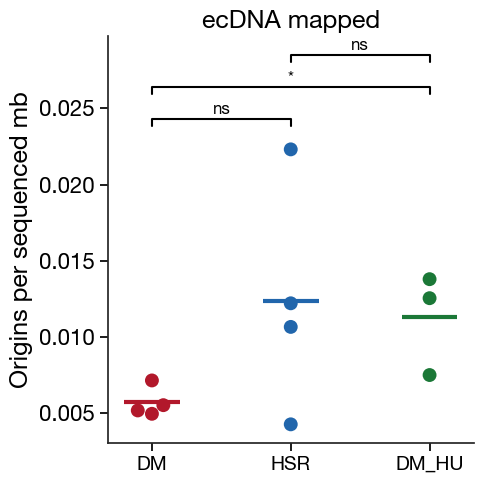

,group1,group2,statistic,p_value,median_group1,median_group2,mean_group1,mean_group2
0,DM,HSR,-1.154701,0.248213,0.005364,0.011442,0.005714,0.012368
1,DM,DM_HU,-2.121320,0.033895,0.005364,0.012551,0.005714,0.011287
2,HSR,DM_HU,-0.353553,0.723674,0.011442,0.012551,0.012368,0.011287


In [32]:
#------------------ DOTPLOT ------------------

# colors
colors_ori =  [colors_dict['red'], colors_dict['blue'], colors_dict['green']]

# custom order
custom_order = ['DM', 'HSR', 'DM_HU'] 
# pairs
pairs = [('DM', 'HSR'), ('DM', 'DM_HU'), ('HSR', 'DM_HU')]

# get mean and n for each group
group_stats = df_ori_combined.groupby('cell_line')['ori_per_mb'].agg(['mean', 'count'])
group_stats.index = pd.Categorical(group_stats.index, categories = custom_order, ordered = True)
group_stats = group_stats.sort_index()

# bar plot
plt.figure(figsize=(5, 5))
ax = sns.swarmplot(x = 'cell_line', y = 'ori_per_mb', hue = 'cell_line', data = df_ori_combined, palette = colors_ori, order = custom_order, size = 10)
# p value annotations
annotate_p_values(ax, df_ori_combined, group_col = 'cell_line', value_col = 'ori_per_mb', order = custom_order, comparisons = pairs, test = 'ranksums', display='stars', bracket_offset=0.0015, text_offset=0.0001, bracket_height = 0.0005, star_fontsize = 12)
#  mean lines with matching colors and dynamic labels
for i, row in enumerate(group_stats.itertuples()):
	group = row.Index
	mean = row.mean
	n = row.count 
	# calculate the xmin and xmax for each group based on the group's x-axis position
	xmin = i - 0.2
	xmax = i + 0.2
	ax.hlines(mean, xmin=xmin, xmax=xmax, color=colors_ori[i], linestyle='-', linewidth=3, label=f'µ = {mean:.2f}, n = {n}')
plt.title('ecDNA mapped', size = 18)
plt.xlabel('', size = 12)
plt.ylabel('Origins per sequenced mb', fontsize = 18)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=16) 
plt.tight_layout()
plt.savefig(f'{outpath}/figure_supp_04/{date}_origins_per_mb_dotplot.pdf')
plt.show()
plt.close()


# stats
groups = df_ori_combined['cell_line'].unique()

# pair-wise comparisons
group_pairs = list(combinations(groups, 2))

# pair-wise stats test
comparison_results = []
for g1, g2 in group_pairs:
	data_g1 = df_ori_combined.loc[df_ori_combined['cell_line'] == g1, 'ori_per_mb']
	data_g2 = df_ori_combined.loc[df_ori_combined['cell_line'] == g2, 'ori_per_mb']
	stat, p_val = stats.ranksums(data_g1, data_g2, alternative='two-sided')
	comparison_results.append({
		'group1': g1,
		'group2': g2,
		'statistic': stat,
		'p_value': p_val,
		'median_group1': data_g1.median(),
		'median_group2': data_g2.median(),
		'mean_group1': data_g1.mean(),
		'mean_group2': data_g2.mean()
	})

# list to df
df_pairwise_comparisons = pd.DataFrame(comparison_results)

# save and display
df_pairwise_comparisons.to_csv(f'{outpath}/figure_supp_04/{date}_origins_per_mb_pvalues.csv', index=False)
display(df_pairwise_comparisons)

### Supp Fig 4b: whole genome origins per sequenced mb (origin firing)

- exclude chr8 and chrY from analysis

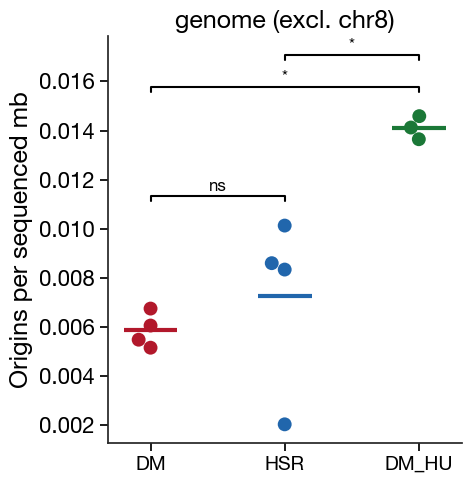

,group1,group2,statistic,p_value,median_group1,median_group2,mean_group1,mean_group2
0,DM,HSR,-1.154701,0.248213,0.005763,0.008464,0.005854,0.007270
1,DM,DM_HU,-2.121320,0.033895,0.005763,0.014122,0.005854,0.014118
2,HSR,DM_HU,-2.121320,0.033895,0.008464,0.014122,0.007270,0.014118


In [33]:
#------------------ DOTPLOT ------------------

# colors
colors_ori =  [colors_dict['red'], colors_dict['blue'], colors_dict['green']]

# custom order
custom_order = ['DM', 'HSR', 'DM_HU'] 
# pairs
pairs = [('DM', 'HSR'), ('DM', 'DM_HU'), ('HSR', 'DM_HU')]

# get mean and n for each group
group_stats = df_ori_combined_hg38.groupby('cell_line')['ori_per_mb'].agg(['mean', 'count'])
group_stats.index = pd.Categorical(group_stats.index, categories = custom_order, ordered = True)
group_stats = group_stats.sort_index()

# bar plot
plt.figure(figsize=(5, 5))
ax = sns.swarmplot(x = 'cell_line', y = 'ori_per_mb', hue = 'cell_line', data = df_ori_combined_hg38, palette = colors_ori, order = custom_order, size = 10)
# p value annotations
annotate_p_values(ax, df_ori_combined_hg38, group_col = 'cell_line', value_col = 'ori_per_mb', order = custom_order, comparisons = pairs, test = 'ranksums', display='stars', bracket_offset=0.001, text_offset=0.0001, bracket_height = 0.0002, star_fontsize = 12)
#  mean lines with matching colors and dynamic labels
for i, row in enumerate(group_stats.itertuples()):
	group = row.Index
	mean = row.mean
	n = row.count 
	# calculate the xmin and xmax for each group based on the group's x-axis position
	xmin = i - 0.2
	xmax = i + 0.2
	ax.hlines(mean, xmin=xmin, xmax=xmax, color=colors_ori[i], linestyle='-', linewidth=3, label=f'µ = {mean:.2f}, n = {n}')

plt.xlabel('', size = 12)
plt.title('genome (excl. chr8)', size = 18)
plt.ylabel('Origins per sequenced mb', fontsize = 18)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=16) 
plt.tight_layout()
plt.savefig(f'{outpath}/figure_supp_04/{date}_origins_per_mb_dotplot_hg38.pdf')
plt.show()
plt.close()

# stats
groups = df_ori_combined_hg38['cell_line'].unique()

# pair-wise comparisons
group_pairs = list(combinations(groups, 2))

# pair-wise stats test
comparison_results_hg38 = []
for g1, g2 in group_pairs:
	data_g1 = df_ori_combined_hg38.loc[df_ori_combined_hg38['cell_line'] == g1, 'ori_per_mb']
	data_g2 = df_ori_combined_hg38.loc[df_ori_combined_hg38['cell_line'] == g2, 'ori_per_mb']
	stat, p_val = stats.ranksums(data_g1, data_g2, alternative='two-sided')
	comparison_results_hg38.append({
		'group1': g1,
		'group2': g2,
		'statistic': stat,
		'p_value': p_val,
		'median_group1': data_g1.median(),
		'median_group2': data_g2.median(),
		'mean_group1': data_g1.mean(),
		'mean_group2': data_g2.mean()
	})

# list to df
df_pairwise_comparisons_hg38 = pd.DataFrame(comparison_results_hg38)

# save and display
df_pairwise_comparisons_hg38.to_csv(f'{outpath}/figure_supp_04/{date}_origins_per_mb_pvalue_hg38.csv', index=False)
display(df_pairwise_comparisons_hg38)


#### Supp Fig 4 c: ecDNA vs whole genome origin firing

,dataset,aligned_read_length,ori_count,ori_per_mb,group
0,20230404_1021_2F_PAO32425_75987c73,6035851360,30,0.004970,DM_ecDNA
1,20230425_1010_3H_PAO32479_809afcd8,1401878696,6,0.004280,HSR_ecDNA
2,20230510_1054_1G_PAO32432_0bc1c999,403414719,9,0.022310,HSR_ecDNA
3,20230510_1054_3D_PAO33004_ced1b521,1312321789,14,0.010668,HSR_ecDNA
4,20230523_1042_1G_PAO33157_73091287,1955931304,14,0.007158,DM_ecDNA
5,20230523_1042_2E_PAO32230_cc7c73b8,2889620384,15,0.005191,DM_ecDNA
6,20230523_1042_3F_PAO33005_6c56f96b,1146028797,14,0.012216,HSR_ecDNA
7,2023_03_21_JJ_ONT_PromethION1-8_d6c4705fpassfail,3973449105,22,0.005537,DM_ecDNA
8,20240110_1432_1G_PAQ70212_069eaaf1,3327827599,25,0.007512,DM_HU_ecDNA
9,20240110_1432_2G_PAQ61880_ba3b9440,3186880495,40,0.012551,DM_HU_ecDNA


/var/folders/m1/snn0v3cj5x31vv4clrmnrch40000gn/T/ipykernel_863/1907810014.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.swarmplot(x = 'group', y = 'ori_per_mb', data = df_ecDNA_hg38, palette = colors_ori, order = custom_order, size = 10)


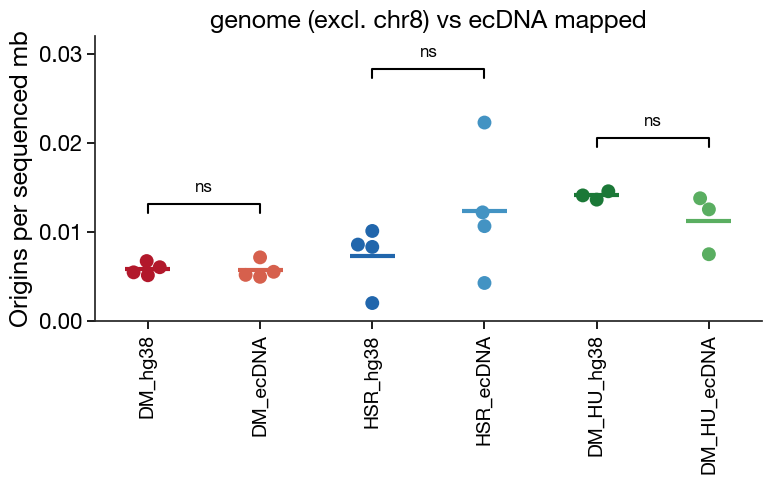

ori_per_mb          
                  mean    median
group                           
DM_HU_ecDNA   0.011287  0.012551
DM_HU_hg38    0.014118  0.014122
DM_ecDNA      0.005714  0.005364
DM_hg38       0.005854  0.005763
HSR_ecDNA     0.012368  0.011442
HSR_hg38      0.007270  0.008464

In [34]:
df_ori_combined_hg38['source'] = 'hg38'
df_ori_combined['source'] = 'ecDNA'

df_ecDNA_hg38 = pd.concat([df_ori_combined, df_ori_combined_hg38])
df_ecDNA_hg38['group'] = df_ecDNA_hg38['cell_line'] + '_' + df_ecDNA_hg38['source']
df_ecDNA_hg38.drop(columns=['cell_line', 'source'], inplace=True)
display(df_ecDNA_hg38)

#------------------ PLOT ORIGINS PER MB ------------------

colors_ori =  [colors_dict['red'], colors_dict['red2'], colors_dict['blue'], colors_dict['blue2'],colors_dict['green'], colors_dict['green2']]

# custom order
custom_order = ['DM_hg38', 'DM_ecDNA', 'HSR_hg38', 'HSR_ecDNA', 'DM_HU_hg38', 'DM_HU_ecDNA'] 
# pairs
pairs = [('DM_hg38', 'DM_ecDNA'), ('DM_HU_hg38', 'DM_HU_ecDNA'), ('HSR_hg38', 'HSR_ecDNA')]

# get mean and n for each group
group_stats = df_ecDNA_hg38.groupby('group')['ori_per_mb'].agg(['mean', 'count'])
group_stats.index = pd.Categorical(group_stats.index, categories = custom_order, ordered = True)
group_stats = group_stats.sort_index()

# bar plot
plt.figure(figsize=(8, 5))
ax = sns.swarmplot(x = 'group', y = 'ori_per_mb', data = df_ecDNA_hg38, palette = colors_ori, order = custom_order, size = 10)
# p value annotations
annotate_p_values(ax, df_ecDNA_hg38, group_col = 'group', value_col = 'ori_per_mb', order = custom_order, comparisons = pairs, test = 'ranksums', display='stars', bracket_offset=0.005, text_offset=0.001, bracket_height = 0.001, star_fontsize = 12)
#  mean lines with matching colors and dynamic labels
for i, row in enumerate(group_stats.itertuples()):
	group = row.Index
	mean = row.mean
	n = row.count 
	# calculate the xmin and xmax for each group based on the group's x-axis position
	xmin = i - 0.2
	xmax = i + 0.2
	ax.hlines(mean, xmin=xmin, xmax=xmax, color=colors_ori[i], linestyle='-', linewidth=3, label=f'mean = {mean:.2f}, n = {n}')
plt.ylim (0, 0.032)
plt.title('genome (excl. chr8) vs ecDNA mapped', size = 18)
plt.xlabel('', size = 12)
plt.ylabel('Origins per sequenced mb', fontsize = 18)
plt.tick_params(axis='x', which='major', labelsize=14, rotation=90)
plt.tick_params(axis='y', which='major', labelsize=16) 
plt.tight_layout()
plt.savefig(f'{outpath}/figure_supp_04/{date}_origins_per_mb_dotplot_hg38_vs_ecDNA.pdf')
plt.show()
plt.close()


# summary mean, median stats
display(df_ecDNA_hg38.groupby('group').agg({'ori_per_mb': ['mean', 'median']}))


# Supplementary Figure S5: Histograms of raw fork speed and stall score data

### Setup

In [35]:
# colors with alpha
colors = [colors_dict['red'], colors_dict['blue'], colors_dict['green']]

#stats txt files
end = '=====================================================================\n\n'

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_speed_supp.txt', 'w') as file:
	file.write('===================== STALL SCORE =====================\n\n')

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_stall_supp.txt', 'w') as file:
	file.write('===================== STALL SCORE =====================\n\n')

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_speedNoStall_supp.txt', 'a') as file:
	file.write('===================== SPEED (excl forks with stall score >= 0.8)=====================\n\n')


### Supplementary Figure S5a: Fork speed - hg38

- no IQR filtering

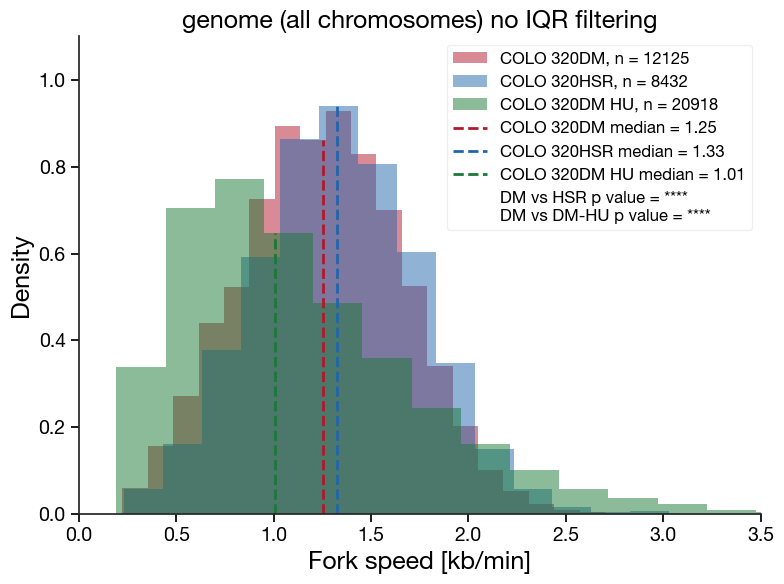

In [36]:
#--------------------------- hg38 ---------------------------

DM_HSR = stats.ttest_ind(df_DM_hg38_chr_incl['fork_speed'], df_HSR_hg38_chr_incl['fork_speed'], alternative = 'two-sided', equal_var = False)
DM_HU = stats.ttest_ind(df_DM_hg38_chr_incl['fork_speed'], df_DM_hg38_HU_chr_incl['fork_speed'], alternative = 'two-sided', equal_var = False)

plt.figure(figsize = (8, 6))
ylim_max = 1.1
# hist
n_DM, bins_DM, _ = plt.hist(df_DM_hg38_chr_incl['fork_speed'], bins = 30, label= 'COLO 320DM, ' + 'n = ' + str(len(df_DM_hg38_chr_incl['fork_speed'])), density = True, color = colors[0], alpha = 0.5, edgecolor = 'none')
n_HSR, bins_HSR, _ = plt.hist(df_HSR_hg38_chr_incl['fork_speed'], bins = 30, label= 'COLO 320HSR, ' + 'n = ' + str(len(df_HSR_hg38_chr_incl['fork_speed'])) , density = True, color = colors[1], alpha = 0.5, edgecolor = 'none')
n_DM_HU, bins_DM_HU, _ = plt.hist(df_DM_hg38_HU_chr_incl['fork_speed'], bins = 30, label= 'COLO 320DM HU, ' + 'n = ' + str(len(df_DM_hg38_HU_chr_incl['fork_speed'])), density = True, color = colors[2], alpha = 0.5, edgecolor = 'none') 
# median line
plt.axvline(df_DM_hg38_chr_incl['fork_speed'].median(), color=colors[0], linestyle='dashed', linewidth=2, label='COLO 320DM median = ' + "{:.2f}".format(df_DM_hg38_chr_incl['fork_speed'].median()) , ymax=(np.sort(n_DM)[::-1][2])/ylim_max)
plt.axvline(df_HSR_hg38_chr_incl['fork_speed'].median(), color=colors[1], linestyle='dashed', linewidth=2, label='COLO 320HSR median = ' + "{:.2f}".format(df_HSR_hg38_chr_incl['fork_speed'].median()) , ymax=max(n_HSR)/ylim_max)
plt.axvline(df_DM_hg38_HU_chr_incl['fork_speed'].median(), color=colors[2], linestyle='dashed', linewidth=2, label='COLO 320DM HU median = ' +  "{:.2f}".format(df_DM_hg38_HU_chr_incl['fork_speed'].median()), ymax=(np.sort(n_DM_HU)[::-1][2])/ylim_max)
# pval legend
plt.plot([], [], ' ', label = f'DM vs HSR p value = {format_p_value(DM_HSR.pvalue)} \nDM vs DM-HU p value = {format_p_value(DM_HU.pvalue)}')
# labels
plt.xlim(0, 3.5)
plt.ylim(0, ylim_max)
plt.ylabel('Density', size = 18)
plt.xlabel('Fork speed [kb/min]', size = 18)
plt.title("genome (all chromosomes) no IQR filtering", size = 18)
plt.legend(framealpha = 0.3, loc = 'upper right', fontsize = 12)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_05/' + date + '_speed_histogram' + '_HSR_vs_DM_vs_DMHU_hg38' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# stats
combined_df = pd.concat([df_DM_hg38_chr_incl, df_HSR_hg38_chr_incl, df_DM_hg38_HU_chr_incl])
group_stats = combined_df.groupby('cell_line')['fork_speed'].agg(['median', 'mean', 'count', 'min', 'max']).reset_index()
group_stats['cell_line'] = group_stats['cell_line'].str.replace('directories_', '')

# write to file
header = '=====================hg38 (all chromosomes): fork speed (no IQR filtering)===================== \n'
p_value_text = f"Two-sided Welch's t-test (unequal variances assumed):\nDM vs HSR p value = {DM_HSR.pvalue} \nDM vs DM-HU p value = {DM_HU.pvalue}\n"

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_speed_supp.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(str(group_stats.to_string(index=False)))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Supplementary Figure S5b: Fork speed - hg38 excl. chr8

- no IQR filtering

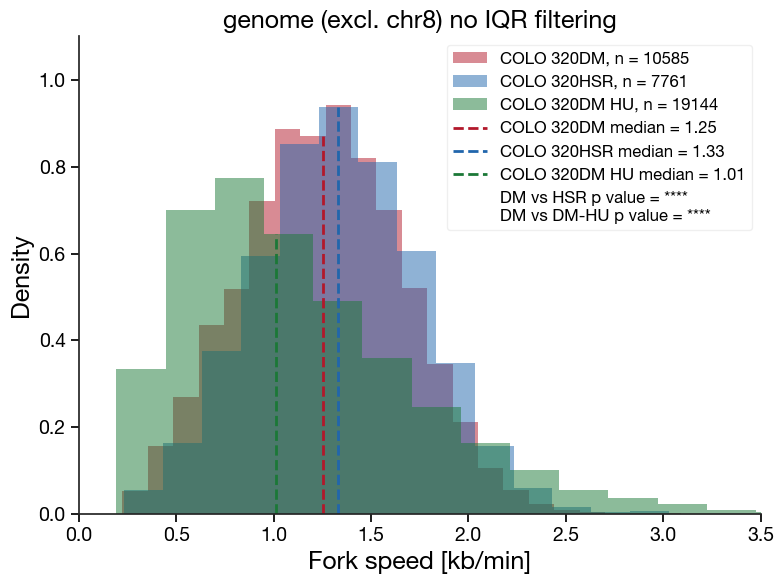

In [37]:
#--------------------------- no chr8 ---------------------------

DM_HSR = stats.ttest_ind(df_DM_hg38_chr8_incl['fork_speed'], df_HSR_hg38_chr8_incl['fork_speed'], alternative = 'two-sided', equal_var = False)
DM_HU = stats.ttest_ind(df_DM_hg38_chr8_incl['fork_speed'], df_DM_hg38_HU_chr8_incl['fork_speed'], alternative = 'two-sided', equal_var = False)

plt.figure(figsize = (8, 6))
ylim_max = 1.1
# hist
n_DM, bins_DM, _ = plt.hist(df_DM_hg38_chr8_incl['fork_speed'], bins = 30, label= 'COLO 320DM, ' + 'n = ' + str(len(df_DM_hg38_chr8_incl['fork_speed'])), density = True, color = colors[0], alpha = 0.5, edgecolor = 'none')
n_HSR, bins_HSR, _ = plt.hist(df_HSR_hg38_chr8_incl['fork_speed'], bins = 30, label= 'COLO 320HSR, ' + 'n = ' + str(len(df_HSR_hg38_chr8_incl['fork_speed'])) , density = True, color = colors[1], alpha = 0.5, edgecolor = 'none')
n_DM_HU, bins_DM_HU, _ = plt.hist(df_DM_hg38_HU_chr8_incl['fork_speed'], bins = 30, label= 'COLO 320DM HU, ' + 'n = ' + str(len(df_DM_hg38_HU_chr8_incl['fork_speed'])), density = True, color = colors[2], alpha = 0.5, edgecolor = 'none')
# median line
plt.axvline(df_DM_hg38_chr8_incl['fork_speed'].median(), color=colors[0], linestyle='dashed', linewidth=2, label='COLO 320DM median = ' + "{:.2f}".format(df_DM_hg38_chr8_incl['fork_speed'].median()) , ymax=(np.sort(n_DM)[::-1][2])/ylim_max)
plt.axvline(df_HSR_hg38_chr8_incl['fork_speed'].median(), color=colors[1], linestyle='dashed', linewidth=2, label='COLO 320HSR median = ' + "{:.2f}".format(df_HSR_hg38_chr8_incl['fork_speed'].median()) , ymax=max(n_HSR)/ylim_max)
plt.axvline(df_DM_hg38_HU_chr8_incl['fork_speed'].median(), color=colors[2], linestyle='dashed', linewidth=2, label='COLO 320DM HU median = ' +  "{:.2f}".format(df_DM_hg38_HU_chr8_incl['fork_speed'].median()), ymax=(np.sort(n_DM_HU)[::-1][2])/ylim_max)
# pval legend
plt.plot([], [], ' ', label = f'DM vs HSR p value = {format_p_value(DM_HSR.pvalue)} \nDM vs DM-HU p value = {format_p_value(DM_HU.pvalue)}')
# labels
plt.xlim(0, 3.5)
plt.ylim(0, ylim_max)
plt.ylabel('Density', size = 18)
plt.xlabel('Fork speed [kb/min]', size = 18)
plt.title("genome (excl. chr8) no IQR filtering", size = 18)
plt.legend(framealpha = 0.3, loc = 'upper right', fontsize = 12)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_05/' + date + '_speed_histogram' + '_HSR_vs_DM_vs_DMHU_hg38_noChr8' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# stats
combined_df = pd.concat([df_DM_hg38_chr8_incl, df_HSR_hg38_chr8_incl, df_DM_hg38_HU_chr8_incl])
group_stats = combined_df.groupby('cell_line')['fork_speed'].agg(['median', 'mean', 'count', 'min', 'max']).reset_index()
group_stats['cell_line'] = group_stats['cell_line'].str.replace('directories_', '')

# write to file
header = '=====================hg38 (excl. chr8): fork speed (no IQR filtering)===================== \n'
p_value_text = f"Two-sided Welch's t-test (unequal variances assumed): \nDM vs HSR p value = {DM_HSR.pvalue} \nDM vs DM-HU p value = {DM_HU.pvalue}\n"

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_speed_supp.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(str(group_stats.to_string(index=False)))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Supplementary Figure S5c: Fork speed - ecDNA

- no IQR filtering

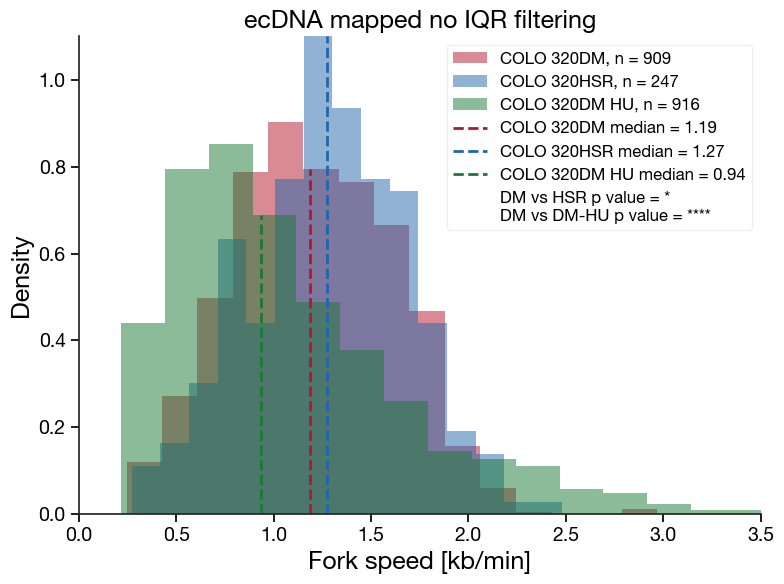

In [38]:
#--------------------------- ecDNA ---------------------------

DM_HSR = stats.ttest_ind(df_DM_ecDNA_incl['fork_speed'], df_HSR_ecDNA_incl['fork_speed'], alternative = 'two-sided', equal_var = False)
DM_HU = stats.ttest_ind(df_DM_ecDNA_incl['fork_speed'], df_DM_ecDNA_HU_incl['fork_speed'], alternative = 'two-sided', equal_var = False)

plt.figure(figsize = (8, 6))
ylim_max = 1.1
# hist
n_DM, bins_DM, _ = plt.hist(df_DM_ecDNA_incl['fork_speed'], bins = 15, label= 'COLO 320DM, ' + 'n = ' + str(len(df_DM_ecDNA_incl['fork_speed'])), density = True, color = colors[0], alpha = 0.5, edgecolor = 'none')
n_HSR, bins_HSR, _ = plt.hist(df_HSR_ecDNA_incl['fork_speed'], bins = 15, label= 'COLO 320HSR, ' + 'n = ' + str(len(df_HSR_ecDNA_incl['fork_speed'])) , density = True, color = colors[1], alpha = 0.5, edgecolor = 'none')
n_DM_HU, bins_DM_HU, _ = plt.hist(df_DM_ecDNA_HU_incl['fork_speed'], bins = 15, label= 'COLO 320DM HU, ' + 'n = ' + str(len(df_DM_ecDNA_HU_incl['fork_speed'])), density = True, color = colors[2], alpha = 0.5, edgecolor = 'none')
# median line
plt.axvline(df_DM_ecDNA_incl['fork_speed'].median(), color=colors[0], linestyle='dashed', linewidth=2, label='COLO 320DM median = ' + "{:.2f}".format(df_DM_ecDNA_incl['fork_speed'].median()) , ymax=(np.sort(n_DM)[::-1][1])/ylim_max)
plt.axvline(df_HSR_ecDNA_incl['fork_speed'].median(), color=colors[1], linestyle='dashed', linewidth=2, label='COLO 320HSR median = ' + "{:.2f}".format(df_HSR_ecDNA_incl['fork_speed'].median()) , ymax=max(n_HSR)/ylim_max)
plt.axvline(df_DM_ecDNA_HU_incl['fork_speed'].median(), color=colors[2], linestyle='dashed', linewidth=2, label='COLO 320DM HU median = ' +  "{:.2f}".format(df_DM_ecDNA_HU_incl['fork_speed'].median()), ymax=(np.sort(n_DM_HU)[::-1][2])/ylim_max)
# pval legend
plt.plot([], [], ' ', label = f'DM vs HSR p value = {format_p_value(DM_HSR.pvalue)} \nDM vs DM-HU p value = {format_p_value(DM_HU.pvalue)}')
# labels
plt.xlim(0, 3.5)
plt.ylim(0, ylim_max)
plt.ylabel('Density', size = 18)
plt.xlabel('Fork speed [kb/min]', size = 18)
plt.title("ecDNA mapped no IQR filtering", size = 18)
plt.legend(framealpha = 0.3, loc = 'upper right', fontsize = 12)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_05/' + date + '_speed_histogram' + '_HSR_vs_DM_vs_DMHU_ecDNA' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# stats
combined_df = pd.concat([df_DM_ecDNA_incl, df_HSR_ecDNA_incl, df_DM_ecDNA_HU_incl])
group_stats = combined_df.groupby('cell_line')['fork_speed'].agg(['median', 'mean', 'count', 'min', 'max']).reset_index()
group_stats['cell_line'] = group_stats['cell_line'].str.replace('directories_', '')
group_stats 

# write to file
header = '=====================ecDNA mapped: fork speed (no IQR filtering)===================== \n'
p_value_text = f"Two-sided Welch's t-test (unequal variances assumed): \nDM vs HSR p value = {DM_HSR.pvalue} \nDM vs DM-HU p value = {DM_HU.pvalue}\n"

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_speed_supp.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(str(group_stats.to_string(index=False)))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Supplementary Figure S5d: Stall score - hg38

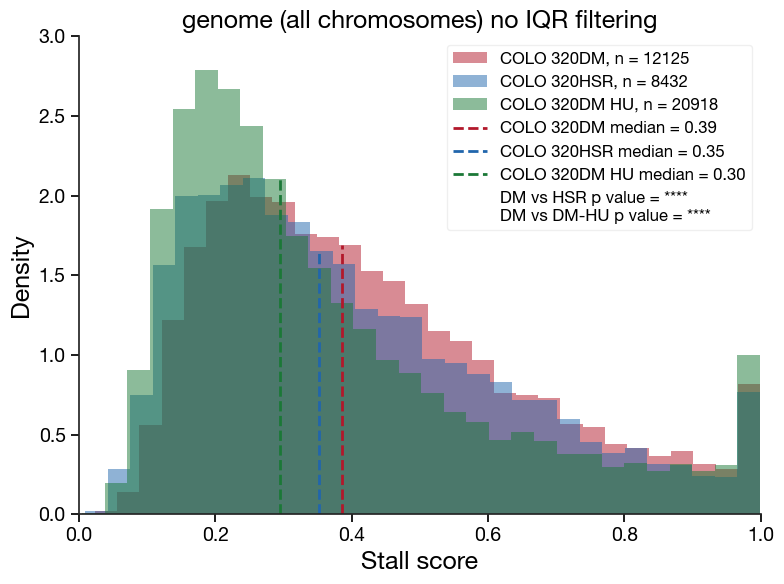

In [39]:
DM_HSR = stats.ranksums(df_DM_hg38_chr_incl['stall_score'], df_HSR_hg38_chr_incl['stall_score'], alternative = 'two-sided')
DM_HU = stats.ranksums(df_DM_hg38_chr_incl['stall_score'], df_DM_hg38_HU_chr_incl['stall_score'], alternative = 'two-sided')

plt.figure(figsize = (8, 6))
ylim_max = 3
# hist
n_DM, bins_DM, _ = plt.hist(df_DM_hg38_chr_incl['stall_score'], bins = 30, label= 'COLO 320DM, ' + 'n = ' + str(len(df_DM_hg38_chr_incl['stall_score'])), density = True, color = colors[0], alpha = 0.5, edgecolor = 'none')
n_HSR, bins_HSR, _ = plt.hist(df_HSR_hg38_chr_incl['stall_score'], bins = 30, label= 'COLO 320HSR, ' + 'n = ' + str(len(df_HSR_hg38_chr_incl['stall_score'])) , density = True, color = colors[1], alpha = 0.5, edgecolor = 'none')
n_DM_HU, bins_DM_HU, _ = plt.hist(df_DM_hg38_HU_chr_incl['stall_score'], bins = 30, label= 'COLO 320DM HU, ' + 'n = ' + str(len(df_DM_hg38_HU_chr_incl['stall_score'])), density = True, color = colors[2], alpha = 0.5, edgecolor = 'none')
# median line
plt.axvline(df_DM_hg38_chr_incl['stall_score'].median(), color=colors[0], linestyle='dashed', linewidth=2, label='COLO 320DM median = ' + "{:.2f}".format(df_DM_hg38_chr_incl['stall_score'].median()) , ymax=(np.sort(n_DM)[::-1][6])/ylim_max)
plt.axvline(df_HSR_hg38_chr_incl['stall_score'].median(), color=colors[1], linestyle='dashed', linewidth=2, label='COLO 320HSR median = ' + "{:.2f}".format(df_HSR_hg38_chr_incl['stall_score'].median()) , ymax=(np.sort(n_HSR)[::-1][6])/ylim_max)
plt.axvline(df_DM_hg38_HU_chr_incl['stall_score'].median(), color=colors[2], linestyle='dashed', linewidth=2, label='COLO 320DM HU median = ' +  "{:.2f}".format(df_DM_hg38_HU_chr_incl['stall_score'].median()), ymax=(np.sort(n_DM_HU)[::-1][4])/ylim_max)
# pval legend
plt.plot([], [], ' ', label = f'DM vs HSR p value = {format_p_value(DM_HSR.pvalue)} \nDM vs DM-HU p value = {format_p_value(DM_HU.pvalue)}')
# labels
plt.xlim(0, 1)
plt.ylim(0, ylim_max)
plt.ylabel('Density', size = 18)
plt.xlabel('Stall score', size = 18)
plt.title('genome (all chromosomes) no IQR filtering', size = 18)
plt.legend(framealpha = 0.3, loc = 'upper right', fontsize = 12)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_05/' + date + '_stall_histogram' + '_HSR_vs_DM_vs_DMHU_hg38' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# stats
combined_df = pd.concat([df_DM_hg38_chr_incl, df_HSR_hg38_chr_incl, df_DM_hg38_HU_chr_incl])
group_stats = combined_df.groupby('cell_line')['stall_score'].agg(['median', 'mean', 'count', 'min', 'max']).reset_index()
group_stats['cell_line'] = group_stats['cell_line'].str.replace('directories_', '')

# write to file
header = '=====================hg38 (all chromosomes): stall_score ===================== \n'
p_value_text = f"Two-sided Wilcoxon rank-sum test (non-parametric test):\nDM vs HSR p value = {DM_HSR.pvalue} \nDM vs DM-HU p value = {DM_HU.pvalue}\n"

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_stall_supp.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(str(group_stats.to_string(index=False)))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Supplementary Figure S5e: Stall score - hg38 excl. chr8

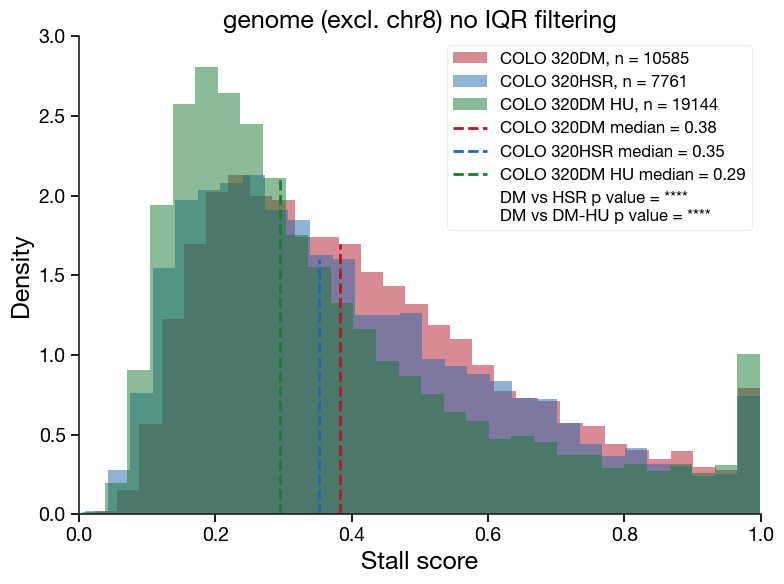

In [40]:
#--------------------------- no chr8 ---------------------------

DM_HSR = stats.ranksums(df_DM_hg38_chr8_incl['stall_score'], df_HSR_hg38_chr8_incl['stall_score'], alternative = 'two-sided')
DM_HU = stats.ranksums(df_DM_hg38_chr8_incl['stall_score'], df_DM_hg38_HU_chr8_incl['stall_score'], alternative = 'two-sided')

plt.figure(figsize = (8, 6))
ylim_max = 3
# hist
n_DM, bins_DM, _ = plt.hist(df_DM_hg38_chr8_incl['stall_score'], bins = 30, label= 'COLO 320DM, ' + 'n = ' + str(len(df_DM_hg38_chr8_incl['stall_score'])), density = True, color = colors[0], alpha = 0.5, edgecolor = 'none')
n_HSR, bins_HSR, _ = plt.hist(df_HSR_hg38_chr8_incl['stall_score'], bins = 30, label= 'COLO 320HSR, ' + 'n = ' + str(len(df_HSR_hg38_chr8_incl['stall_score'])) , density = True, color = colors[1], alpha = 0.5, edgecolor = 'none')
n_DM_HU, bins_DM_HU, _ = plt.hist(df_DM_hg38_HU_chr8_incl['stall_score'], bins = 30, label= 'COLO 320DM HU, ' + 'n = ' + str(len(df_DM_hg38_HU_chr8_incl['stall_score'])), density = True, color = colors[2], alpha = 0.5, edgecolor = 'none')
# median line
plt.axvline(df_DM_hg38_chr8_incl['stall_score'].median(), color=colors[0], linestyle='dashed', linewidth=2, label='COLO 320DM median = ' + "{:.2f}".format(df_DM_hg38_chr8_incl['stall_score'].median()) , ymax=(np.sort(n_DM)[::-1][6])/ylim_max)
plt.axvline(df_HSR_hg38_chr8_incl['stall_score'].median(), color=colors[1], linestyle='dashed', linewidth=2, label='COLO 320HSR median = ' + "{:.2f}".format(df_HSR_hg38_chr8_incl['stall_score'].median()) , ymax=(np.sort(n_HSR)[::-1][7])/ylim_max)
plt.axvline(df_DM_hg38_HU_chr8_incl['stall_score'].median(), color=colors[2], linestyle='dashed', linewidth=2, label='COLO 320DM HU median = ' +  "{:.2f}".format(df_DM_hg38_HU_chr8_incl['stall_score'].median()), ymax=(np.sort(n_DM_HU)[::-1][4])/ylim_max)
# pval legend
plt.plot([], [], ' ', label = f'DM vs HSR p value = {format_p_value(DM_HSR.pvalue)} \nDM vs DM-HU p value = {format_p_value(DM_HU.pvalue)}')
# labels
plt.xlim(0, 1)
plt.ylim(0, ylim_max)
plt.ylabel('Density', size = 18)
plt.xlabel('Stall score', size = 18)
plt.title('genome (excl. chr8) no IQR filtering', size = 18)
plt.legend(framealpha = 0.3, loc = 'upper right', fontsize = 12)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_05/' + date + '_stall_histogram' + '_HSR_vs_DM_vs_DMHU_hg38_noChr8' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# stats
combined_df = pd.concat([df_DM_hg38_chr8_incl, df_HSR_hg38_chr8_incl, df_DM_hg38_HU_chr8_incl])
group_stats = combined_df.groupby('cell_line')['stall_score'].agg(['median', 'mean', 'count', 'min', 'max']).reset_index()
group_stats['cell_line'] = group_stats['cell_line'].str.replace('directories_', '')

# write to file
header = '=====================hg38 (excl. chr8): stall_score ===================== \n'
p_value_text = f"Two-sided Wilcoxon rank-sum test (non-parametric test):\nDM vs HSR p value = {DM_HSR.pvalue} \nDM vs DM-HU p value = {DM_HU.pvalue}\n"

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_stall_supp.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(str(group_stats.to_string(index=False)))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Supplementary Figure S5f: Stall score - ecDNA

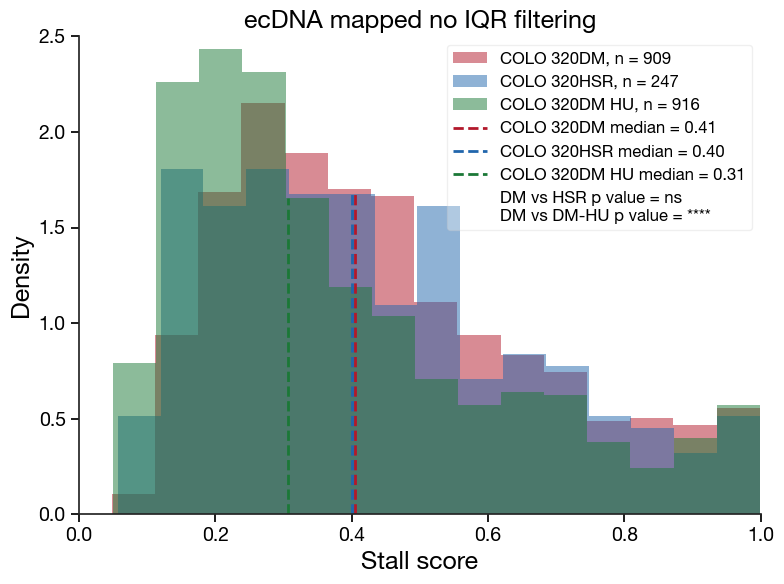

In [41]:
#--------------------------- ecDNA ---------------------------

DM_HSR = stats.ranksums(df_DM_ecDNA_incl['stall_score'], df_HSR_ecDNA_incl['stall_score'], alternative = 'two-sided')
DM_HU = stats.ranksums(df_DM_ecDNA_incl['stall_score'], df_DM_ecDNA_HU_incl['stall_score'], alternative = 'two-sided')

plt.figure(figsize = (8, 6))
ylim_max = 2.5
# hist
n_DM, bins_DM, _ = plt.hist(df_DM_ecDNA_incl['stall_score'], bins = 15, label= 'COLO 320DM, ' + 'n = ' + str(len(df_DM_ecDNA_incl['stall_score'])), density = True, color = colors[0], alpha = 0.5, edgecolor = 'none')
n_HSR, bins_HSR, _ = plt.hist(df_HSR_ecDNA_incl['stall_score'], bins = 15, label= 'COLO 320HSR, ' + 'n = ' + str(len(df_HSR_ecDNA_incl['stall_score'])) , density = True, color = colors[1], alpha = 0.5, edgecolor = 'none')
n_DM_HU, bins_DM_HU, _ = plt.hist(df_DM_ecDNA_HU_incl['stall_score'], bins = 15, label= 'COLO 320DM HU, ' + 'n = ' + str(len(df_DM_ecDNA_HU_incl['stall_score'])), density = True, color = colors[2], alpha = 0.5, edgecolor = 'none')
# median line
plt.axvline(df_DM_ecDNA_incl['stall_score'].median(), color=colors[0], linestyle='dashed', linewidth=2, label='COLO 320DM median = ' + "{:.2f}".format(df_DM_ecDNA_incl['stall_score'].median()) , ymax=(np.sort(n_DM)[::-1][3])/ylim_max)
plt.axvline(df_HSR_ecDNA_incl['stall_score'].median(), color=colors[1], linestyle='dashed', linewidth=2, label='COLO 320HSR median = ' + "{:.2f}".format(df_HSR_ecDNA_incl['stall_score'].median()) , ymax=(np.sort(n_HSR)[::-1][2])/ylim_max)
plt.axvline(df_DM_ecDNA_HU_incl['stall_score'].median(), color=colors[2], linestyle='dashed', linewidth=2, label='COLO 320DM HU median = ' +  "{:.2f}".format(df_DM_ecDNA_HU_incl['stall_score'].median()), ymax=(np.sort(n_DM_HU)[::-1][3])/ylim_max)
# pval legend
plt.plot([], [], ' ', label = f'DM vs HSR p value = {format_p_value(DM_HSR.pvalue)} \nDM vs DM-HU p value = {format_p_value(DM_HU.pvalue)}')
# labels
plt.xlim(0, 1)
plt.ylim(0, ylim_max)
plt.ylabel('Density', size = 18)
plt.xlabel('Stall score', size = 18)
plt.title('ecDNA mapped no IQR filtering', size = 18)
plt.legend(framealpha = 0.3, loc = 'upper right', fontsize = 12)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_05/' + date + '_stall_histogram' + '_HSR_vs_DM_vs_DMHU_ecDNA' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# stats
combined_df = pd.concat([df_DM_ecDNA_incl, df_HSR_ecDNA_incl, df_DM_ecDNA_HU_incl])
group_stats = combined_df.groupby('cell_line')['stall_score'].agg(['median', 'mean', 'count', 'min', 'max']).reset_index()
group_stats['cell_line'] = group_stats['cell_line'].str.replace('directories_', '')
group_stats 

# write to file
header = '=====================ecDNA mapped: stall_score ===================== \n'
p_value_text = f"Two-sided Wilcoxon rank-sum test (non-parametric test):\nDM vs HSR p value = {DM_HSR.pvalue} \nDM vs DM-HU p value = {DM_HU.pvalue}\n"

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_stall_supp.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(str(group_stats.to_string(index=False)))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Supplementary Figure S5g: Speed excl. stalled - hg38

- IQR filtering applied but excluding forks with stall score >= 0.8

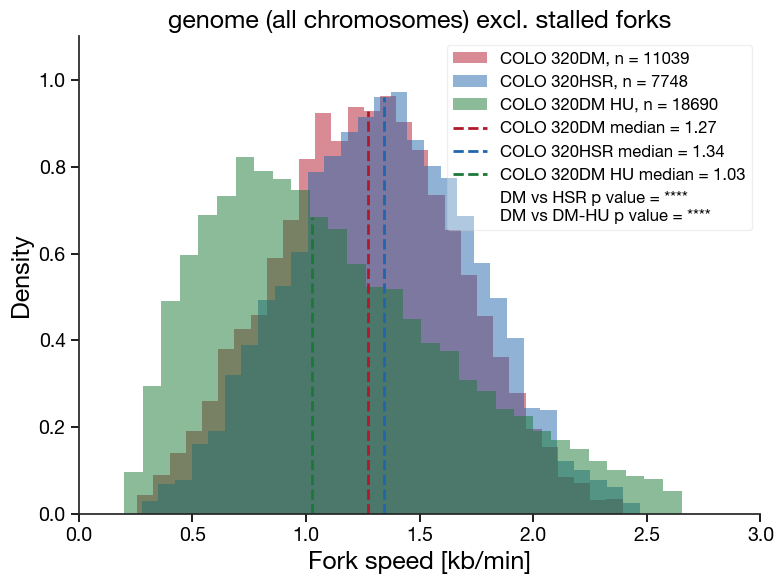

In [42]:
#--------------------------- hg38 ---------------------------

DM_HSR = stats.ttest_ind(df_DM_hg38_chr_noStall['fork_speed'], df_HSR_hg38_chr_noStall['fork_speed'], alternative = 'two-sided', equal_var = False)
DM_HU = stats.ttest_ind(df_DM_hg38_chr_noStall['fork_speed'], df_DM_hg38_HU_chr_noStall['fork_speed'], alternative = 'two-sided', equal_var = False)

plt.figure(figsize = (8, 6))
ylim_max = 1.1
# hist
n_DM, bins_DM, _ = plt.hist(df_DM_hg38_chr_noStall['fork_speed'], bins = 30, label= 'COLO 320DM, ' + 'n = ' + str(len(df_DM_hg38_chr_noStall['fork_speed'])), density = True, color = colors[0], alpha = 0.5, edgecolor = 'none')
n_HSR, bins_HSR, _ = plt.hist(df_HSR_hg38_chr_noStall['fork_speed'], bins = 30, label= 'COLO 320HSR, ' + 'n = ' + str(len(df_HSR_hg38_chr_noStall['fork_speed'])) , density = True, color = colors[1], alpha = 0.5, edgecolor = 'none')
n_DM_HU, bins_DM_HU, _ = plt.hist(df_DM_hg38_HU_chr_noStall['fork_speed'], bins = 30, label= 'COLO 320DM HU, ' + 'n = ' + str(len(df_DM_hg38_HU_chr_noStall['fork_speed'])), density = True, color = colors[2], alpha = 0.5, edgecolor = 'none')
# median line
plt.axvline(df_DM_hg38_chr_noStall['fork_speed'].median(), color=colors[0], linestyle='dashed', linewidth=2, label='COLO 320DM median = ' + "{:.2f}".format(df_DM_hg38_chr_noStall['fork_speed'].median()) , ymax=(np.sort(n_DM)[::-1][2])/ylim_max)
plt.axvline(df_HSR_hg38_chr_noStall['fork_speed'].median(), color=colors[1], linestyle='dashed', linewidth=2, label='COLO 320HSR median = ' + "{:.2f}".format(df_HSR_hg38_chr_noStall['fork_speed'].median()) , ymax=(np.sort(n_HSR)[::-1][1])/ylim_max)
plt.axvline(df_DM_hg38_HU_chr_noStall['fork_speed'].median(), color=colors[2], linestyle='dashed', linewidth=2, label='COLO 320DM HU median = ' +  "{:.2f}".format(df_DM_hg38_HU_chr_noStall['fork_speed'].median()), ymax=(np.sort(n_DM_HU)[::-1][6])/ylim_max)
# pval legend
plt.plot([], [], ' ', label = f'DM vs HSR p value = {format_p_value(DM_HSR.pvalue)} \nDM vs DM-HU p value = {format_p_value(DM_HU.pvalue)}')
# labels
plt.xlim(0, 3)
plt.ylim(0, ylim_max)
plt.ylabel('Density', size = 18)
plt.xlabel('Fork speed [kb/min]', size = 18)
plt.title("genome (all chromosomes) excl. stalled forks", size = 18)
plt.legend(framealpha = 0.3, loc = 'upper right', fontsize = 12)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_05/' + date + '_speed_noStall_histogram' + '_HSR_vs_DM_vs_DMHU_hg38' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# stats
combined_df = pd.concat([df_DM_hg38_chr_noStall, df_HSR_hg38_chr_noStall, df_DM_hg38_HU_chr_noStall])
group_stats = combined_df.groupby('cell_line')['fork_speed'].agg(['median', 'mean', 'count', 'min', 'max']).reset_index()
group_stats['cell_line'] = group_stats['cell_line'].str.replace('directories_', '')

# write to file
header = '=====================hg38 (all chromosomes): fork speed (excl stalled forks & IQR filtering)===================== \n'
p_value_text = f"Two-sided Welch's t-test (unequal variances assumed):\nDM vs HSR p value = {DM_HSR.pvalue} \nDM vs DM-HU p value = {DM_HU.pvalue}\n"

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_speedNoStall_supp.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(str(group_stats.to_string(index=False)))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Supplementary Figure S5h: Speed excl. stalled - hg38 excl. chr8

- IQR filtering applied but excluding forks with stall score >= 0.8

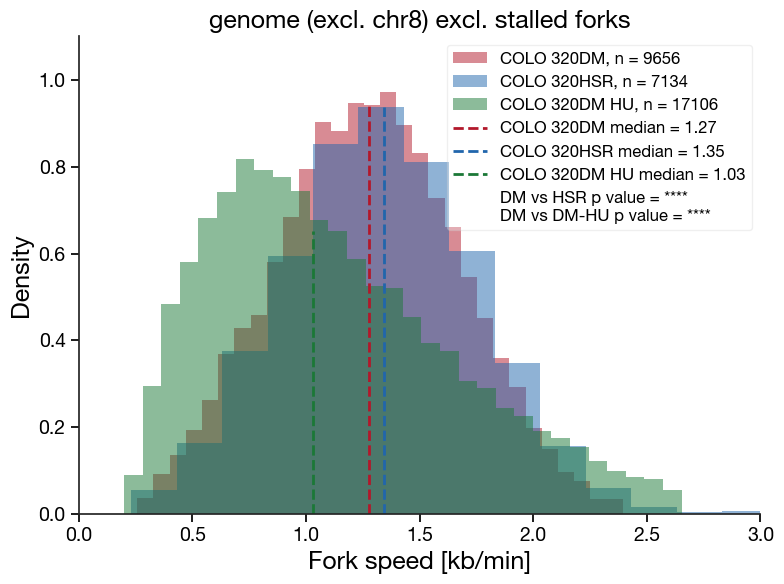

In [43]:
#--------------------------- no chr8 ---------------------------

DM_HSR = stats.ttest_ind(df_DM_hg38_chr8_noStall['fork_speed'], df_HSR_hg38_chr8_noStall['fork_speed'], alternative = 'two-sided', equal_var = False)
DM_HU = stats.ttest_ind(df_DM_hg38_chr8_noStall['fork_speed'], df_DM_hg38_HU_chr8_noStall['fork_speed'], alternative = 'two-sided', equal_var = False)

plt.figure(figsize = (8, 6))
ylim_max = 1.1
# hist
n_DM, bins_DM, _ = plt.hist(df_DM_hg38_chr8_noStall['fork_speed'], bins = 30, label= 'COLO 320DM, ' + 'n = ' + str(len(df_DM_hg38_chr8_noStall['fork_speed'])), density = True, color = colors[0], alpha = 0.5, edgecolor = 'none')
n_HSR, bins_HSR, _ = plt.hist(df_HSR_hg38_chr8_incl['fork_speed'], bins = 30, label= 'COLO 320HSR, ' + 'n = ' + str(len(df_HSR_hg38_chr8_noStall['fork_speed'])) , density = True, color = colors[1], alpha = 0.5, edgecolor = 'none')
n_DM_HU, bins_DM_HU, _ = plt.hist(df_DM_hg38_HU_chr8_noStall['fork_speed'], bins = 30, label= 'COLO 320DM HU, ' + 'n = ' + str(len(df_DM_hg38_HU_chr8_noStall['fork_speed'])), density = True, color = colors[2], alpha = 0.5, edgecolor = 'none') 
# median line
plt.axvline(df_DM_hg38_chr8_noStall['fork_speed'].median(), color=colors[0], linestyle='dashed', linewidth=2, label='COLO 320DM median = ' + "{:.2f}".format(df_DM_hg38_chr8_noStall['fork_speed'].median()) , ymax=(np.sort(n_DM)[::-1][2])/ylim_max)
plt.axvline(df_HSR_hg38_chr8_noStall['fork_speed'].median(), color=colors[1], linestyle='dashed', linewidth=2, label='COLO 320HSR median = ' + "{:.2f}".format(df_HSR_hg38_chr8_noStall['fork_speed'].median()) , ymax=(np.sort(n_HSR)[::-1][0])/ylim_max)
plt.axvline(df_DM_hg38_HU_chr8_noStall['fork_speed'].median(), color=colors[2], linestyle='dashed', linewidth=2, label='COLO 320DM HU median = ' +  "{:.2f}".format(df_DM_hg38_HU_chr8_noStall['fork_speed'].median()), ymax=(np.sort(n_DM_HU)[::-1][7])/ylim_max)
# pval legend
plt.plot([], [], ' ', label = f'DM vs HSR p value = {format_p_value(DM_HSR.pvalue)} \nDM vs DM-HU p value = {format_p_value(DM_HU.pvalue)}')
# labels
plt.xlim(0, 3)
plt.ylim(0, ylim_max)
plt.ylabel('Density', size = 18)
plt.xlabel('Fork speed [kb/min]', size = 18)
plt.title("genome (excl. chr8) excl. stalled forks", size = 18)
plt.legend(framealpha = 0.3, loc = 'upper right', fontsize = 12)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_05/' + date + '_speedNoStall_histogram' + '_HSR_vs_DM_vs_DMHU_hg38_noChr8' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# stats
combined_df = pd.concat([df_DM_hg38_chr8_noStall, df_HSR_hg38_chr8_noStall, df_DM_hg38_HU_chr8_noStall])
group_stats = combined_df.groupby('cell_line')['fork_speed'].agg(['median', 'mean', 'count', 'min', 'max']).reset_index()
group_stats['cell_line'] = group_stats['cell_line'].str.replace('directories_', '')

# write to file
header = '=====================hg38 (excl. chr8): fork speed (no IQR filtering)===================== \n'
p_value_text = f"Two-sided Welch's t-test (unequal variances assumed): \nDM vs HSR p value = {DM_HSR.pvalue} \nDM vs DM-HU p value = {DM_HU.pvalue}\n"

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_speedNoStall_supp.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(str(group_stats.to_string(index=False)))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

### Supplementary Figure S5i: Speed excl. stalled - ecDNA

- IQR filtering applied but excluding forks with stall score >= 0.8

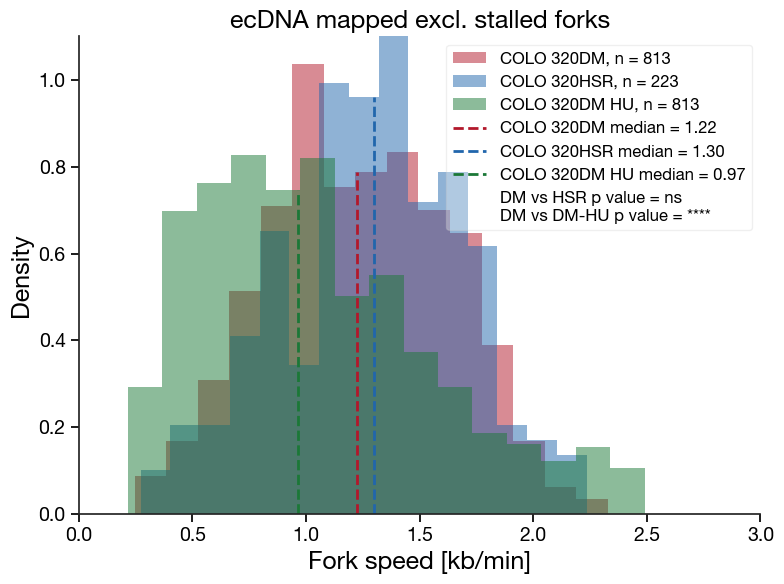

In [44]:
#--------------------------- ecDNA ---------------------------

DM_HSR = stats.ttest_ind(df_DM_ecDNA_noStall['fork_speed'], df_HSR_ecDNA_noStall['fork_speed'], alternative = 'two-sided', equal_var = False)
DM_HU = stats.ttest_ind(df_DM_ecDNA_noStall['fork_speed'], df_DM_ecDNA_HU_noStall['fork_speed'], alternative = 'two-sided', equal_var = False)

plt.figure(figsize = (8, 6))
ylim_max = 1.1
# hist
n_DM, bins_DM, _ = plt.hist(df_DM_ecDNA_noStall['fork_speed'], bins = 15, label= 'COLO 320DM, ' + 'n = ' + str(len(df_DM_ecDNA_noStall['fork_speed'])), density = True, color = colors[0], alpha = 0.5, edgecolor = 'none')
n_HSR, bins_HSR, _ = plt.hist(df_HSR_ecDNA_noStall['fork_speed'], bins = 15, label= 'COLO 320HSR, ' + 'n = ' + str(len(df_HSR_ecDNA_noStall['fork_speed'])) , density = True, color = colors[1], alpha = 0.5, edgecolor = 'none')
n_DM_HU, bins_DM_HU, _ = plt.hist(df_DM_ecDNA_HU_noStall['fork_speed'], bins = 15, label= 'COLO 320DM HU, ' + 'n = ' + str(len(df_DM_ecDNA_HU_noStall['fork_speed'])), density = True, color = colors[2], alpha = 0.5, edgecolor = 'none')
# median line
plt.axvline(df_DM_ecDNA_noStall['fork_speed'].median(), color=colors[0], linestyle='dashed', linewidth=2, label='COLO 320DM median = ' + "{:.2f}".format(df_DM_ecDNA_noStall['fork_speed'].median()) , ymax=(np.sort(n_DM)[::-1][2])/ylim_max)
plt.axvline(df_HSR_ecDNA_noStall['fork_speed'].median(), color=colors[1], linestyle='dashed', linewidth=2, label='COLO 320HSR median = ' + "{:.2f}".format(df_HSR_ecDNA_noStall['fork_speed'].median()) , ymax=(np.sort(n_HSR)[::-1][2])/ylim_max)
plt.axvline(df_DM_ecDNA_HU_noStall['fork_speed'].median(), color=colors[2], linestyle='dashed', linewidth=2, label='COLO 320DM HU median = ' +  "{:.2f}".format(df_DM_ecDNA_HU_noStall['fork_speed'].median()), ymax=(np.sort(n_DM_HU)[::-1][3])/ylim_max)
# pval legend
plt.plot([], [], ' ', label = f'DM vs HSR p value = {format_p_value(DM_HSR.pvalue)} \nDM vs DM-HU p value = {format_p_value(DM_HU.pvalue)}')
# labels
plt.xlim(0, 3)
plt.ylim(0, ylim_max)
plt.ylabel('Density', size = 18)
plt.xlabel('Fork speed [kb/min]', size = 18)
plt.title("ecDNA mapped excl. stalled forks", size = 18)
plt.legend(framealpha = 0.3, loc = 'upper right', fontsize = 12)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_05/' + date + '_speedNoStall_histogram' + '_HSR_vs_DM_vs_DMHU_ecDNA' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# stats
combined_df = pd.concat([df_DM_ecDNA_noStall, df_HSR_ecDNA_noStall, df_DM_ecDNA_HU_noStall])
group_stats = combined_df.groupby('cell_line')['fork_speed'].agg(['median', 'mean', 'count', 'min', 'max']).reset_index()
group_stats['cell_line'] = group_stats['cell_line'].str.replace('directories_', '')
group_stats 

# write to file
header = '=====================ecDNA mapped: fork speed (excl. stalled forks & IQR filtering)===================== \n'
p_value_text = f"Two-sided Welch's t-test (unequal variances assumed): \nDM vs HSR p value = {DM_HSR.pvalue} \nDM vs DM-HU p value = {DM_HU.pvalue}\n"

with open(f'{outpath}/figure_supp_05/{date}_hist_stats_speedNoStall_supp.txt', 'a') as file:
	file.write(header)
	file.write('\n\nMean, Median, Count\n')
	file.write(str(group_stats.to_string(index=False)))
	file.write('\n\nWelchs t-test\n')
	file.write(p_value_text)
	file.write('\n\n')
	file.write(annotator_stars)
	file.write('\n')
	file.write(end)

# Supplementary Figure S6: Replicate comparison fork speed


### Data preparation

In [45]:
# data preparation
df_DM_hg38_chr['source'] = 'DM'
df_HSR_hg38_chr['source'] = 'HSR'
df_DM_hg38_HU_chr['source'] = 'DM_HU'

all_DM = df_DM_hg38_chr.copy()
all_DM['replicate'] = 'DM_pooled'

all_HSR = df_HSR_hg38_chr.copy()
all_HSR['replicate'] = 'HSR_pooled'

all_DM_HU = df_DM_hg38_HU_chr.copy()
all_DM_HU['replicate'] = 'DM_HU_pooled'

# merge into one dataframe
df_DM_HSR = pd.concat([df_DM_hg38_chr, all_DM, df_HSR_hg38_chr, all_HSR])
df_DM_DMHU = pd.concat([df_DM_hg38_chr, all_DM, df_DM_hg38_HU_chr, all_DM_HU])

### Supplementary Figure S6a: DM vs HSR

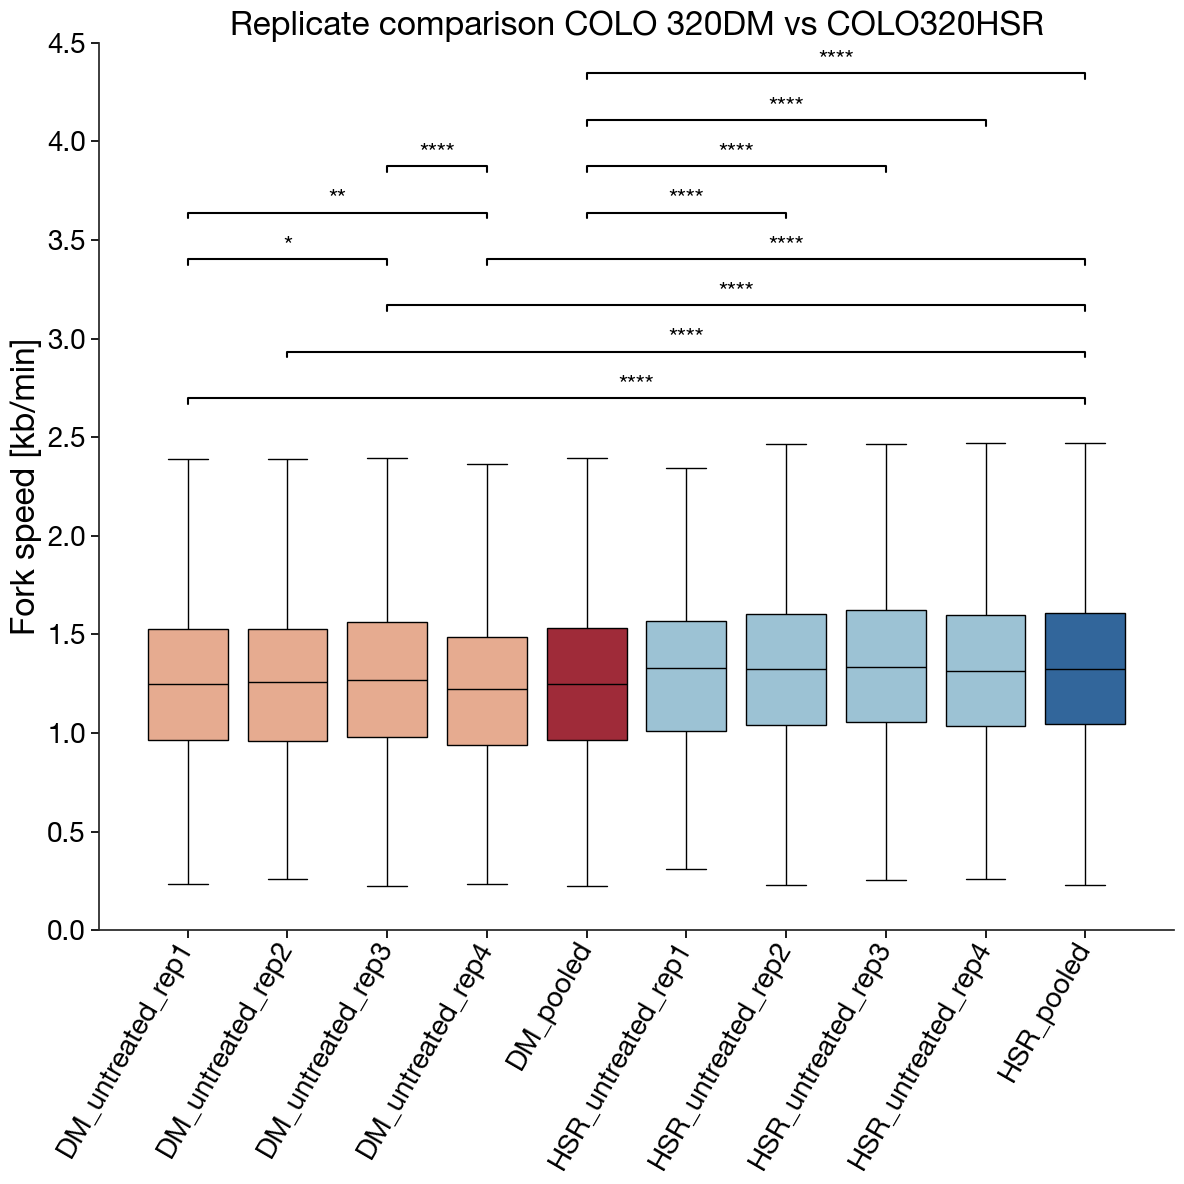

,replicate,median,mean,count
0,DM_pooled,1.249500,1.247565,12078
1,DM_untreated_rep1,1.249833,1.247973,4961
2,DM_untreated_rep2,1.256542,1.243430,1082
3,DM_untreated_rep3,1.266958,1.266242,3552
4,DM_untreated_rep4,1.223667,1.221831,2483
5,HSR_pooled,1.323875,1.324495,8384
6,HSR_untreated_rep1,1.327250,1.291510,267
7,HSR_untreated_rep2,1.322333,1.330306,1093
8,HSR_untreated_rep3,1.334167,1.332970,3595
9,HSR_untreated_rep4,1.312083,1.316326,3429


In [46]:
# DM vs HSR
cols = [colors_dict['red3']] * 4 + [colors_dict['red']] + [colors_dict['blue3']] * 4 + [colors_dict['blue']]

# pairs
pairs = [('DM_untreated_rep1', 'HSR_pooled'),
		 ('DM_untreated_rep2', 'HSR_pooled'),
		 ('DM_untreated_rep3', 'HSR_pooled'),
		 ('DM_untreated_rep4', 'HSR_pooled'),
		 ('DM_untreated_rep1', 'DM_untreated_rep2'),
		 ('DM_untreated_rep1', 'DM_untreated_rep3'),
		 ('DM_untreated_rep1', 'DM_untreated_rep4'),
		 ('DM_untreated_rep2', 'DM_untreated_rep3'),
		 ('DM_untreated_rep2', 'DM_untreated_rep4'),
		 ('DM_untreated_rep3', 'DM_untreated_rep4'),
		 ('HSR_untreated_rep1', 'DM_pooled'),
		 ('HSR_untreated_rep2', 'DM_pooled'),
		 ('HSR_untreated_rep3', 'DM_pooled'),
		 ('HSR_untreated_rep4', 'DM_pooled'),
		 ('HSR_untreated_rep1', 'HSR_untreated_rep2'),
		 ('HSR_untreated_rep1', 'HSR_untreated_rep3'),
		 ('HSR_untreated_rep1', 'HSR_untreated_rep4'),
		 ('HSR_untreated_rep2', 'HSR_untreated_rep3'),
		 ('HSR_untreated_rep2', 'HSR_untreated_rep4'),
		 ('HSR_untreated_rep3', 'HSR_untreated_rep4'),
		 ('HSR_pooled', 'DM_pooled')]	 

custom_order = ['DM_untreated_rep1', 'DM_untreated_rep2', 'DM_untreated_rep3', 'DM_untreated_rep4', 'DM_pooled', 'HSR_untreated_rep1', 'HSR_untreated_rep2', 'HSR_untreated_rep3', 'HSR_untreated_rep4', 'HSR_pooled']

# boxplot
plt.figure(figsize = (12, 12))
ax = sns.boxplot(data = df_DM_HSR, y = 'fork_speed', x = 'replicate', hue = 'replicate', order = custom_order, palette=cols, whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
#ax = sns.boxplot(data = combined_df, y = 'stall_score', x = 'source', order = custom_order, palette = [colors_dict['green2'], colors_dict['green3']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, df_DM_HSR, group_col = 'replicate', value_col = 'fork_speed', order = custom_order, comparisons = pairs, test = 'ttest_ind', display='stars', bracket_offset=0.2, text_offset=0.005, bracket_height = 0.03, only_sig=True)
# layout
plt.ylim(0, 4.5)
plt.ylabel('Fork speed [kb/min]', size = 24)
plt.xlabel('')
plt.title('Replicate comparison COLO 320DM vs COLO320HSR', size = 24)
plt.tick_params(axis='x', which='major', labelsize=20 , rotation=90)
plt.xticks(rotation=60, ha='right', va='center', rotation_mode='anchor')
plt.tick_params(axis='y', which='major', labelsize=20)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_06/' + date + '_replicate_boxplot' + '_DM_vs_HSR' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()

# print n, mean, median
group_stats = df_DM_HSR.groupby('replicate')['fork_speed'].agg(['median', 'mean', 'count']).reset_index()
display(group_stats)
group_stats.to_csv(outpath + '/figure_supp_06/' + date + '_replicate_boxplot_stats_speed' + '_DM_vs_HSR' + '.csv', sep = ',', index = False)

### Supplementary Figure S6b: DM vs DM-HU

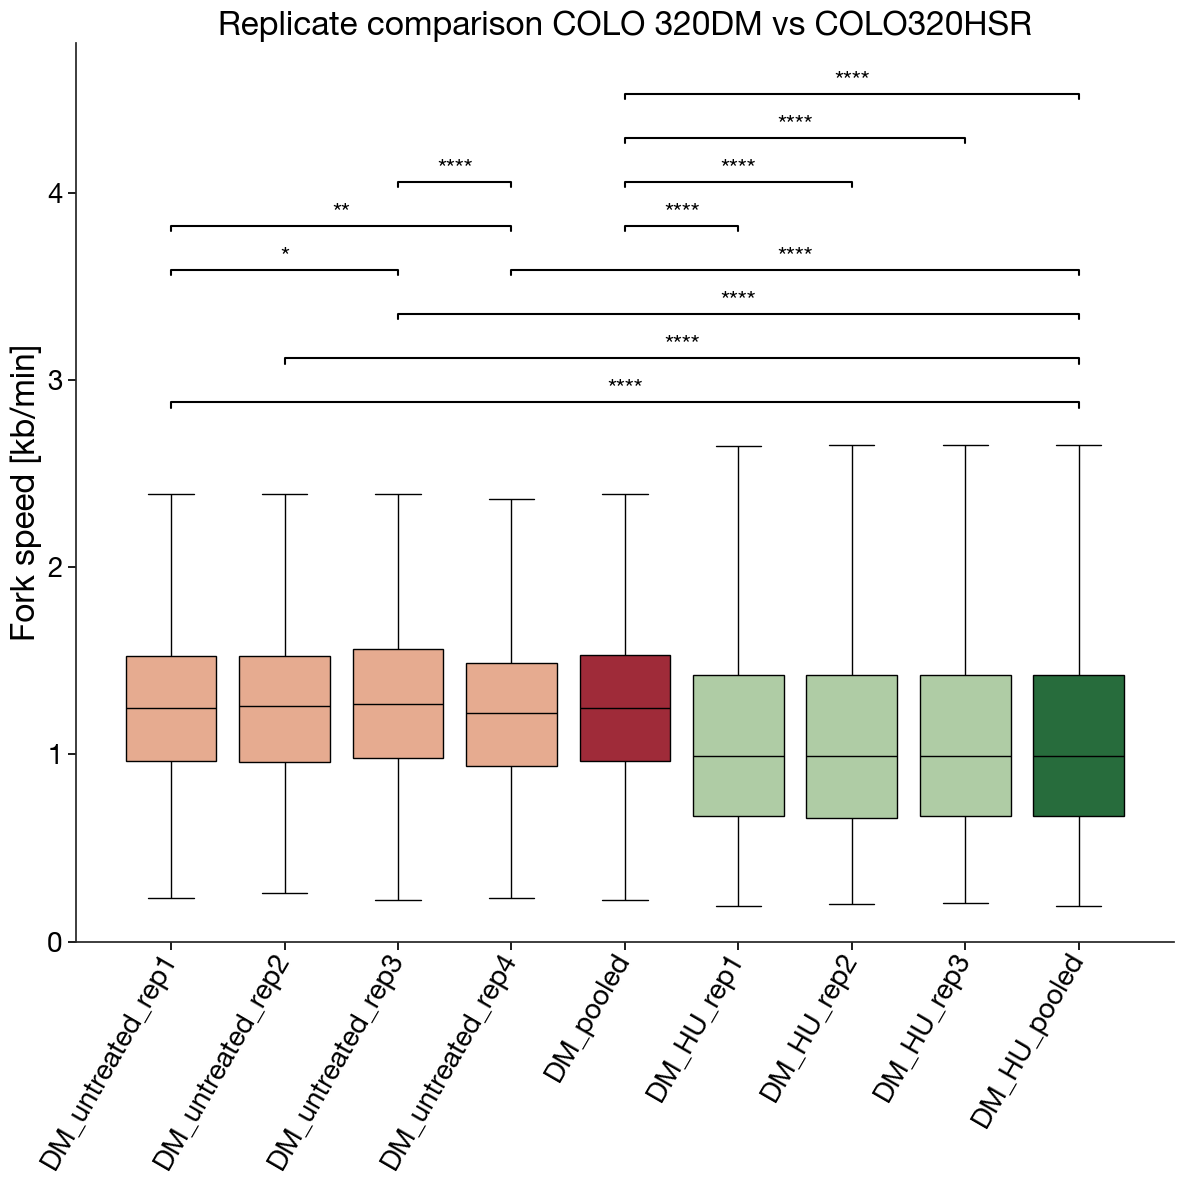

,replicate,median,mean,count
0,DM_HU_pooled,0.991417,1.087648,20409
1,DM_HU_rep1,0.990125,1.088003,6670
2,DM_HU_rep2,0.990792,1.084201,6240
3,DM_HU_rep3,0.992083,1.090202,7499
4,DM_pooled,1.249500,1.247565,12078
5,DM_untreated_rep1,1.249833,1.247973,4961
6,DM_untreated_rep2,1.256542,1.243430,1082
7,DM_untreated_rep3,1.266958,1.266242,3552
8,DM_untreated_rep4,1.223667,1.221831,2483


In [47]:
# DM vs DM-HU
cols = [colors_dict['red3']] * 4 + [colors_dict['red']] + [colors_dict['green3']] * 3 + [colors_dict['green']]

# pairs
pairs = [('DM_untreated_rep1', 'DM_HU_pooled'),
		 ('DM_untreated_rep2', 'DM_HU_pooled'),
		 ('DM_untreated_rep3', 'DM_HU_pooled'),
		 ('DM_untreated_rep4', 'DM_HU_pooled'),
		 ('DM_untreated_rep1', 'DM_untreated_rep2'),
		 ('DM_untreated_rep1', 'DM_untreated_rep3'),
		 ('DM_untreated_rep1', 'DM_untreated_rep4'),
		 ('DM_untreated_rep2', 'DM_untreated_rep3'),
		 ('DM_untreated_rep2', 'DM_untreated_rep4'),
		 ('DM_untreated_rep3', 'DM_untreated_rep4'),
		 ('DM_HU_rep1', 'DM_pooled'),
		 ('DM_HU_rep2', 'DM_pooled'),
		 ('DM_HU_rep3', 'DM_pooled'),
		 ('DM_HU_rep1', 'DM_HU_rep2'),
		 ('DM_HU_rep1', 'DM_HU_rep3'),
		 ('DM_HU_rep2', 'DM_HU_rep3'),
		 ('DM_HU_pooled', 'DM_pooled')]

custom_order = ['DM_untreated_rep1', 'DM_untreated_rep2', 'DM_untreated_rep3', 'DM_untreated_rep4', 'DM_pooled', 'DM_HU_rep1', 'DM_HU_rep2', 'DM_HU_rep3', 'DM_HU_pooled']

# boxplot
plt.figure(figsize = (12, 12))
ax = sns.boxplot(data = df_DM_DMHU, y = 'fork_speed', x = 'replicate', order = custom_order, hue = 'replicate',  palette=cols, whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
#ax = sns.boxplot(data = combined_df, y = 'stall_score', x = 'source', order = custom_order, palette = [colors_dict['green2'], colors_dict['green3']], whis = (0,100), flierprops={'marker': 'o'}, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
# p value annotations
annotate_p_values(ax, df_DM_DMHU, group_col = 'replicate', value_col = 'fork_speed', order = custom_order, comparisons = pairs, test = 'ttest_ind', display='stars', bracket_offset=0.2, text_offset=0.005, bracket_height = 0.03, only_sig=True)
# layout
plt.ylim(0, 4.8)
plt.ylabel('Fork speed [kb/min]', size = 24)
plt.xlabel('')
plt.title('Replicate comparison COLO 320DM vs COLO320HSR', size = 24)
plt.tick_params(axis='x', which='major', labelsize=20 , rotation=90)
plt.xticks(rotation=60, ha='right', va='center', rotation_mode='anchor')
plt.tick_params(axis='y', which='major', labelsize=20)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_06/' + date + '_replicate_boxplot' + '_DM_vs_DMHU' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()

# print n, mean, median
group_stats = df_DM_DMHU.groupby('replicate')['fork_speed'].agg(['median', 'mean', 'count']).reset_index()
display(group_stats)
group_stats.to_csv(outpath + '/figure_supp_06/' + date + '_replicate_boxplot_stats_speed' + '_DM_vs_DMHU' + '.csv', sep = ',', index = False)

# Supplementary Figure S7: HU impact on genome vs ecDNA

- for genome data: use genome excl. chr8
- take medians from boxplots to get an idea of log fold change

In [48]:
print('Fork speed medians from boxplot')
print(f'genome: {np.log2(1.25/1.00)}')
print(f'ecDNA: {np.log2(1.18/0.91)}')

print('Stall score medians from boxplot')
print(f'genome: {np.log2(0.38/0.30)}')
print(f'ecDNA: {np.log2(0.41/0.31)}')

Fork speed medians from boxplot
genome: 0.32192809488736235
ecDNA: 0.3748484091631448
Stall score medians from boxplot
genome: 0.3410369178350672
ecDNA: 0.40335569423120843


Procedure for assessing HU impact on ecDNA vs genome:

	1. take 100 randomly sampled forks of untreated or HU-treated from ecDNA or genome
	2. calculate median and keep track of median
	3. repeat 200 times
	4. calculate fold change on bootstrapped medians

In [49]:
#------------------------------- DATA -------------------------------

# source labels
df_DM_ecDNA['source'] = 'DM_ecDNA'
df_DM_hg38_chr8['source'] = 'DM_hg38' # use excl. chr8
df_DM_ecDNA_HU['source'] = 'DM_HU_ecDNA'
df_DM_hg38_HU_chr8['source'] = 'DM_HU_hg38' # use excl. chr8

# combine
combined_df = pd.concat([df_DM_ecDNA, df_DM_hg38_chr8, df_DM_ecDNA_HU, df_DM_hg38_HU_chr8])

### Supplementary Figure S7a: Fork speed fold change plot

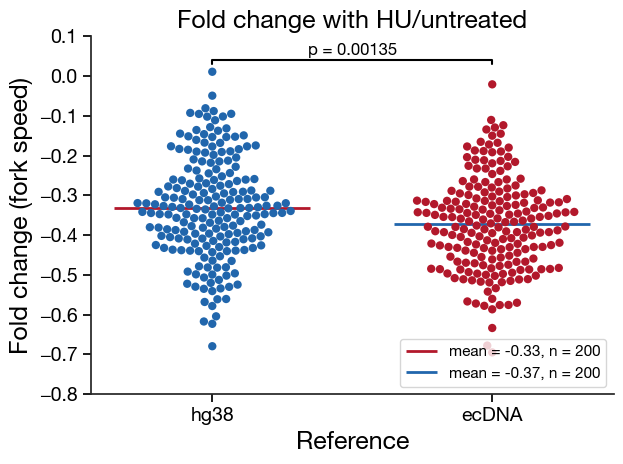

In [50]:
#------------------------------- RANDOMLY SAMPLE -------------------------------

# set seed
np.random.seed(42)

# number of bootstraps
n_bootstraps = 200

# initialize list of lists for bootstrapped medians
med_DM_ecDNA = []
med_DM_hg38 = []
med_DM_HU_ecDNA = []
med_DM_HU_hg38 = []

# initialize list of lists for fold change
fold_change_ecDNA_speed = []
fold_change_hg38_speed = []

# loop through bootstraps
for i in range(n_bootstraps):
	# sample 100 random forks
	sampled_df = combined_df.groupby('source')[combined_df.columns].apply(lambda grp: grp.sample(n=100)).reset_index(drop=True)
	# aggregate fork speed per dataset
	df_grouped = sampled_df.groupby(['source'])['fork_speed'].agg(['median', 'mean', 'count']).reset_index()
	# extract conditions
	hu_ecDNA = df_grouped[df_grouped["source"] == "DM_HU_ecDNA"]["median"].values
	hu_hg38 = df_grouped[df_grouped["source"] == "DM_HU_hg38"]["median"].values
	dm_ecDNA = df_grouped[df_grouped["source"] == "DM_ecDNA"]["median"].values
	dm_hg38 = df_grouped[df_grouped["source"] == "DM_hg38"]["median"].values
	# append medians
	med_DM_ecDNA.append(np.median(dm_ecDNA))
	med_DM_hg38.append(np.median(dm_hg38))
	med_DM_HU_ecDNA.append(np.median(hu_ecDNA))
	med_DM_HU_hg38.append(np.median(hu_hg38))
	# fold change of medians
	fold_change_ecDNA_speed.append(np.log2(np.median(hu_ecDNA) / np.median(dm_ecDNA)))
	fold_change_hg38_speed.append(np.log2(np.median(hu_hg38) / np.median(dm_hg38)))

#------------------------------- FOLD CHANGE -------------------------------

colors_fc = [colors_dict['red'], colors_dict['blue']]

# plot fold changes
fold_change_speed_comb = pd.DataFrame({
	'fold_change': np.concatenate([fold_change_ecDNA_speed, fold_change_hg38_speed]),
	'source': ['ecDNA'] * len(fold_change_ecDNA_speed) + ['hg38'] * len(fold_change_hg38_speed)
	})

# for stats and plotting define order
custom_order = ['hg38', 'ecDNA']
pairs = [('hg38', 'ecDNA')]

# for mean lines
group_stats = fold_change_speed_comb.groupby('source')['fold_change'].agg(['mean', 'count'])
group_stats.index = pd.Categorical(group_stats.index, categories = custom_order, ordered = True)
group_stats = group_stats.sort_index()

ax = sns.swarmplot(data = fold_change_speed_comb, y = 'fold_change', x = 'source', hue = 'source', order = custom_order, palette = colors_fc, size = 6)
#  mean lines with matching colors and dynamic labels
for i, row in enumerate(group_stats.itertuples()):
	group = row.Index
	mean = row.mean
	n = row.count 
	# calculate the xmin and xmax for each group based on the group's x-axis position
	xmin = i - 0.35
	xmax = i + 0.35
	ax.hlines(mean, xmin=xmin, xmax=xmax, color=colors_fc[i], linestyle='-', linewidth=2, label=f'mean = {mean:.2f}, n = {n}')
# p-value annotation
annotate_p_values(ax, fold_change_speed_comb, group_col = 'source', value_col = 'fold_change', order = custom_order, comparisons = pairs, test = 'ranksums', display='numeric', bracket_offset=0.02, text_offset=0.005, bracket_height = 0.01, p_value_fontsize = 12)
# labels
ax.legend(loc='lower right', fontsize = 11)
plt.ylim(-0.8, 0.1)
#plt.ylim(-0.1, 0.8)
plt.xlabel('Reference', size = 18)
plt.ylabel('Fold change (fork speed)', size = 18)
plt.title('Fold change with HU/untreated', size = 18)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_07/' + date + '_speed_fold_change' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


### Supplementary Figure S7b: Stall score fold change plot

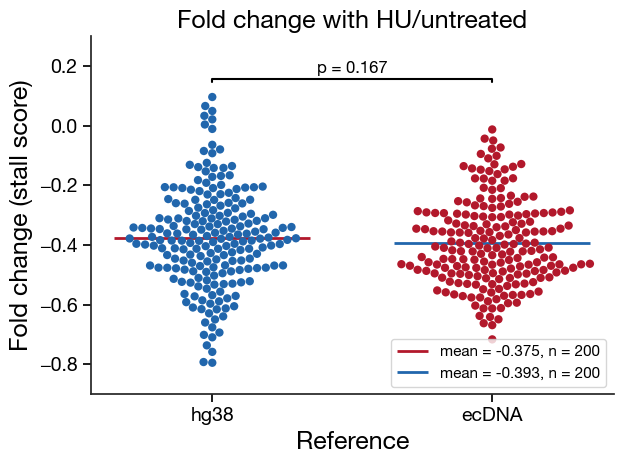

In [51]:
#------------------------------- RANDOMLY SAMPLE -------------------------------

# set seed
np.random.seed(42)

# number of bootstraps
n_bootstraps = 200

# initialize list of lists for bootstrapped medians
med_DM_ecDNA = []
med_DM_hg38 = []
med_DM_HU_ecDNA = []
med_DM_HU_hg38 = []

# initialize list of lists for fold change
fold_change_ecDNA_speed = []
fold_change_hg38_speed = []

# loop through bootstraps
for i in range(n_bootstraps):
	# sample 100 random forks
	sampled_df = combined_df.groupby('source')[combined_df.columns].apply(lambda grp: grp.sample(n=100)).reset_index(drop=True)
	# aggregate fork speed per dataset
	df_grouped = sampled_df.groupby(['source'])['stall_score'].agg(['median', 'mean', 'count']).reset_index()
	# extract conditions
	hu_ecDNA = df_grouped[df_grouped["source"] == "DM_HU_ecDNA"]["median"].values
	hu_hg38 = df_grouped[df_grouped["source"] == "DM_HU_hg38"]["median"].values
	dm_ecDNA = df_grouped[df_grouped["source"] == "DM_ecDNA"]["median"].values
	dm_hg38 = df_grouped[df_grouped["source"] == "DM_hg38"]["median"].values
	# append medians
	med_DM_ecDNA.append(np.median(dm_ecDNA))
	med_DM_hg38.append(np.median(dm_hg38))
	med_DM_HU_ecDNA.append(np.median(hu_ecDNA))
	med_DM_HU_hg38.append(np.median(hu_hg38))
	# fold change of medians
	fold_change_ecDNA_speed.append(np.log2(np.median(hu_ecDNA) / np.median(dm_ecDNA)))
	fold_change_hg38_speed.append(np.log2(np.median(hu_hg38) / np.median(dm_hg38)))

#------------------------------- FOLD CHANGE -------------------------------

colors_fc = [colors_dict['red'], colors_dict['blue']]

# plot fold changes
fold_change_speed_comb = pd.DataFrame({
	'fold_change': np.concatenate([fold_change_ecDNA_speed, fold_change_hg38_speed]),
	'source': ['ecDNA'] * len(fold_change_ecDNA_speed) + ['hg38'] * len(fold_change_hg38_speed)
	})

# for stats and plotting define order
custom_order = ['hg38', 'ecDNA']
pairs = [('hg38', 'ecDNA')]

# for mean lines
group_stats = fold_change_speed_comb.groupby('source')['fold_change'].agg(['mean', 'count'])
group_stats.index = pd.Categorical(group_stats.index, categories = custom_order, ordered = True)
group_stats = group_stats.sort_index()

ax = sns.swarmplot(data = fold_change_speed_comb, y = 'fold_change', x = 'source', hue = 'source', order = custom_order, palette = colors_fc, size = 6)
#  mean lines with matching colors and dynamic labels
for i, row in enumerate(group_stats.itertuples()):
	group = row.Index
	mean = row.mean
	n = row.count 
	# calculate the xmin and xmax for each group based on the group's x-axis position
	xmin = i - 0.35
	xmax = i + 0.35
	ax.hlines(mean, xmin=xmin, xmax=xmax, color=colors_fc[i], linestyle='-', linewidth=2, label=f'mean = {mean:.3f}, n = {n}')
# p-value annotation
annotate_p_values(ax, fold_change_speed_comb, group_col = 'source', value_col = 'fold_change', order = custom_order, comparisons = pairs, test = 'ranksums', display='numeric', bracket_offset=0.05, text_offset=0.01, bracket_height = 0.01, p_value_fontsize = 12)
# labels
ax.legend(loc='lower right', fontsize = 11)
plt.ylim(-0.9, 0.3)
#plt.ylim(-0.2, 1)
plt.xlabel('Reference', size = 18)
plt.ylabel('Fold change (stall score)', size = 18)
plt.title('Fold change with HU/untreated', size = 18)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()
plt.savefig(outpath + '/figure_supp_07/' + date + '_stall_fold_change' + '.pdf', bbox_inches='tight')
plt.show()
plt.close()


# List of all Python packages and versions

In [52]:
# print all used packages and versions
rows = []

# Python version
rows.append({'module': 'Python', 'version': sys.version.split()[0]})

# package versions
for name, module in sorted(sys.modules.items()):
	if module and hasattr(module, '__version__'):
		rows.append({'module': name, 'version': module.__version__})

df_versions = pd.DataFrame(rows)
df_versions.reset_index(drop = True, inplace = True)
df_versions.style.format()

/var/folders/m1/snn0v3cj5x31vv4clrmnrch40000gn/T/ipykernel_863/1930065184.py:9: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.__version__.
  if module and hasattr(module, '__version__'):
/var/folders/m1/snn0v3cj5x31vv4clrmnrch40000gn/T/ipykernel_863/1930065184.py:10: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to a

,module,version
0,Python,3.11.5
1,Bio,1.85
2,IPython,9.0.2
3,IPython.core.release,9.0.2
4,IPython.external.pickleshare,0.7.5
5,PIL,11.1.0
6,PIL.Image,11.1.0
7,PIL._deprecate,11.1.0
8,PIL._version,11.1.0
9,_csv,1.0
